# The Predictive Power of Speech Sentiment

**The purpose of this analysis is to see which sentiment scores have a relatively high correlation with key economic indicators and the degree to which sentiment scores have predictive power in their own right before including additional economic indicators as features.**

## Libraries

In [1]:
# Import relevant libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import itertools
from itertools import product
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, silhouette_score, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.optimize import curve_fit
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from typing import List, Union
from dateutil.relativedelta import relativedelta
from datetime import datetime
from typing import List, Dict, Union, Optional, Tuple

import warnings
warnings.filterwarnings('ignore')

## Functions

**Note: Most of these functions were developed in conversation AI chatbots (Claude and ChatGPT).**

### Data Validation

In [2]:
# Data validation function
def validate_data(df):
    """
    This function compiles several functions for validating a dataframe.

    Arg:
        df: dataframe name

    Returns:
        prints missing counts
        prints unique counts per column
        prints duplicate counts
        prints summary statistics for the dataframe
    """
    #check for missing values
    missing_counts = df.isnull().sum()
    print("Missing values per column:")
    print(missing_counts)
    
    #check for unique values
    unique_counts = df.nunique()
    print("\nUnique values per column:")
    print(unique_counts)
    
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)
    
    #summary stats
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats)

    #zero values
    no_zeros = df.ne(0).all()
    print("\nColumn has no zero values?")
    print(no_zeros)

### Add Future Monthly Indicators Difference

**This function calculates the difference between the economic indicator values in the month a speech was given and 1, 2, and 3 months later. It lets you specify whether to subtract the difference (for rates) or calculate the percentage change (for absolute values).**

In [3]:
def add_future_indicator_changes_monthly(df, date_col, indicators, subtraction_indicators=None, percentage_indicators=None, debug=False):
    """
    Add columns for future changes in economic indicators to a dataframe with speeches.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing speeches and economic indicators
    date_col : str
        Name of the column containing speech dates
    indicators : list
        List of economic indicator column names
    subtraction_indicators : list, optional
        List of indicators for which changes should be calculated by subtraction
        (for rates or values that can be zero)
    percentage_indicators : list, optional
        List of indicators for which changes should be calculated as percentage changes
    debug : bool, optional
        If True, prints debugging information and keeps future value columns
        
    Returns:
    --------
    pandas.DataFrame
        Original dataframe with added columns for 1, 2, and 3 month changes for each indicator
    """
    
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[date_col]):
        result_df[date_col] = pd.to_datetime(result_df[date_col])
    
    # Extract year and month from the date column to facilitate matching
    result_df['speech_year'] = result_df[date_col].dt.year
    result_df['speech_month'] = result_df[date_col].dt.month
    
    # Set up indicator lists based on parameters
    if subtraction_indicators is None and percentage_indicators is None:
        # Default: treat all indicators as percentage changes
        subtraction_indicators = []
        percentage_indicators = indicators
    elif subtraction_indicators is None:
        # If only percentage_indicators is provided, calculate the complement
        subtraction_indicators = [ind for ind in indicators if ind not in percentage_indicators]
    elif percentage_indicators is None:
        # If only subtraction_indicators is provided, calculate the complement
        percentage_indicators = [ind for ind in indicators if ind not in subtraction_indicators]
    
    if debug:
        print(f"Processing {len(result_df)} rows with {len(indicators)} indicators")
        print(f"Subtraction indicators: {subtraction_indicators}")
        print(f"Percentage indicators: {percentage_indicators}")
        # Show sample of data with indicators
        print("\nSample data with indicators:")
        print(result_df[[date_col, 'speech_year', 'speech_month'] + indicators].head())
    
    # Create a monthly time series of economic indicators
    # Instead of using the original dataframe, which might have multiple speeches per month,
    # create a separate dataframe with one row per month that has all economic indicators
    
    # First, identify all unique year-month combinations in the dataset
    all_months = result_df[['speech_year', 'speech_month']].drop_duplicates()
    
    # Create a monthly indicators dataframe
    monthly_indicators = []
    
    # For each year-month combination, get the corresponding economic indicators
    # If there are multiple values for the same month, take the average
    for _, row in all_months.iterrows():
        year, month = row['speech_year'], row['speech_month']
        mask = (result_df['speech_year'] == year) & (result_df['speech_month'] == month)
        month_data = result_df.loc[mask, indicators].mean().to_dict()
        month_data['year'] = year
        month_data['month'] = month
        monthly_indicators.append(month_data)
    
    monthly_indicators = pd.DataFrame(monthly_indicators)
    
    if debug:
        print("\nMonthly indicator data:")
        print(monthly_indicators.head())
        print(f"Number of unique months: {len(monthly_indicators)}")
    
    # Prepare to store all the future values and changes
    future_data = []
    
    # For each speech, we need to calculate changes for future months
    for _, row in result_df.iterrows():
        speech_year = row['speech_year']
        speech_month = row['speech_month']
        row_data = {'speech_index': row.name}  # Store the original index for merging later
        
        # Get current indicator values
        current_values = {ind: row[ind] for ind in indicators}
        
        # For each month ahead
        for months_ahead in [1, 2, 3]:
            # Calculate the future month and year
            future_month = speech_month + months_ahead
            future_year = speech_year
            
            # Adjust for year boundaries
            if future_month > 12:
                future_year += (future_month - 1) // 12
                future_month = ((future_month - 1) % 12) + 1
            
            # Find the future month's indicators
            future_values = monthly_indicators[
                (monthly_indicators['year'] == future_year) & 
                (monthly_indicators['month'] == future_month)
            ]
            
            if len(future_values) == 0:
                if debug:
                    print(f"No data found for future date: {future_year}-{future_month}")
                continue
            
            # Store future values and calculate changes
            for ind in indicators:
                future_val = future_values[ind].values[0]
                current_val = current_values[ind]
                
                # Store future value
                future_col = f"{ind}_future_{months_ahead}m"
                row_data[future_col] = future_val
                
                # Calculate changes
                change_col = f"{ind}_change_{months_ahead}m"
                if ind in subtraction_indicators:
                    row_data[change_col] = future_val - current_val
                elif ind in percentage_indicators:
                    if current_val != 0:
                        row_data[change_col] = ((future_val - current_val) / current_val) * 100
                    else:
                        row_data[change_col] = np.nan
        
        future_data.append(row_data)
    
    # Convert the list of dictionaries to a DataFrame
    future_df = pd.DataFrame(future_data)
    
    if not future_df.empty:
        # Merge the future data back to the original DataFrame using the stored index
        result_df = pd.merge(
            result_df, 
            future_df, 
            left_index=True,
            right_on='speech_index',
            how='left'
        )
        
        # Drop the temporary index column
        result_df.drop(columns=['speech_index'], inplace=True)
    else:
        if debug:
            print("No future data was calculated. Check if monthly_indicators contains data.")
    
    if debug:
        print("\nSample results:")
        sample_cols = [date_col, 'speech_year', 'speech_month']
        for ind in indicators:
            sample_cols.extend([ind] + [f"{ind}_change_{m}m" for m in [1, 2, 3]])
            if not all(col in result_df.columns for col in [f"{ind}_future_{m}m" for m in [1, 2, 3]]):
                print(f"Warning: Future columns for {ind} not found in dataframe")
        
        try:
            print(result_df[sample_cols].head())
        except KeyError as e:
            print(f"Some columns not found: {e}")
            available_cols = sorted([col for col in result_df.columns if 'change' in col or ind in col for ind in indicators])
            print(f"Available indicator-related columns: {available_cols}")
        
        # Check for zeros
        for ind in indicators:
            for m in [1, 2, 3]:
                col = f"{ind}_change_{m}m"
                if col in result_df.columns:
                    zero_pct = (result_df[col] == 0).mean() * 100
                    print(f"{col}: {zero_pct:.1f}% zeros")
                    # Also check for NaN values
                    nan_pct = result_df[col].isna().mean() * 100
                    print(f"{col}: {nan_pct:.1f}% NaN values")
    
    # Drop temporary columns unless in debug mode
    if not debug:
        cols_to_drop = [col for col in result_df.columns if '_future_' in col]
        if cols_to_drop:
            result_df.drop(columns=cols_to_drop, inplace=True)
    
    return result_df

# Example usage:
# 
# # Run with debug=True to see detailed information:
# df_with_changes = add_future_indicator_changes(
#     df=speeches_df,
#     date_col='speech_date',
#     indicators=['inflation_rate', 'unemployment_rate', 'gdp_growth', 'interest_rate'],
#     subtraction_indicators=['inflation_rate', 'interest_rate'],
#     percentage_indicators=['unemployment_rate', 'gdp_growth'],
#     debug=True
# )

### Add 10-Speech Simple Moving Average of Sentiment Scores

In [4]:
def add_sentiment_moving_averages(df, sentiment_columns=None, window_size=10, date_column='date'):
    """
    Add simple moving averages for sentiment columns to a dataframe of central bank speeches.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing central bank speech data with sentiment scores
    sentiment_columns : list, optional
        List of column names for which to calculate moving averages.
        If None, all numeric columns except the date column will be used.
    window_size : int, optional
        Size of the moving average window (number of speeches to include), default is 10
    date_column : str, optional
        Name of the date column to sort by, default is 'date'
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional columns for moving averages
    """
    
    # Make a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    # Convert date column to datetime if not already
    result_df[date_column] = pd.to_datetime(result_df[date_column])
    
    # Sort by date in ascending order
    result_df = result_df.sort_values(by=date_column, ascending=True)
    
    # If no sentiment columns provided, use all numeric columns excluding date
    if sentiment_columns is None:
        numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        sentiment_columns = [col for col in result_df.columns if 
                           result_df[col].dtype in numeric_dtypes and 
                           col != date_column]
    
    # Create a moving average for each sentiment column
    for column in sentiment_columns:
        if column in result_df.columns:
            # Create a new column name for the moving average
            ma_column = f"{column}_ma{window_size}"
            
            # Calculate the moving average
            result_df[ma_column] = result_df[column].rolling(window=window_size).mean()
        else:
            print(f"Warning: Column '{column}' not found in dataframe")
    
    return result_df

# Example usage:
# df = pd.read_csv('central_bank_speeches.csv')
# sentiment_cols = ['positive_sentiment', 'negative_sentiment', 'uncertainty']
# df_with_ma = add_sentiment_moving_averages(df, sentiment_cols, window_size=10)

### Add Moving Average for Monthly Economic Indicators

In [5]:
def add_moving_averages(df, economic_indicators, date_col='date', month_col='month', 
                       ma_windows=None, special_indicators=None):
    """
    Add moving average columns for economic indicators to a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing speech data with economic indicators
    economic_indicators : list
        List of column names representing economic indicators
    date_col : str, default 'date'
        Name of the date column
    month_col : str, default 'month'
        Name of the month column
    ma_windows : dict, optional
        Dictionary mapping indicator names to their moving average window sizes.
        Default is 3 months for all indicators.
    special_indicators : dict, optional
        Dictionary mapping indicator names to custom window sizes.
        This is kept for backwards compatibility.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional moving average columns
    """
    
    # Create a copy to avoid modifying the original
    df_result = df.copy()
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_result[date_col]):
        df_result[date_col] = pd.to_datetime(df_result[date_col])
    
    # Sort by date to ensure proper chronological order
    df_result = df_result.sort_values(date_col).reset_index(drop=True)
    
    # Create a reference DataFrame with unique months and their indicators
    # This handles the case where multiple speeches might be in the same month
    monthly_data = df_result.groupby(month_col)[economic_indicators].first().reset_index()
    monthly_data = monthly_data.sort_values(month_col)
    
    # Set up window sizes - default to 3 months unless specified
    if ma_windows is None:
        ma_windows = {}
    if special_indicators is not None:
        ma_windows.update(special_indicators)
    
    # Calculate moving averages for each indicator
    ma_columns = []
    for indicator in economic_indicators:
        window_size = ma_windows.get(indicator, 3)  # Default to 3 months
        ma_col_name = f"{indicator}_{window_size}mo_ma"
        
        monthly_data[ma_col_name] = monthly_data[indicator].rolling(
            window=window_size, 
            min_periods=1,  # Include periods with less data than window size
            center=False    # Use trailing window
        ).mean()
        
        ma_columns.append(ma_col_name)
    merge_columns = [month_col] + ma_columns
    
    df_result = df_result.merge(
        monthly_data[merge_columns], 
        on=month_col, 
        how='left'
    )
    
    # Restore original order if needed
    if 'original_index' not in df_result.columns:
        # If no original index was preserved, sort by date
        df_result = df_result.sort_values(date_col).reset_index(drop=True)
    
    return df_result


# Example usage:
"""
# Assume your DataFrame looks like this:
# df = pd.DataFrame({
#     'date': ['2023-01-15', '2023-02-20', '2023-03-10'],
#     'month': ['2023-01', '2023-02', '2023-03'],
#     'unemployment_rate': [3.5, 3.6, 3.4],
#     'inflation_rate': [2.1, 2.3, 2.0],
#     'gdp_quarterly': [1.8, 1.8, 1.8]  # Forward-filled quarterly data
# })

# For different moving average windows:
# economic_indicators = ['unemployment_rate', 'inflation_rate', 'gdp_quarterly']
# ma_windows = {'gdp_quarterly': 9}  # 9-month MA for GDP, 3-month for others
# df_with_ma = add_moving_averages(df, economic_indicators, ma_windows=ma_windows)

# This will add columns: 
# - unemployment_rate_3mo_ma
# - inflation_rate_3mo_ma  
# - gdp_quarterly_9mo_ma

# Alternative syntax using special_indicators (backwards compatible):
# df_with_ma = add_moving_averages(df, economic_indicators, 
#                                 special_indicators={'gdp_quarterly': 9})
"""


def add_gdp_moving_average(df, gdp_col='gdp_quarterly', date_col='date', month_col='month'):
    """
    Convenience function specifically for adding 9-month moving average to quarterly GDP data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing speech data with GDP indicator
    gdp_col : str, default 'gdp_quarterly'
        Name of the GDP column
    date_col : str, default 'date'
        Name of the date column
    month_col : str, default 'month'
        Name of the month column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional GDP 9-month moving average column
    """
    return add_moving_averages(df, [gdp_col], date_col, month_col, 
                              ma_windows={gdp_col: 9})

### Add Future Indicators for Monthly Data

In [6]:
def add_forward_indicators(df, indicator_columns, date_col='date', month_col='month'):
    """
    Add forward-looking economic indicator columns to a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing speeches with economic indicators
    indicator_columns : list
        List of column names for economic indicators to create forward-looking versions
    date_col : str, default 'date'
        Name of the column containing speech dates
    month_col : str, default 'month'
        Name of the column containing the month (for matching economic data)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional columns for 1, 2, and 3 months forward indicators
    """
    
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[date_col]):
        result_df[date_col] = pd.to_datetime(result_df[date_col])
    
    # Create a lookup dictionary for economic indicators by month
    # This assumes your economic data is organized by month
    econ_lookup = {}
    for _, row in result_df.iterrows():
        month_key = row[month_col]
        if month_key not in econ_lookup:
            econ_lookup[month_key] = {}
        
        for indicator in indicator_columns:
            if pd.notna(row[indicator]):
                econ_lookup[month_key][indicator] = row[indicator]
    
    # Function to get future month key (handles year transitions)
    def get_future_month_key(current_date, months_ahead):
        future_date = current_date + relativedelta(months=months_ahead)
        # Adjust this based on how your month column is formatted
        # Common formats: 'YYYY-MM', 'MM/YYYY', datetime, etc.
        if isinstance(result_df[month_col].iloc[0], str):
            # Assuming format like 'YYYY-MM' or similar
            return future_date.strftime('%Y-%m') if '-' in str(result_df[month_col].iloc[0]) else future_date.strftime('%m/%Y')
        else:
            # If month_col contains datetime objects
            return future_date.replace(day=1)
    
    # Add forward-looking columns for each indicator
    for indicator in indicator_columns:
        for months_ahead in [1, 2, 3]:
            new_col_name = f"{indicator}_{months_ahead}m_forward"
            
            # Initialize the new column with NaN
            result_df[new_col_name] = np.nan
            
            # Fill in values where data is available
            for idx, row in result_df.iterrows():
                try:
                    speech_date = row[date_col]
                    future_month_key = get_future_month_key(speech_date, months_ahead)
                    
                    # Look up the economic indicator value for the future month
                    if (future_month_key in econ_lookup and 
                        indicator in econ_lookup[future_month_key]):
                        result_df.loc[idx, new_col_name] = econ_lookup[future_month_key][indicator]
                        
                except Exception as e:
                    # Handle any date parsing or lookup errors gracefully
                    continue
    
    return result_df

### Sentiment/Economic Indicator Correlations

In [7]:
def analyze_sentiment_economic_correlations(df, sentiment_columns, economic_columns, method='pearson'):
    """
    Perform correlation analysis between sentiment scores and economic indicators.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    sentiment_columns : list
        List of column names containing sentiment scores
    economic_columns : list
        List of column names containing economic indicators
    method : str, default='pearson'
        Correlation method ('pearson', 'spearman', or 'kendall')
    
    Returns:
    --------
    list of dict
        List of correlation results sorted by absolute correlation value (descending)
        Each dict contains: sentiment_var, economic_var, correlation, abs_correlation, p_value
    """
    
    # Validate inputs
    missing_sentiment = [col for col in sentiment_columns if col not in df.columns]
    missing_economic = [col for col in economic_columns if col not in df.columns]
    
    if missing_sentiment:
        raise ValueError(f"Sentiment columns not found in DataFrame: {missing_sentiment}")
    if missing_economic:
        raise ValueError(f"Economic columns not found in DataFrame: {missing_economic}")
    
    results = []
    
    # Calculate correlations for all combinations
    for sentiment_col, economic_col in product(sentiment_columns, economic_columns):
        # Get the two series, dropping NaN values pairwise
        data = df[[sentiment_col, economic_col]].dropna()
        
        if len(data) < 3:  # Need at least 3 observations for meaningful correlation
            results.append({
                'sentiment_var': sentiment_col,
                'economic_var': economic_col,
                'correlation': np.nan,
                'abs_correlation': 0,  # Will be sorted to bottom
                'p_value': np.nan,
                'n_observations': len(data)
            })
            continue
        
        # Calculate correlation and p-value
        if method == 'pearson':
            from scipy.stats import pearsonr
            corr, p_val = pearsonr(data[sentiment_col], data[economic_col])
        elif method == 'spearman':
            from scipy.stats import spearmanr
            corr, p_val = spearmanr(data[sentiment_col], data[economic_col])
        elif method == 'kendall':
            from scipy.stats import kendalltau
            corr, p_val = kendalltau(data[sentiment_col], data[economic_col])
        else:
            raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")
        
        results.append({
            'sentiment_var': sentiment_col,
            'economic_var': economic_col,
            'correlation': corr,
            'abs_correlation': abs(corr) if not np.isnan(corr) else 0,
            'p_value': p_val,
            'n_observations': len(data)
        })
    
    # Sort by absolute correlation value (descending)
    results.sort(key=lambda x: x['abs_correlation'], reverse=True)
    
    return results

def print_correlation_results(results, top_n=None, significance_level=0.05):
    """
    Pretty print correlation results.
    
    Parameters:
    -----------
    results : list
        Output from analyze_sentiment_economic_correlations
    top_n : int, optional
        Number of top results to display
    significance_level : float, default=0.05
        P-value threshold for significance marking
    """
    
    if top_n:
        results = results[:top_n]
    
    print(f"{'Sentiment Variable':<25} {'Economic Variable':<25} {'Correlation':<12} {'P-value':<10} {'N':<6} {'Sig':<4}")
    print("-" * 85)
    
    for result in results:
        sentiment_var = result['sentiment_var'][:24]  # Truncate if too long
        economic_var = result['economic_var'][:24]
        corr = result['correlation']
        p_val = result['p_value']
        n_obs = result['n_observations']
        
        # Mark significance
        sig_mark = "***" if not np.isnan(p_val) and p_val < significance_level else ""
        
        if np.isnan(corr):
            corr_str = "NaN"
            p_str = "NaN"
        else:
            corr_str = f"{corr:.4f}"
            p_str = f"{p_val:.4f}" if not np.isnan(p_val) else "NaN"
        
        print(f"{sentiment_var:<25} {economic_var:<25} {corr_str:<12} {p_str:<10} {n_obs:<6} {sig_mark:<4}")

### Simple Linear Regressions (Batch Processing)

In [8]:
def analyze_simple_sentiment_economic_impact(df, sentiment_cols, economic_cols, test_size=0.2, random_state=42):
    """
    Performs linear regressions between specified sentiment scores and economic indicators,
    using an 80/20 train-test split and evaluating R-squared on the test set.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing sentiment scores and economic indicators.
    sentiment_cols : list of str
        Column names for sentiment scores (X variables).
    economic_cols : list of str
        Column names for economic indicators (y variables).
    test_size : float, default=0.2
        Fraction of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns:
    --------
    pandas.DataFrame
        Table with regression results including R-squared values (on test set) 
        for each sentiment-indicator combination.
    """
    # Check if all columns exist
    missing_sentiment = [col for col in sentiment_cols if col not in df.columns]
    missing_economic = [col for col in economic_cols if col not in df.columns]

    if missing_sentiment:
        raise ValueError(f"Sentiment columns {missing_sentiment} not found in DataFrame")
    if missing_economic:
        raise ValueError(f"Economic indicator columns {missing_economic} not found in DataFrame")

    # Initialize result storage
    sentiment_list = []
    indicator_list = []
    r2_values = []
    slopes = []
    intercepts = []
    sample_sizes = []

    model = LinearRegression()

    for sentiment_col in sentiment_cols:
        X_full = df[sentiment_col].values

        for economic_col in economic_cols:
            y_full = df[economic_col].values

            temp_df = pd.DataFrame({'X': X_full, 'y': y_full}).dropna()

            if len(temp_df) < 5:
                # Too few samples for a reliable train/test split
                sentiment_list.append(sentiment_col)
                indicator_list.append(economic_col)
                r2_values.append(np.nan)
                slopes.append(np.nan)
                intercepts.append(np.nan)
                sample_sizes.append(len(temp_df))
                continue

            # Prepare train/test split
            X = temp_df['X'].values.reshape(-1, 1)
            y = temp_df['y'].values
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            sentiment_list.append(sentiment_col)
            indicator_list.append(economic_col)
            r2_values.append(r2)
            slopes.append(model.coef_[0])
            intercepts.append(model.intercept_)
            sample_sizes.append(len(temp_df))

    results = pd.DataFrame({
        'Sentiment Metric': sentiment_list,
        'Economic Indicator': indicator_list,
        'R-squared (Test)': r2_values,
        'Slope': slopes,
        'Intercept': intercepts,
        'Sample Size': sample_sizes
    })

    return results.sort_values('R-squared (Test)', ascending=False)

# # Example usage:
# # Identify sentiment columns
# sentiment_cols = ['finbert_score']
# 
# # Identify economic columns
# economic_cols = ['ftse250']
#
# # Run the regression analysis
# results = analyze_multiple_sentiment_economic_impact(df, sentiment_cols=sentiment_cols, economic_cols=economic_cols)
# print(results)
# 

### Linear Regression with Evaluation Metrics

In [9]:
# Linear regression function
def lin_reg(df, X, y, **kwargs):
    """
    This function (CODENAME: REGRESSBOT 3000) was created in conversation with ChatGPT and the Claude AI Chatbot.
    It can perform a simple or multiple linear regression using the selected dataframe, x variable(s), and y variable.
    It uses an 80/20 train and test split.
    It provides summary stastics, residual plots, residual histograms, and q-q plots.
    It plots the regression line for simple linear regressions.
    It provides VIF statistics for multiple linear regressions.
    It contains multitudes.

    Args:
        df: dataframe name
        X: column name(s) for independent variable(s)
        y: column name for dependent variable

    Returns:
        prints head and tail of predicted y values
        prints error statistics
        prints R-squared statistics
        prints OLS summary statistics for the test set
        prints residuals plot, histogram and q-q plot
        prints regression line (SLR)
        prints VIF values (MLR)
    """
    # Define the dependent variable
    y = df[y]

    # Define the independent variables
    X = df[X]

    # Split the data into training (80%) and testing (20%) sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Run regression on the train subset
    mlr = LinearRegression()
    mlr.fit(x_train, y_train)

    # Predict on training data
    y_pred_train = mlr.predict(x_train)

    # Calculate residuals
    residuals = y_train - y_pred_train

    # Predictions on the test set
    y_pred_test = mlr.predict(x_test)

    # View the output head and tail
    print("Predicted y values (head and tail):")
    print(y_pred_test[:5])
    print("...")
    print(y_pred_test[-5:],"\n")

    # Calculate mean absolute error
    mae = metrics.mean_absolute_error(y_test, y_pred_test)
    print("Mean Absolute Error:", mae)

    # Calculate mean squared error
    mse = metrics.mean_squared_error(y_test, y_pred_test)
    print("Mean Squared Error:", mse)

    # Calculate root mean squared error
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    # Print R-squared value for training set
    r2_train = mlr.score(x_train, y_train)
    print("R-squared for training set: ", r2_train * 100)

    # Print R-squared value for test set
    r2_test = mlr.score(x_test, y_test)
    print("R-squared for test set: ", r2_test * 100, "\n")
    
    # Add a constant (intercept) to the independent variables in the training set.
    x_const = sm.add_constant(x_train) 

    # Fit model
    ols = sm.OLS(y_train, x_const).fit()

    # Summary includes the coefficient and Prob (F-statistic)
    print(ols.summary())

    # Check for multicollinearity using VIF (only if there are at least 2 variables)
    if len(x_const.columns) >= 3:

        # Create subplots: Residual plot, Q-Q plot, Histogram
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Residual plot
        axs[0].scatter(y_pred_train, residuals)
        axs[0].axhline(y=0, color='red', linestyle='--')
        axs[0].set_xlabel("Predicted Values")
        axs[0].set_ylabel("Residuals")
        axs[0].set_title("Residual Plot")

        # Histogram of residuals
        axs[1].hist(residuals, bins=20, edgecolor='black')
        axs[1].set_title("Histogram of Residuals")
        axs[1].set_xlabel("Residual")
        axs[1].set_ylabel("Frequency")

        # Q-Q plot
        sm.qqplot(residuals, fit=True, line='45', ax=axs[2])
        axs[2].set_title("Q-Q Plot of Residuals")
        axs[2].set_xlabel("Normal Quartiles")
        axs[2].set_ylabel("Residual Quartiles")

        # Calculate and print adjusted R-squared for training set
        n = x_train.shape[0]  # number of samples
        p = x_train.shape[1]  # number of predictors
        adj_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
        print("Adjusted R-squared for training set: ", adj_r2_train * 100)

        # Calculate adjusted R-squared for test set
        n = x_test.shape[0]  # number of samples
        p = x_test.shape[1]  # number of predictors
        adj_r2_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)
        print("Adjusted R-squared for test set: ", adj_r2_test * 100, "\n")

        # Initializes an empty DataFrame to store VIF values and corresponding features
        vif = pd.DataFrame()
            
        # Calculate the VIF for each independent variable in the training set
        vif['VIF Factor'] = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
            
        # Adds the feature names to the VIF DataFrame
        vif['features'] = x_const.columns
            
        # Print VIF values
        print("Variance Inflation Factors:")
        print(vif.round(1))
    else:
        # Get the column names for better labeling
        x_col_name = clean_label(X.columns[0])
        y_col_name = clean_label(y.name) if hasattr(y, 'name') else 'y'
        
        # Create subplots: Regression line, Residual plot, Q-Q plot, Histogram
        fig, axs = plt.subplots(2, 2, figsize=(18, 12))

        # Regression line
        axs[0, 0].scatter(X, y)
        axs[0, 0].plot(x_train, y_pred_train, color='black')
        axs[0, 0].set_xlabel(x_col_name)
        axs[0, 0].set_ylabel(y_col_name)
        axs[0, 0].set_title(f"{x_col_name} vs {y_col_name} Regression Line")

        # Residual plot
        axs[0, 1].scatter(y_pred_train, residuals)
        axs[0, 1].axhline(y=0, color='red', linestyle='--')
        axs[0, 1].set_xlabel("Predicted Values")
        axs[0, 1].set_ylabel("Residuals")
        axs[0, 1].set_title("Residual Plot")

        # Histogram of residuals
        axs[1, 0].hist(residuals, bins=20, edgecolor='black')
        axs[1, 0].set_title("Histogram of Residuals")
        axs[1, 0].set_xlabel("Residual")
        axs[1, 0].set_ylabel("Frequency")

        # Q-Q plot
        sm.qqplot(residuals, fit=True, line='45', ax=axs[1, 1])
        axs[1, 1].set_title("Q-Q Plot of Residuals")
        axs[1, 1].set_xlabel("Normal Quartiles")
        axs[1, 1].set_ylabel("Residual Quartiles")

### Clean Labels for Visuals

In [10]:
#label cleaning function
def clean_label(label):
    '''
    This function removes the underscores and capitalizes the words in a label to be used in plots
    
    Arg:
        label: the label that needs to be cleaned 

    Returns:
        a clean label

    Example:
        turns "loyalty_points" into "Loyalty Points"
    '''
    return label.replace('_', ' ').title()

### Reciprocal Transformation

In [11]:
def manual_reciprocal_transform(df, x_col):
    """
    Manual reciprocal transformation with more control
    """
    
    # Handle potential issues
    print(f"Original {x_col} range: [{df[x_col].min():.4f}, {df[x_col].max():.4f}]")
    
    # Option 1: Simple reciprocal (if no zeros/negatives)
    if df[x_col].min() > 0:
        df['x_reciprocal'] = 1 / df[x_col]
    
    # Option 2: Add constant to handle zeros/negatives
    else:
        constant = abs(df[x_col].min()) + 0.001
        df['x_reciprocal'] = 1 / (df[x_col] + constant)
        print(f"Added constant {constant} to handle non-positive values")
    
    # Option 3: Negative reciprocal (for different decay patterns)
    df['x_neg_reciprocal'] = -1 / df[x_col] if df[x_col].min() > 0 else -1 / (df[x_col] + constant)
    
    print(f"Reciprocal range: [{df['x_reciprocal'].min():.4f}, {df['x_reciprocal'].max():.4f}]")
    
    return df

### Polynomial Regression

In [12]:
def polynomial_regression(df, feature_col, target_col, degree=2, test_size=0.2, random_state=42, 
                         figsize=(10, 6), plot_title=None):
    """
    Perform polynomial regression with automatic handling of missing values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing features and target
    feature_col : str
        Name of the feature column
    target_col : str
        Name of the target column
    degree : int, default=2
        Degree of polynomial features
    test_size : float, default=0.2
        Proportion of data to use for testing (0.2 = 20%)
    random_state : int, default=42
        Random state for reproducible results
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    plot_title : str, optional
        Custom title for the plot
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'model': Trained polynomial regression model
        - 'metrics': Dictionary of evaluation metrics
        - 'predictions': Dictionary with train/test predictions
        - 'data_info': Information about data preprocessing
    """
    
    # Create a copy to avoid modifying original dataframe
    data = df[[feature_col, target_col]].copy()
    
    # Remove rows where either feature or target is missing
    initial_rows = len(data)
    data = data.dropna()
    final_rows = len(data)
    rows_dropped = initial_rows - final_rows
    
    if final_rows == 0:
        raise ValueError("No valid data remaining after removing missing values")
    
    print(f"Data preprocessing:")
    print(f"  - Initial rows: {initial_rows}")
    print(f"  - Rows with missing values dropped: {rows_dropped}")
    print(f"  - Final rows used: {final_rows}")
    print()
    
    # Prepare features and target
    X = data[feature_col].values.reshape(-1, 1)
    y = data[target_col].values
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Create polynomial regression pipeline
    poly_reg = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    
    # Fit the model
    poly_reg.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = poly_reg.predict(X_train)
    y_test_pred = poly_reg.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred)
    }
    
    # Print metrics
    print(f"Polynomial Regression Results (degree={degree}):")
    print(f"  Training R²:   {metrics['train_r2']:.4f}")
    print(f"  Test R²:       {metrics['test_r2']:.4f}")
    print(f"  Training RMSE: {metrics['train_rmse']:.4f}")
    print(f"  Test RMSE:     {metrics['test_rmse']:.4f}")
    print(f"  Training MAE:  {metrics['train_mae']:.4f}")
    print(f"  Test MAE:      {metrics['test_mae']:.4f}")
    print()
    
    # Create visualization
    plt.figure(figsize=figsize)
    
    # Create smooth curve for plotting
    X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_plot = poly_reg.predict(X_plot)
    
    # Plot training data
    plt.scatter(X_train, y_train, alpha=0.6, color='#8863E1', label=f'Training Data (n={len(X_train)})')
    
    # Plot test data
    plt.scatter(X_test, y_test, alpha=0.6, color='#3CD7D9', label=f'Test Data (n={len(X_test)})')
    
    # Plot polynomial curve
    plt.plot(X_plot, y_plot, color='#FF7300', linewidth=2, 
             label=f'Polynomial Fit (degree={degree})')
    
    # Customize plot
    plt.xlabel(feature_col)
    plt.ylabel(target_col)
    
    if plot_title is None:
        plot_title = f'Polynomial Regression: {target_col} vs {feature_col}'
    plt.title(plot_title)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    plt.text(0.05, 0.95, f'Test R² = {metrics["test_r2"]:.4f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Prepare return dictionary
    results = {
        'model': poly_reg,
        'metrics': metrics,
        'predictions': {
            'X_train': X_train,
            'y_train': y_train,
            'y_train_pred': y_train_pred,
            'X_test': X_test,
            'y_test': y_test,
            'y_test_pred': y_test_pred
        },
        'data_info': {
            'initial_rows': initial_rows,
            'final_rows': final_rows,
            'rows_dropped': rows_dropped,
            'feature_col': feature_col,
            'target_col': target_col,
            'polynomial_degree': degree
        }
    }
    
    return results

### Nonlinear Least Squares

In [13]:
def exponential_decay(x, a, b, c):
    """Exponential decay function: y = a * exp(-b * x) + c"""
    return a * np.exp(-b * x) + c

def exponential_decay_simple(x, a, b):
    """Simple exponential decay: y = a * exp(-b * x)"""
    return a * np.exp(-b * x)

def power_decay(x, a, b, c):
    """Power decay function: y = a * x^(-b) + c"""
    return a * np.power(x, -b) + c

def hyperbolic(x, a, b):
    """Hyperbolic function: y = a / (x + b)"""
    return a / (x + b)

def logistic_decay(x, a, b, c, d):
    """Logistic decay: y = a / (1 + b * exp(c * x)) + d"""
    return a / (1 + b * np.exp(c * x)) + d

def fit_nonlinear_models(df, x_col, y_col, test_size=0.2, random_state=42, plot=True):
    """
    Fit multiple non-linear models with train/test split and compare their performance
    
    Parameters:
    df: pandas DataFrame
    x_col: string, name of independent variable column
    y_col: string, name of dependent variable column
    test_size: float, proportion of data for testing (default 0.2 for 80/20 split)
    random_state: int, random seed for reproducible splits
    plot: boolean, whether to create plots
    
    Returns:
    dict: Dictionary with model results including train/test performance
    """
    
    x_data = df[x_col].values
    y_data = df[y_col].values
    
    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state
    )
    
    print(f"Data split: {len(x_train)} training, {len(x_test)} testing samples")
    
    # Dictionary to store results
    results = {}
    
    # Define models to try (using training data for initial guesses)
    models = {
        'Exponential Decay': {
            'func': exponential_decay,
            'p0': [np.max(y_train), 1, np.min(y_train)]  # Initial guesses from training data
        },
        'Simple Exponential': {
            'func': exponential_decay_simple,
            'p0': [np.max(y_train), 1]
        },
        'Power Decay': {
            'func': power_decay,
            'p0': [np.max(y_train), 1, np.min(y_train)]
        },
        'Hyperbolic': {
            'func': hyperbolic,
            'p0': [np.max(y_train) * np.max(x_train), 0]
        }
    }
    
    print("Fitting Non-Linear Models with Train/Test Split:")
    print("=" * 60)
    
    for name, model_info in models.items():
        try:
            # Fit the model on training data
            popt, pcov = curve_fit(
                model_info['func'], 
                x_train, 
                y_train, 
                p0=model_info['p0'],
                maxfev=5000
            )
            
            # Make predictions on both train and test sets
            y_train_pred = model_info['func'](x_train, *popt)
            y_test_pred = model_info['func'](x_test, *popt)
            
            # Calculate metrics for both sets
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            # Calculate parameter standard errors
            param_errors = np.sqrt(np.diag(pcov))
            
            # Store results
            results[name] = {
                'parameters': popt,
                'param_errors': param_errors,
                'r2_train': r2_train,
                'r2_test': r2_test,
                'rmse_train': rmse_train,
                'rmse_test': rmse_test,
                'train_predictions': y_train_pred,
                'test_predictions': y_test_pred,
                'function': model_info['func'],
                'x_train': x_train,
                'x_test': x_test,
                'y_train': y_train,
                'y_test': y_test
            }
            
            print(f"{name}:")
            print(f"  Train R² = {r2_train:.4f}, Test R² = {r2_test:.4f}")
            print(f"  Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}")
            print(f"  Overfitting check: {r2_train - r2_test:.4f} (lower is better)")
            print(f"  Parameters: {popt}")
            print()
            
        except Exception as e:
            print(f"{name}: Failed to converge ({str(e)})")
            print()
    
    if plot and results:
        # Find best model based on test R²
        best_model = max(results.keys(), key=lambda k: results[k]['r2_test'])
        
        # Create plots
        n_models = len(results)
        if n_models > 0:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            
            # Plot each model (limit to first 4)
            for i, (name, result) in enumerate(list(results.items())[:4]):
                row = i // 2
                col = i % 2
                ax = axes[row, col]
                
                # Scatter plot of training data
                ax.scatter(result['x_train'], result['y_train'], alpha=0.6, 
                          label='Train data', color='#8863E1', s=30)
                
                # Scatter plot of test data
                ax.scatter(result['x_test'], result['y_test'], alpha=0.8, 
                          label='Test data', color='#3CD7D9', s=40, marker='^')
                
                # Plot fitted curve (using full range)
                x_full = np.concatenate([result['x_train'], result['x_test']])
                x_smooth = np.linspace(x_full.min(), x_full.max(), 200)
                y_smooth = result['function'](x_smooth, *result['parameters'])
                ax.plot(x_smooth, y_smooth, 'g-', linewidth=2, label='Fitted curve', color='#FF7300')
                
                ax.set_xlabel(x_col)
                ax.set_ylabel(y_col)
                ax.set_title(f'{name}\nTrain R²={result["r2_train"]:.3f}, Test R²={result["r2_test"]:.3f}')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Highlight best model
                if name == best_model:
                    ax.set_facecolor('#f0f8ff')
            
            # Performance comparison plot
            if len(results) > 1:
                ax_perf = axes[0, 2] if n_models <= 2 else axes[1, 2]
                
                model_names = list(results.keys())
                train_r2s = [results[name]['r2_train'] for name in model_names]
                test_r2s = [results[name]['r2_test'] for name in model_names]
                
                x_pos = np.arange(len(model_names))
                width = 0.35
                
                ax_perf.bar(x_pos - width/2, train_r2s, width, label='Train R²', alpha=0.7)
                ax_perf.bar(x_pos + width/2, test_r2s, width, label='Test R²', alpha=0.7)
                
                ax_perf.set_xlabel('Models')
                ax_perf.set_ylabel('R² Score')
                ax_perf.set_title('Model Performance Comparison')
                ax_perf.set_xticks(x_pos)
                ax_perf.set_xticklabels([name.replace(' ', '\n') for name in model_names], 
                                       rotation=0, ha='center')
                ax_perf.legend()
                ax_perf.grid(True, alpha=0.3)
            
            # Hide unused subplots
            for i in range(max(len(results), 2), 6):
                row = i // 3
                col = i % 3
                if row < 2 and col < 3:
                    axes[row, col].set_visible(False)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Best model (by test R²): {best_model}")
            print(f"Test R² = {results[best_model]['r2_test']:.4f}")
            print(f"Overfitting gap = {results[best_model]['r2_train'] - results[best_model]['r2_test']:.4f}")
    
    return results

def fit_custom_exponential(df, x_col, y_col, test_size=0.2, random_state=42, initial_params=None):
    """
    Fit a custom exponential decay model with train/test split and more control
    
    Parameters:
    df: pandas DataFrame
    x_col: string, name of independent variable column  
    y_col: string, name of dependent variable column
    test_size: float, proportion of data for testing (default 0.2 for 80/20 split)
    random_state: int, random seed for reproducible splits
    initial_params: list, initial parameter guesses [a, b, c] for y = a*exp(-b*x) + c
    
    Returns:
    dict: Model results and fitted parameters with train/test performance
    """
    
    x_data = df[x_col].values
    y_data = df[y_col].values
    
    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state
    )
    
    print(f"Data split: {len(x_train)} training, {len(x_test)} testing samples")
    
    # Set default initial parameters if not provided (using training data)
    if initial_params is None:
        a_init = np.max(y_train) - np.min(y_train)  # amplitude
        b_init = 1  # decay rate
        c_init = np.min(y_train)  # offset
        initial_params = [a_init, b_init, c_init]
    
    try:
        # Fit exponential decay model on training data
        popt, pcov = curve_fit(
            exponential_decay,
            x_train,
            y_train,
            p0=initial_params,
            maxfev=10000
        )
        
        # Extract parameters
        a, b, c = popt
        a_err, b_err, c_err = np.sqrt(np.diag(pcov))
        
        # Make predictions on both sets
        y_train_pred = exponential_decay(x_train, a, b, c)
        y_test_pred = exponential_decay(x_test, a, b, c)
        
        # Calculate metrics
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        # Create detailed plot
        plt.figure(figsize=(15, 10))
        
        # Main plot with train/test split
        plt.subplot(2, 3, (1, 2))
        plt.scatter(x_train, y_train, alpha=0.6, label='Training data', color='#8863E1', s=50)
        plt.scatter(x_test, y_test, alpha=0.8, label='Test data', color='#3CD7D9', s=60, marker='^')
        
        # Plot fitted curve
        x_full = np.concatenate([x_train, x_test])
        x_smooth = np.linspace(x_full.min(), x_full.max(), 200)
        y_smooth = exponential_decay(x_smooth, a, b, c)
        plt.plot(x_smooth, y_smooth, 'g-', linewidth=2, 
                label=f'y = {a:.3f}×exp(-{b:.3f}×x) + {c:.3f}', color='#FF7300')
        
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'Exponential Decay: Train R²={r2_train:.3f}, Test R²={r2_test:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Training residuals plot
        plt.subplot(2, 3, 3)
        train_residuals = y_train - y_train_pred
        plt.scatter(y_train_pred, train_residuals, alpha=0.6, color='#8863E1')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Fitted Values (Train)')
        plt.ylabel('Residuals')
        plt.title('Training Residuals')
        plt.grid(True, alpha=0.3)
        
        # Test residuals plot
        plt.subplot(2, 3, 4)
        test_residuals = y_test - y_test_pred
        plt.scatter(y_test_pred, test_residuals, alpha=0.8, color='#3CD7D9', marker='^')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Fitted Values (Test)')
        plt.ylabel('Residuals')
        plt.title('Test Residuals')
        plt.grid(True, alpha=0.3)
        
        # Performance comparison
        plt.subplot(2, 3, 5)
        metrics = ['R²', 'RMSE']
        train_vals = [r2_train, rmse_train]
        test_vals = [r2_test, rmse_test]
        
        x_pos = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x_pos - width/2, train_vals, width, label='Train', alpha=0.7)
        plt.bar(x_pos + width/2, test_vals, width, label='Test', alpha=0.7)
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title('Train vs Test Performance')
        plt.xticks(x_pos, metrics)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Q-Q plot of training residuals
        plt.subplot(2, 3, 6)
        from scipy import stats
        stats.probplot(train_residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot (Train Residuals)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print("Exponential Decay Model Results (with Train/Test Split):")
        print("=" * 65)
        print(f"Equation: y = {a:.4f}×exp(-{b:.4f}×x) + {c:.4f}")
        print(f"Parameter estimates (±SE):")
        print(f"  a (amplitude): {a:.4f} ± {a_err:.4f}")
        print(f"  b (decay rate): {b:.4f} ± {b_err:.4f}")
        print(f"  c (offset): {c:.4f} ± {c_err:.4f}")
        print(f"\nPerformance:")
        print(f"  Train R² = {r2_train:.4f}, Test R² = {r2_test:.4f}")
        print(f"  Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}")
        print(f"  Overfitting check: {r2_train - r2_test:.4f} (lower is better)")
        
        if abs(r2_train - r2_test) > 0.1:
            print(f"  ⚠️  Warning: Large gap suggests possible overfitting")
        else:
            print(f"  ✓ Good generalization (small train-test gap)")
        
        return {
            'parameters': {'a': a, 'b': b, 'c': c},
            'parameter_errors': {'a_err': a_err, 'b_err': b_err, 'c_err': c_err},
            'r2_train': r2_train,
            'r2_test': r2_test,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'train_predictions': y_train_pred,
            'test_predictions': y_test_pred,
            'equation': f"y = {a:.4f}×exp(-{b:.4f}×x) + {c:.4f}",
            'x_train': x_train, 'x_test': x_test,
            'y_train': y_train, 'y_test': y_test
        }
        
    except Exception as e:
        print(f"Error fitting exponential model: {str(e)}")
        return None

# Example usage:
    """
    print("Non-linear regression functions with train/test split ready!")
    print("\nUsage examples:")
    print("# Compare multiple models with 80/20 split:")
    print("results = fit_nonlinear_models(df, 'x_column', 'y_column')")
    print("\n# Custom split ratio (e.g., 70/30):")
    print("results = fit_nonlinear_models(df, 'x_column', 'y_column', test_size=0.3)")
    print("\n# Fit specific exponential model with train/test:")
    print("exp_results = fit_custom_exponential(df, 'x_column', 'y_column')")
    print("\n# With custom parameters and different split:")
    print("exp_results = fit_custom_exponential(df, 'x_col', 'y_col', test_size=0.25, initial_params=[10, 0.5, 1])")
    """

### Multiple Linear Regression (Batch Processing)

In [14]:
def analyze_sentiment_with_economic_combinations(df, sentiment_cols, economic_cols, dependent_vars=None, exclude_groups=None, test_size=0.2, random_state=42):
    """
    Performs multiple linear regressions between sentiment scores and economic indicators,
    where each model includes one sentiment score and every possible combination of 
    economic indicators as features (excluding the dependent variable and related variables).
    
    For each sentiment score and specified dependent variable, the function 
    tests all possible combinations of the remaining economic indicators as additional features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing sentiment scores, economic indicators, and other features.
    sentiment_cols : list of str
        Column names for sentiment scores to test (one at a time).
    economic_cols : list of str
        Column names for all economic indicators (used as feature pool).
    dependent_vars : list of str, optional
        Column names for economic indicators to use as dependent variables. 
        If None, uses all economic_cols as dependent variables.
    exclude_groups : dict, optional
        Dictionary where keys are dependent variable names and values are lists of 
        related variables to exclude when that variable is the dependent variable.
        Example: {'gdp_rate': ['gdp_rate_change_1q', 'gdp_rate_change_2q', 'gdp_rate_change_3q'],
                 'gdp_rate_change_1q': ['gdp_rate', 'gdp_rate_change_2q', 'gdp_rate_change_3q']}
    test_size : float, default=0.2
        Fraction of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns:
    --------
    pandas.DataFrame
        Table with regression results including R-squared and adjusted R-squared values (on test set), 
        coefficients, and which variables were included in each model. Results are sorted by 
        Dependent Variable and then by descending Adjusted R-squared.
    """

    # Set default dependent variables if not specified
    if dependent_vars is None:
        dependent_vars = economic_cols.copy()
    
    # Set default exclude groups if not specified
    if exclude_groups is None:
        exclude_groups = {}
    
    # Check if all columns exist
    missing_sentiment = [col for col in sentiment_cols if col not in df.columns]
    missing_economic = [col for col in economic_cols if col not in df.columns]
    missing_dependent = [col for col in dependent_vars if col not in df.columns]

    if missing_sentiment:
        raise ValueError(f"Sentiment columns {missing_sentiment} not found in DataFrame")
    if missing_economic:
        raise ValueError(f"Economic indicator columns {missing_economic} not found in DataFrame")
    if missing_dependent:
        raise ValueError(f"Dependent variable columns {missing_dependent} not found in DataFrame")
    
    # Validate exclude_groups
    for dep_var, exclude_list in exclude_groups.items():
        missing_exclude = [col for col in exclude_list if col not in df.columns]
        if missing_exclude:
            raise ValueError(f"Exclude group columns {missing_exclude} for dependent variable '{dep_var}' not found in DataFrame")
    
    # Initialize result storage
    results = []
    model = LinearRegression()
    
    # For each sentiment score
    for sentiment_col in sentiment_cols:
        print(f"Processing sentiment metric: {sentiment_col}")
        
        # For each specified dependent variable
        for dependent_var in dependent_vars:
            print(f"  Testing with dependent variable: {dependent_var}")
            
            # Get variables to exclude for this dependent variable
            variables_to_exclude = {dependent_var}  # Always exclude the dependent variable itself
            if dependent_var in exclude_groups:
                variables_to_exclude.update(exclude_groups[dependent_var])
            
            # Get remaining economic indicators as potential features
            # (exclude the current dependent variable and any related variables)
            available_economic_features = [col for col in economic_cols if col not in variables_to_exclude]
            
            print(f"    Excluding variables: {sorted(variables_to_exclude)}")
            print(f"    Available features: {len(available_economic_features)} economic indicators")
            
            # Always include the sentiment column as base feature
            base_features = [sentiment_col]
            
            # Generate all possible combinations of additional economic features
            # Include empty combination (sentiment only) and all combinations up to all available
            all_feature_combinations = []
            for i in range(len(available_economic_features) + 1):  # +1 to include empty combination
                for combo in combinations(available_economic_features, i):
                    all_feature_combinations.append(list(base_features + list(combo)))
            
            # Test each feature combination
            for features in all_feature_combinations:
                # Create feature description for results
                feature_desc = ', '.join(features)
                
                # Only keep rows with no NaN values in both X and y
                valid_rows = df[features + [dependent_var]].dropna().index
                if len(valid_rows) < 10:  # Minimum sample size for reliable analysis
                    results.append({
                        'Sentiment Metric': sentiment_col,
                        'Dependent Variable': dependent_var,
                        'Features': feature_desc,
                        'R-squared (Test)': np.nan,
                        'Adjusted R-squared (Test)': np.nan,
                        'Sample Size': len(valid_rows),
                        'Coefficients': None,
                        'Intercept': np.nan
                    })
                    continue
                
                # Prepare data
                X = df.loc[valid_rows, features]
                y = df.loc[valid_rows, dependent_var]
                
                try:
                    # Train-test split
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=test_size, random_state=random_state
                    )
                    
                    # Fit model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    r2 = r2_score(y_test, y_pred)
                    
                    # Calculate adjusted R-squared for test set
                    n = len(X_test)  # Sample size
                    p = len(features)  # Number of predictors (excluding intercept)
                    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else np.nan
                      
                    # Store coefficients with their feature names
                    coef_dict = dict(zip(features, model.coef_))
                    
                except Exception as e:
                    print(f"    Error with features {feature_desc}: {str(e)}")
                    r2 = np.nan
                    adjusted_r2 = np.nan
                    coef_dict = None
                    model.intercept_ = np.nan
                
                # Append results
                results.append({
                    'Sentiment Metric': sentiment_col,
                    'Dependent Variable': dependent_var,
                    'Features': feature_desc,
                    'R-squared (Test)': r2,
                    'Adjusted R-squared (Test)': adjusted_r2,
                    'Sample Size': len(valid_rows),
                    'Intercept': model.intercept_ if hasattr(model, 'intercept_') else np.nan,
                    'Coefficients': coef_dict
                })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by Dependent Variable (ascending) and then by Adjusted R-squared (descending)
    return results_df.sort_values(['Dependent Variable', 'Adjusted R-squared (Test)'], ascending=[True, False])


# Example usage:
# # Identify sentiment columns
# sentiment_cols = ['finbert_score', 'vader_score', 'textblob_score']
# 
# # Identify all economic columns (feature pool)
# economic_cols = ['ftse250', 'gdp_rate', 'gdp_rate_change_1q', 'gdp_rate_change_2q', 'gdp_rate_change_3q', 
#                  'inflation_rate', 'inflation_change_1q', 'inflation_change_2q', 'consumer_confidence', 'unemployment_rate']
#
# # Specify only the dependent variables you want to test
# dependent_vars = ['gdp_rate', 'gdp_rate_change_1q', 'gdp_rate_change_2q', 'inflation_rate', 'consumer_confidence']
#
# # Define which variables to exclude when each dependent variable is used
# exclude_groups = {
#     'gdp_rate': ['gdp_rate_change_1q', 'gdp_rate_change_2q', 'gdp_rate_change_3q'],
#     'gdp_rate_change_1q': ['gdp_rate', 'gdp_rate_change_2q', 'gdp_rate_change_3q'],
#     'gdp_rate_change_2q': ['gdp_rate', 'gdp_rate_change_1q', 'gdp_rate_change_3q'],
#     'inflation_rate': ['inflation_change_1q', 'inflation_change_2q'],
#     # consumer_confidence doesn't need exclusions in this example
# }
#
# # Run the regression analysis
# results = analyze_sentiment_with_economic_combinations(
#     df, 
#     sentiment_cols=sentiment_cols, 
#     economic_cols=economic_cols,
#     dependent_vars=dependent_vars,
#     exclude_groups=exclude_groups
# )
# print(results)
# 
# # Alternative approach: Create exclude groups automatically for related variables
# # def create_gdp_exclude_groups(gdp_vars):
# #     """Helper function to create exclude groups for related GDP variables"""
# #     exclude_groups = {}
# #     for var in gdp_vars:
# #         exclude_groups[var] = [v for v in gdp_vars if v != var]
# #     return exclude_groups
# #
# # gdp_vars = ['gdp_rate', 'gdp_rate_change_1q', 'gdp_rate_change_2q', 'gdp_rate_change_3q']
# # inflation_vars = ['inflation_rate', 'inflation_change_1q', 'inflation_change_2q']
# # exclude_groups = {}
# # exclude_groups.update(create_gdp_exclude_groups(gdp_vars))
# # exclude_groups.update(create_gdp_exclude_groups(inflation_vars))  # Same logic for inflation
# 
# # You can also export the sorted results to a CSV file:
# # results.to_csv('sentiment_economic_combinations_results.csv', index=False)
# 
# # To get the best model for each dependent variable (already sorted by adjusted R-squared)
# best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
# print("Best models for each dependent variable:")
# print(best_models[['Dependent Variable', 'Sentiment Metric', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']])
#
# # To compare performance across different time horizons for the same indicator:
# # gdp_results = results[results['Dependent Variable'].str.contains('gdp')]
# # gdp_best = gdp_results.loc[gdp_results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
# # print("Best models for GDP variables:")
# # print(gdp_best[['Dependent Variable', 'Sentiment Metric', 'Features', 'Adjusted R-squared (Test)']])
#
# # To see all models for a specific dependent variable:
# # gdp_rate_models = results[results['Dependent Variable'] == 'gdp_rate']
# # print(gdp_rate_models[['Sentiment Metric', 'Features', 'Adjusted R-squared (Test)']].head(10))

### Feature Importance

In [15]:
def analyze_feature_importance_from_results(results_df, top_n=5):
    """
    Analyze feature importance from the regression results DataFrame.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results from analyze_sentiment_with_economic_combinations function
    top_n : int
        Number of top models to analyze per dependent variable
    
    Returns:
    --------
    dict: Feature importance analysis for top models
    """
    importance_analysis = {}
    
    # Group by dependent variable and get top models
    for dep_var in results_df['Dependent Variable'].unique():
        dep_data = results_df[results_df['Dependent Variable'] == dep_var]
        
        # Get top N models (highest adjusted R-squared)
        top_models = dep_data.nlargest(top_n, 'Adjusted R-squared (Test)')
        
        importance_analysis[dep_var] = []
        
        for idx, row in top_models.iterrows():
            if row['Coefficients'] is not None:
                # Calculate absolute coefficient values for importance
                coef_importance = {var: abs(coef) for var, coef in row['Coefficients'].items()}
                
                # Sort by importance
                sorted_importance = dict(sorted(coef_importance.items(), 
                                              key=lambda x: x[1], reverse=True))
                
                model_info = {
                    'model_rank': len(importance_analysis[dep_var]) + 1,
                    'features': list(row['Coefficients'].keys()),
                    'r2_test': row['R-squared (Test)'],
                    'adj_r2_test': row['Adjusted R-squared (Test)'],
                    'coefficients': row['Coefficients'],
                    'abs_coef_importance': sorted_importance,
                    'sample_size': row['Sample Size']
                }
                
                importance_analysis[dep_var].append(model_info)
    
    return importance_analysis

def calculate_standardized_importance(df, best_models_info, sentiment_cols, economic_cols):
    """
    Calculate standardized coefficient importance for the best models.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original data
    best_models_info : dict
        Output from analyze_feature_importance_from_results
    sentiment_cols : list
        Sentiment column names
    economic_cols : list
        Economic indicator column names
    
    Returns:
    --------
    dict: Standardized importance scores
    """
    standardized_importance = {}
    
    for dep_var, models in best_models_info.items():
        standardized_importance[dep_var] = []
        
        for model_info in models:
            features = model_info['features']
            
            # Calculate feature standard deviations
            feature_stds = df[features].std()
            
            # Calculate standardized importance: |coefficient| * std(feature)
            std_importance = {}
            for feature, coef in model_info['coefficients'].items():
                std_importance[feature] = abs(coef) * feature_stds[feature]
            
            # Sort by standardized importance
            sorted_std_importance = dict(sorted(std_importance.items(), 
                                              key=lambda x: x[1], reverse=True))
            
            model_info_copy = model_info.copy()
            model_info_copy['standardized_importance'] = sorted_std_importance
            standardized_importance[dep_var].append(model_info_copy)
    
    return standardized_importance

def calculate_permutation_importance(df, model_features, dependent_var, test_size=0.2, random_state=42, n_repeats=10):
    """
    Calculate permutation importance for a specific model.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original data
    model_features : list
        List of feature column names
    dependent_var : str
        Dependent variable column name
    test_size : float
        Test set proportion
    random_state : int
        Random seed
    n_repeats : int
        Number of permutation repeats
    
    Returns:
    --------
    dict: Permutation importance results
    """
    # Prepare data
    valid_rows = df[model_features + [dependent_var]].dropna().index
    X = df.loc[valid_rows, model_features]
    y = df.loc[valid_rows, dependent_var]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=n_repeats, 
        random_state=random_state,
        scoring='r2'
    )
    
    # Create results dictionary
    importance_results = {
        'feature_names': model_features,
        'importances_mean': perm_importance.importances_mean,
        'importances_std': perm_importance.importances_std,
        'sorted_importance': dict(zip(model_features, perm_importance.importances_mean))
    }
    
    # Sort by importance
    importance_results['sorted_importance'] = dict(
        sorted(importance_results['sorted_importance'].items(), 
               key=lambda x: x[1], reverse=True)
    )
    
    return importance_results

def plot_feature_importance(importance_data, dep_var, model_rank=1, importance_type='standardized'):
    """
    Plot feature importance for a specific model.
    
    Parameters:
    -----------
    importance_data : dict
        Importance analysis results
    dep_var : str
        Dependent variable name
    model_rank : int
        Which model to plot (1 = best model)
    importance_type : str
        Type of importance ('standardized', 'abs_coef', or 'permutation')
    """
    if dep_var not in importance_data:
        print(f"Dependent variable '{dep_var}' not found in importance data")
        return
    
    if model_rank > len(importance_data[dep_var]):
        print(f"Model rank {model_rank} not available for {dep_var}")
        return
    
    model_info = importance_data[dep_var][model_rank - 1]
    
    # Select importance type
    if importance_type == 'standardized' and 'standardized_importance' in model_info:
        importance_dict = model_info['standardized_importance']
        title_suffix = "Standardized Coefficient Importance"
    elif importance_type == 'abs_coef':
        importance_dict = model_info['abs_coef_importance']
        title_suffix = "Absolute Coefficient Importance"
    else:
        print(f"Importance type '{importance_type}' not available for this model")
        return
    
    # Create plot
    features = list(importance_dict.keys())
    importances = list(importance_dict.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(features)), importances)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title(f'{title_suffix}\nDependent Variable: {dep_var} (Model Rank: {model_rank})')
    plt.xticks(range(len(features)), features, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, importance in zip(bars, importances):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(importances)*0.01,
                f'{importance:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print(f"\nFeature Importance Rankings for {dep_var} (Model {model_rank}):")
    print(f"R² (Test): {model_info['r2_test']:.4f}")
    print(f"Adj. R² (Test): {model_info['adj_r2_test']:.4f}")
    print("\nFeature Importance Scores:")
    for i, (feature, importance) in enumerate(importance_dict.items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")

def summarize_top_features_across_models(importance_data, top_k=5):
    """
    Summarize the most important features across all top models.
    
    Parameters:
    -----------
    importance_data : dict
        Importance analysis results
    top_k : int
        Number of top features to show per dependent variable
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE SUMMARY ACROSS TOP MODELS")
    print("=" * 60)
    
    for dep_var, models in importance_data.items():
        print(f"\nDependent Variable: {dep_var}")
        print("-" * 40)
        
        # Aggregate feature importance across top models
        feature_importance_sum = {}
        feature_count = {}
        
        for model_info in models:
            importance_key = 'standardized_importance' if 'standardized_importance' in model_info else 'abs_coef_importance'
            for feature, importance in model_info[importance_key].items():
                if feature not in feature_importance_sum:
                    feature_importance_sum[feature] = 0
                    feature_count[feature] = 0
                feature_importance_sum[feature] += importance
                feature_count[feature] += 1
        
        # Calculate average importance
        avg_importance = {feature: feature_importance_sum[feature] / feature_count[feature] 
                         for feature in feature_importance_sum}
        
        # Sort and display top features
        sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
        
        print(f"Top {min(top_k, len(sorted_features))} Most Important Features:")
        for i, (feature, avg_imp) in enumerate(sorted_features[:top_k], 1):
            freq = feature_count[feature]
            total_models = len(models)
            print(f"{i}. {feature}: {avg_imp:.4f} (appears in {freq}/{total_models} top models)")

# Example usage function
def full_feature_importance_analysis(df, results_df, sentiment_cols, economic_cols, 
                                   dependent_var, top_n_models=3):
    """
    Complete feature importance analysis for a specific dependent variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original data
    results_df : pandas.DataFrame
        Results from analyze_sentiment_with_economic_combinations
    sentiment_cols : list
        Sentiment column names
    economic_cols : list
        Economic indicator column names  
    dependent_var : str
        Dependent variable to analyze
    top_n_models : int
        Number of top models to analyze
    """
    print(f"Feature Importance Analysis for: {dependent_var}")
    print("=" * 50)
    
    # 1. Basic coefficient importance
    importance_data = analyze_feature_importance_from_results(results_df, top_n_models)
    
    # 2. Standardized importance
    std_importance_data = calculate_standardized_importance(df, importance_data, 
                                                          sentiment_cols, economic_cols)
    
    # 3. Display results for top model
    if dependent_var in std_importance_data:
        best_model = std_importance_data[dependent_var][0]
        
        print(f"\nBest Model Performance:")
        print(f"Features: {', '.join(best_model['features'])}")
        print(f"R² (Test): {best_model['r2_test']:.4f}")
        print(f"Adj. R² (Test): {best_model['adj_r2_test']:.4f}")
        print(f"Sample Size: {best_model['sample_size']}")
        
        print(f"\nStandardized Feature Importance (Best Model):")
        for i, (feature, importance) in enumerate(best_model['standardized_importance'].items(), 1):
            print(f"{i}. {feature}: {importance:.4f}")
        
        # 4. Permutation importance for best model
        print(f"\nCalculating Permutation Importance...")
        perm_results = calculate_permutation_importance(df, best_model['features'], dependent_var)
        
        print(f"\nPermutation Importance (Best Model):")
        for i, (feature, importance) in enumerate(perm_results['sorted_importance'].items(), 1):
            std_error = perm_results['importances_std'][perm_results['feature_names'].index(feature)]
            print(f"{i}. {feature}: {importance:.4f} (±{std_error:.4f})")
        
        # 5. Plot importance
        plot_feature_importance(std_importance_data, dependent_var, 1, 'standardized')
    
    return std_importance_data

### Decision Tree Regression (Batch Processing)

In [16]:
# Function to run decision tree regression for each combination of sentiment score and economic indicator
def run_decision_tree_analysis(data, sentiment_scores, economic_indicators, other_features, topic_columns, 
                               test_size=0.2, random_state=42, max_depth=None, visualize=True, 
                               handle_missing=True, imputation_strategy='mean', use_pruning=True,
                               ccp_alpha=None):
    """
    Run decision tree regression models for each combination of sentiment score and economic indicator.
    
    Parameters:
    - data: DataFrame containing all variables
    - sentiment_scores: List of sentiment score column names
    - economic_indicators: List of economic indicator column names to use as dependent variables
    - other_features: List of other independent variables (e.g., 'is_gov', 'length')
    - topic_columns: List of topic dummy variable column names
    - test_size: Proportion of data to use for testing (default: 0.2)
    - random_state: Random state for reproducibility (default: 42)
    - max_depth: Maximum depth for decision tree (default: None, which means unlimited depth)
    - visualize: Whether to visualize decision trees (default: True)
    - handle_missing: Whether to handle missing values (default: True)
    - imputation_strategy: Strategy for imputing missing values ('mean', 'median', 'drop', default: 'mean')
    - use_pruning: Whether to use cost-complexity pruning (default: True)
    - ccp_alpha: Complexity parameter for pruning. If None, optimal value will be determined automatically.
    
    Returns:
    - Dictionary containing results for each model
    """
    # Create output directory for visualizations
    os.makedirs('decision_tree_results', exist_ok=True)
    
    # Initialize results dictionary
    results = {}
    
    # Iterate through each economic indicator (dependent variable)
    for indicator in economic_indicators:
        results[indicator] = {}
        print(f"\n===== Processing indicator: {indicator} =====")
        
        # Iterate through each sentiment score
        for sentiment in sentiment_scores:
            # Combine features: one sentiment score + other features + topic dummies
            features = [sentiment] + other_features + topic_columns
            
            # Create a working copy of the data to avoid modifying the original
            working_data = data.copy()
            
            # Handle missing values based on strategy
            if handle_missing:
                # Check for missing values in the indicator column
                missing_count = working_data[indicator].isna().sum()
                if missing_count > 0:
                    print(f"Warning: {indicator} has {missing_count} missing values ({missing_count/len(working_data)*100:.2f}%)")
                    
                    if imputation_strategy == 'drop':
                        # Drop rows with missing values in the dependent variable
                        working_data = working_data.dropna(subset=[indicator])
                        print(f"Dropped {missing_count} rows with missing values. Remaining rows: {len(working_data)}")
                    elif imputation_strategy == 'mean':
                        # Fill missing values with mean
                        working_data[indicator] = working_data[indicator].fillna(working_data[indicator].mean())
                        print(f"Filled {missing_count} missing values with mean: {working_data[indicator].mean():.4f}")
                    elif imputation_strategy == 'median':
                        # Fill missing values with median
                        working_data[indicator] = working_data[indicator].fillna(working_data[indicator].median())
                        print(f"Filled {missing_count} missing values with median: {working_data[indicator].median():.4f}")
                
                # Also check for missing values in feature columns
                for feature in features:
                    missing_count = working_data[feature].isna().sum()
                    if missing_count > 0:
                        print(f"Warning: Feature '{feature}' has {missing_count} missing values ({missing_count/len(working_data)*100:.2f}%)")
                        if imputation_strategy in ['mean', 'median']:
                            # For numeric features, use mean or median
                            if np.issubdtype(working_data[feature].dtype, np.number):
                                fill_value = working_data[feature].mean() if imputation_strategy == 'mean' else working_data[feature].median()
                                working_data[feature] = working_data[feature].fillna(fill_value)
                                print(f"Filled {missing_count} missing values with {imputation_strategy}: {fill_value:.4f}")
                            # For categorical features, use mode
                            else:
                                fill_value = working_data[feature].mode()[0]
                                working_data[feature] = working_data[feature].fillna(fill_value)
                                print(f"Filled {missing_count} missing values with mode: {fill_value}")
                        elif imputation_strategy == 'drop':
                            # When we've already dropped rows for the dependent variable, 
                            # additional dropping based on features is not needed if we're using the same dataset
                            pass
            
            # Create X (features) and y (target variable) from the processed data
            X = working_data[features]
            y = working_data[indicator]
            
            # Final check to ensure no NaN values remain
            if X.isna().any().any() or y.isna().any():
                print(f"Error: Missing values still present after processing. Skipping {indicator} with {sentiment}.")
                continue
                
            # Split data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )
            
            # Determine optimal ccp_alpha for pruning if pruning is enabled and ccp_alpha is not provided
            optimal_ccp_alpha = None
            pruning_path = None
            
            if use_pruning:
                if ccp_alpha is None:
                    print("\nFinding optimal complexity parameter (ccp_alpha) for pruning...")
                    
                    # Create a base regressor
                    base_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
                    
                    # Get path of pruned trees with different alphas
                    path = base_regressor.cost_complexity_pruning_path(X_train, y_train)
                    ccp_alphas = path.ccp_alphas
                    pruning_path = path
                    
                    # Keep only a reasonable number of alphas to test
                    if len(ccp_alphas) > 20:
                        # Remove small alphas close to zero and take a sample
                        ccp_alphas = np.array([0.0] + list(ccp_alphas[ccp_alphas > 0.0001]))
                        step = max(1, len(ccp_alphas) // 20)
                        ccp_alphas = ccp_alphas[::step]
                    
                    # Store results for each alpha
                    alpha_results = []
                    
                    # Train models with different alphas and evaluate on validation set
                    for alpha in ccp_alphas:
                        # Skip very small alphas (close to zero) to avoid numerical issues
                        if alpha < 1e-6:
                            continue
                            
                        pruned_regressor = DecisionTreeRegressor(
                            random_state=random_state,
                            max_depth=max_depth,
                            ccp_alpha=alpha
                        )
                        
                        # Use cross-validation to find optimal alpha
                        # Split training data further into training and validation
                        X_tr, X_val, y_tr, y_val = train_test_split(
                            X_train, y_train, test_size=0.25, random_state=random_state
                        )
                        
                        pruned_regressor.fit(X_tr, y_tr)
                        val_pred = pruned_regressor.predict(X_val)
                        val_mse = mean_squared_error(y_val, val_pred)
                        
                        alpha_results.append({
                            'ccp_alpha': alpha,
                            'val_mse': val_mse,
                            'tree_depth': pruned_regressor.get_depth(),
                            'n_nodes': pruned_regressor.tree_.node_count
                        })
                    
                    # Find alpha with minimum validation MSE
                    alpha_df = pd.DataFrame(alpha_results)
                    if not alpha_df.empty:
                        optimal_alpha_row = alpha_df.loc[alpha_df['val_mse'].idxmin()]
                        optimal_ccp_alpha = optimal_alpha_row['ccp_alpha']
                        print(f"Optimal ccp_alpha: {optimal_ccp_alpha:.6f} (validation MSE: {optimal_alpha_row['val_mse']:.4f}, "
                              f"tree depth: {optimal_alpha_row['tree_depth']}, nodes: {optimal_alpha_row['n_nodes']})")
                        
                        # Visualize pruning path if requested
                        if visualize:
                            plt.figure(figsize=(10, 6))
                            plt.plot(alpha_df['ccp_alpha'], alpha_df['val_mse'], 'o-')
                            plt.axvline(x=optimal_ccp_alpha, color='r', linestyle='--')
                            plt.xlabel('ccp_alpha')
                            plt.ylabel('Validation MSE')
                            plt.title(f'Pruning Path for {indicator} with {sentiment}')
                            plt.xscale('log')
                            plt.grid(True)
                            plt.tight_layout()
                            plt.savefig(f"decision_tree_results/{indicator}_{sentiment}_pruning_path.png")
                            plt.close()
                else:
                    # Use provided ccp_alpha
                    optimal_ccp_alpha = ccp_alpha
                    print(f"Using provided ccp_alpha: {optimal_ccp_alpha}")
            
            # Create and train decision tree regressor with or without pruning
            if use_pruning and optimal_ccp_alpha is not None:
                regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state, ccp_alpha=optimal_ccp_alpha)
                print(f"Training decision tree with max_depth={max_depth}, ccp_alpha={optimal_ccp_alpha}")
            else:
                regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
                print(f"Training decision tree with max_depth={max_depth}, no pruning")
                
            regressor.fit(X_train, y_train)
            
            # Make predictions
            y_pred = regressor.predict(X_test)
            
            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            r2 = r2_score(y_test, y_pred)
            
            # Store evaluation metrics
            results[indicator][sentiment] = {
                'model': regressor,
                'mse': mse,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'feature_importances': dict(zip(features, regressor.feature_importances_)),
                'tree_depth': regressor.get_depth(),
                'n_nodes': regressor.tree_.node_count
            }
            
            # Add pruning related information if available
            if use_pruning:
                results[indicator][sentiment]['ccp_alpha'] = optimal_ccp_alpha
                if pruning_path is not None:
                    results[indicator][sentiment]['pruning_path'] = pruning_path
            
            # Print evaluation metrics
            print(f"\nModel for {indicator} with {sentiment}:")
            print(f"Mean Squared Error: {mse:.4f}")
            print(f"Mean Absolute Error: {mae:.4f}")
            print(f"Root Mean Squared Error: {rmse:.4f}")
            print(f"R-squared: {r2:.4f}")
            print(f"Tree Depth: {regressor.get_depth()}")
            print(f"Number of Nodes: {regressor.tree_.node_count}")
            
            # Print feature importances
            print("\nFeature Importances:")
            for feature, importance in sorted(
                zip(features, regressor.feature_importances_),
                key=lambda x: x[1],
                reverse=True
            ):
                print(f"{feature}: {importance:.4f}")
            
            # Visualize decision tree if requested
            if visualize:
                plt.figure(figsize=(15, 10))
                plot_tree(regressor, feature_names=features, filled=True, rounded=True)
                title = f"Decision Tree for {indicator} with {sentiment}"
                if use_pruning and optimal_ccp_alpha is not None:
                    title += f" (pruned, ccp_alpha={optimal_ccp_alpha:.6f})"
                plt.title(title)
                plt.tight_layout()
                plt.savefig(f"decision_tree_results/{indicator}_{sentiment}_tree.png")
                plt.close()
                
                # Plot feature importances
                plt.figure(figsize=(10, 6))
                importance_df = pd.DataFrame({
                    'Feature': features,
                    'Importance': regressor.feature_importances_
                }).sort_values('Importance', ascending=True)
                
                plt.barh(importance_df['Feature'], importance_df['Importance'])
                plt.xlabel('Importance')
                plt.ylabel('Feature')
                plt.title(f'Feature Importances for {indicator} with {sentiment}')
                plt.tight_layout()
                plt.savefig(f"decision_tree_results/{indicator}_{sentiment}_importances.png")
                plt.close()
    
    return results

# Example usage
    """
    # Define your column lists
    sentiment_scores = ['sentiment_pos', 'sentiment_neg', 'sentiment_neutral']
    economic_indicators = ['gdp_growth', 'inflation_rate', 'unemployment']
    other_features = ['is_gov', 'length']
    topic_columns = ['topic_economy', 'topic_inflation', 'topic_policy']
    
    # Run the analysis with pruning enabled, letting the function find optimal ccp_alpha
    results = run_decision_tree_analysis(
        data=df,
        sentiment_scores=sentiment_scores,
        economic_indicators=economic_indicators,
        other_features=other_features,
        topic_columns=topic_columns,
        max_depth=None,  # Can also set a max_depth alongside pruning
        visualize=True,
        handle_missing=True,
        imputation_strategy='mean',  # Options: 'mean', 'median', 'drop'
        use_pruning=True,            # Enable cost-complexity pruning
        ccp_alpha=None               # Set to None to find optimal value automatically
    )
    
    # Create summary DataFrame of results
    summary_rows = []
    for indicator in results:
        for sentiment in results[indicator]:
            metrics = results[indicator][sentiment]
            summary_rows.append({
                'Economic Indicator': indicator,
                'Sentiment Score': sentiment,
                'MSE': metrics['mse'],
                'MAE': metrics['mae'],
                'RMSE': metrics['rmse'],
                'R-squared': metrics['r2'],
                'Tree Depth': metrics['tree_depth'],
                'Nodes': metrics['n_nodes'],
                'CCP Alpha': metrics.get('ccp_alpha', 'N/A'),
                'Top Feature': max(metrics['feature_importances'].items(), key=lambda x: x[1])[0]
            })
    
    summary_df = pd.DataFrame(summary_rows)
    print("\nSummary of Results:")
    print(summary_df)
    
    # Save summary to CSV
    summary_df.to_csv('decision_tree_results/summary_results.csv', index=False)
    
    print("\nAnalysis complete. Results saved to 'decision_tree_results' directory.")
    """

### Complex Correlation Function

In [17]:
def multi_target_correlation(
    df: pd.DataFrame,
    targets: Union[str, List[str]],
    include_patterns: Optional[Union[str, List[str], Dict[str, List[str]]]] = None,
    exclude_patterns: Optional[Union[str, List[str], Dict[str, List[str]]]] = None,
    top_n: Optional[int] = None,
    method: str = 'pearson',
    numeric_only: bool = True,
    return_abs_sorted: bool = True,
    case_sensitive: bool = False
) -> Dict[str, pd.Series]:
    """
    Perform correlation analysis with multiple targets and flexible column filtering.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame
    targets : str or List[str]
        Target column(s) for correlation analysis
    include_patterns : str, List[str], or Dict[str, List[str]], optional
        Patterns that must be present in column names. Can be:
        - Single string or list: applies to all targets
        - Dict: target-specific patterns {target: [patterns]}
    exclude_patterns : str, List[str], or Dict[str, List[str]], optional
        Patterns to exclude from column names. Same format as include_patterns
    top_n : int, optional
        Return only top N correlations (by absolute value)
    method : str, default 'pearson'
        Correlation method ('pearson', 'kendall', 'spearman')
    numeric_only : bool, default True
        Only include numeric columns
    return_abs_sorted : bool, default True
        Sort results by absolute correlation value (descending)
    case_sensitive : bool, default False
        Whether pattern matching is case sensitive
    
    Returns:
    --------
    Dict[str, pd.Series]
        Dictionary with target names as keys and correlation Series as values
    """
    
    # Ensure targets is a list
    if isinstance(targets, str):
        targets = [targets]
    
    # Validate targets exist in DataFrame
    missing_targets = [t for t in targets if t not in df.columns]
    if missing_targets:
        raise ValueError(f"Target columns not found in DataFrame: {missing_targets}")
    
    # Select numeric columns if requested
    if numeric_only:
        df_work = df.select_dtypes(include=[np.number])
    else:
        df_work = df.copy()
    
    # Helper function to normalize patterns
    def normalize_patterns(patterns, target_name=None):
        if patterns is None:
            return []
        
        # If it's a dict, get patterns for specific target
        if isinstance(patterns, dict):
            if target_name in patterns:
                patterns = patterns[target_name]
            else:
                return []
        
        # Convert to list if string
        if isinstance(patterns, str):
            patterns = [patterns]
        
        return patterns
    
    # Helper function to check if column matches patterns
    def matches_patterns(col_name, patterns, case_sensitive=False):
        if not patterns:
            return True if 'include' not in locals() else False
        
        col_check = col_name if case_sensitive else col_name.lower()
        
        for pattern in patterns:
            pattern_check = pattern if case_sensitive else pattern.lower()
            if pattern_check in col_check:
                return True
        return False
    
    # Store results
    results = {}
    
    # Process each target
    for target in targets:
        # Get target-specific patterns
        target_include = normalize_patterns(include_patterns, target)
        target_exclude = normalize_patterns(exclude_patterns, target)
        
        # Filter columns based on patterns
        valid_columns = []
        
        for col in df_work.columns:
            # Skip if it's the target column itself
            if col == target:
                continue
            
            # Check include patterns (if specified, column must match at least one)
            if target_include:
                if not matches_patterns(col, target_include, case_sensitive):
                    continue
            
            # Check exclude patterns (if column matches any, exclude it)
            if target_exclude:
                if matches_patterns(col, target_exclude, case_sensitive):
                    continue
            
            valid_columns.append(col)
        
        # Ensure target column exists in working DataFrame
        if target not in df_work.columns:
            print(f"Warning: Target '{target}' not found in {'numeric' if numeric_only else 'all'} columns")
            continue
        
        # Calculate correlations
        if valid_columns:
            correlations = df_work[valid_columns].corrwith(df_work[target], method=method)
        else:
            print(f"Warning: No valid columns found for target '{target}' after filtering")
            correlations = pd.Series(dtype=float)
        
        # Sort by absolute value if requested
        if return_abs_sorted and not correlations.empty:
            correlations = correlations.reindex(
                correlations.abs().sort_values(ascending=False).index
            )
        
        # Limit to top N if specified
        if top_n and not correlations.empty:
            correlations = correlations.head(top_n)
        
        results[target] = correlations
    
    return results

# Example usage function
def print_correlation_result(results: Dict[str, pd.Series], show_top: int = 10):
    """
    Pretty print correlation results
    """
    for target, correlations in results.items():
        print(f"\n{'='*60}")
        print(f"Correlations with '{target}'")
        print(f"{'='*60}")
        
        if correlations.empty:
            print("No correlations found.")
            continue
        
        # Show top correlations
        top_corrs = correlations.head(show_top)
        
        print(f"{'Column':<40} {'Correlation':<12}")
        print(f"{'-'*52}")
        
        for col, corr in top_corrs.items():
            print(f"{col:<40} {corr:>11.4f}")
        
        if len(correlations) > show_top:
            print(f"\n... and {len(correlations) - show_top} more")

# Example usage scenarios:
    """
    # Example 1: Single target with simple exclude patterns
    results = multi_target_correlation(
        df=monthly,
        targets='cpi_rate_1m_forward',
        exclude_patterns=['cpi', 'change', 'forward'],
        top_n=25
    )
    
    # Example 2: Multiple targets with different patterns for each
    results = multi_target_correlation(
        df=monthly,
        targets=['cpi_rate_1m_forward', 'unemployment_rate'],
        include_patterns={
            'cpi_rate_1m_forward': ['rate', 'index'],
            'unemployment_rate': ['employment', 'labor', 'wage']
        },
        exclude_patterns={
            'cpi_rate_1m_forward': ['cpi', 'forward'],
            'unemployment_rate': ['seasonal']
        },
        top_n=20
    )
    
    # Example 3: Multiple targets with global patterns
    results = multi_target_correlation(
        df=monthly,
        targets=['target1', 'target2', 'target3'],
        include_patterns=['economic', 'financial'],  # Apply to all targets
        exclude_patterns=['temp', 'seasonal'],       # Apply to all targets
        method='spearman',
        top_n=15
    )
    
    # Print results nicely
    print_correlation_result(results)
    
    # Access individual results
    cpi_correlations = results['cpi_rate_1m_forward']
    top_5_cpi = cpi_correlations.head(5)
    """

### Simplified Multiple Linear Regression (Batch Processing)

In [18]:
def analyze_feature_combinations(df, feature_cols, dependent_vars, exclude_groups=None, 
                                max_features=None, min_features=1, test_size=0.2, random_state=42):
    """
    Performs multiple linear regressions testing different combinations of features
    against specified dependent variables.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing all variables.
    feature_cols : list of str
        Column names for potential features to test in combinations.
    dependent_vars : list of str
        Column names for variables to use as dependent variables.
    exclude_groups : dict, optional
        Dictionary where keys are dependent variable names and values are lists of 
        related variables to exclude when that variable is the dependent variable.
        Example: {'gdp_rate': ['gdp_rate_change_1q', 'gdp_rate_change_2q']}
    max_features : int, optional
        Maximum number of features to include in any combination. 
        If None, tests all possible combinations.
    min_features : int, default=1
        Minimum number of features to include in combinations.
    test_size : float, default=0.2
        Fraction of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns:
    --------
    pandas.DataFrame
        Table with regression results including R-squared and adjusted R-squared values,
        coefficients, and feature combinations. Sorted by dependent variable and 
        descending adjusted R-squared.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score
    from itertools import combinations
    import pandas as pd
    import numpy as np
    
    # Set default exclude groups if not specified
    if exclude_groups is None:
        exclude_groups = {}
    
    # Validate inputs
    missing_features = [col for col in feature_cols if col not in df.columns]
    missing_dependent = [col for col in dependent_vars if col not in df.columns]
    
    if missing_features:
        raise ValueError(f"Feature columns {missing_features} not found in DataFrame")
    if missing_dependent:
        raise ValueError(f"Dependent variable columns {missing_dependent} not found in DataFrame")
    
    # Validate exclude_groups
    for dep_var, exclude_list in exclude_groups.items():
        missing_exclude = [col for col in exclude_list if col not in df.columns]
        if missing_exclude:
            raise ValueError(f"Exclude group columns {missing_exclude} for dependent variable '{dep_var}' not found in DataFrame")
    
    # Set max_features if not specified
    if max_features is None:
        max_features = len(feature_cols)
    else:
        max_features = min(max_features, len(feature_cols))
    
    results = []
    model = LinearRegression()
    
    # For each dependent variable
    for dependent_var in dependent_vars:
        print(f"Processing dependent variable: {dependent_var}")
        
        # Get variables to exclude for this dependent variable
        variables_to_exclude = {dependent_var}  # Always exclude the dependent variable itself
        if dependent_var in exclude_groups:
            variables_to_exclude.update(exclude_groups[dependent_var])
        
        # Get available features (exclude the dependent variable and related variables)
        available_features = [col for col in feature_cols if col not in variables_to_exclude]
        
        print(f"  Excluding variables: {sorted(variables_to_exclude)}")
        print(f"  Available features: {len(available_features)} variables")
        
        # Generate all possible combinations within the specified range
        all_feature_combinations = []
        for i in range(min_features, min(max_features + 1, len(available_features) + 1)):
            for combo in combinations(available_features, i):
                all_feature_combinations.append(list(combo))
        
        print(f"  Testing {len(all_feature_combinations)} feature combinations")
        
        # Test each feature combination
        for features in all_feature_combinations:
            # Create feature description for results
            feature_desc = ', '.join(features)
            
            # Only keep rows with no NaN values in both X and y
            valid_rows = df[features + [dependent_var]].dropna().index
            if len(valid_rows) < 10:  # Minimum sample size for reliable analysis
                results.append({
                    'Dependent Variable': dependent_var,
                    'Features': feature_desc,
                    'Feature Count': len(features),
                    'R-squared (Test)': np.nan,
                    'Adjusted R-squared (Test)': np.nan,
                    'Sample Size': len(valid_rows),
                    'Coefficients': None,
                    'Intercept': np.nan
                })
                continue
            
            # Prepare data
            X = df.loc[valid_rows, features]
            y = df.loc[valid_rows, dependent_var]
            
            try:
                # Train-test split
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=random_state
                )
                
                # Fit model
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                
                # Calculate adjusted R-squared for test set
                n = len(X_test)  # Sample size
                p = len(features)  # Number of predictors
                adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else np.nan
                
                # Store coefficients with their feature names
                coef_dict = dict(zip(features, model.coef_))
                
            except Exception as e:
                print(f"    Error with features {feature_desc}: {str(e)}")
                r2 = np.nan
                adjusted_r2 = np.nan
                coef_dict = None
                model.intercept_ = np.nan
            
            # Append results
            results.append({
                'Dependent Variable': dependent_var,
                'Features': feature_desc,
                'Feature Count': len(features),
                'R-squared (Test)': r2,
                'Adjusted R-squared (Test)': adjusted_r2,
                'Sample Size': len(valid_rows),
                'Intercept': model.intercept_ if hasattr(model, 'intercept_') else np.nan,
                'Coefficients': coef_dict
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by Dependent Variable and then by Adjusted R-squared (descending)
    return results_df.sort_values(['Dependent Variable', 'Adjusted R-squared (Test)'], 
                                 ascending=[True, False])


# Example usage function
def quick_feature_analysis(df, features, target, max_combinations=5):
    """
    Quick analysis of top feature combinations for a single target variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input data
    features : list of str
        Feature column names to test
    target : str
        Target variable column name
    max_combinations : int, default=5
        Maximum number of features to combine
        
    Returns:
    --------
    pandas.DataFrame
        Top results sorted by performance
    """
    results = analyze_feature_combinations(
        df=df,
        feature_cols=features,
        dependent_vars=[target],
        max_features=max_combinations
    )
    
    # Return top 10 results
    return results.head(10)

## Data Loading and Validation

### Monthly Economic Indicators

In [19]:
# Import .csv
monthly_all = pd.read_csv('monthly_all.csv')
monthly_all

,date,custom_ref,reference,title,author,is_gov,text,finbert_pos,finbert_neg,finbert_neu,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,dominant_topic,dominant_topic_name,bank_rate
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,"The UK is economy is growing, and will probabl...",0.071130,0.706857,0.222014,...,0.000106,0.000105,0.000106,0.000106,0.000106,0.169998,0.829368,7.0,Inflation & Monetary Policy,0.5
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,"This morning, the ONS released its latest Labo...",0.259893,0.360966,0.379141,...,0.429016,0.000055,0.000055,0.000055,0.039322,0.311531,0.219911,1.0,Credit & Housing Markets,0.5
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,This morning I would like to discuss some of t...,0.049391,0.557097,0.393512,...,0.104059,0.000078,0.000078,0.000078,0.000078,0.000078,0.895471,7.0,Inflation & Monetary Policy,0.5
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,When a banker invites a regulator to a meeting...,0.420347,0.175880,0.403773,...,0.110221,0.000072,0.000072,0.202224,0.000072,0.073162,0.558333,7.0,Inflation & Monetary Policy,0.5
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,It is a pleasure to be in Scotland today and t...,0.178864,0.068882,0.752254,...,0.197406,0.000063,0.000063,0.154984,0.000063,0.094691,0.248590,0.0,Financial Stability & Governance,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
validate_data(monthly_all)

Missing values per column:
date                         7
custom_ref                   7
reference                  172
title                        7
author                       7
is_gov                       7
text                         7
finbert_pos                  7
finbert_neg                  7
finbert_neu                  7
finbert_sentiment            7
finbert_score                7
finbert_confidence           7
central_bank                 7
financial_sector             7
firms                        7
government                   7
households                   7
cbroberta_avg_score          7
cbroberta_avg_sentiment      7
month                        0
cpi_rate                     1
ftse_vix                   360
gbp_usd_m                    0
gfk_cc                       0
hpi_mom                      1
hpi_yoy                      1
avg_house_price              1
infl_exp                    12
mortgage_approvals           1
mortgage_2yr                 0
mortgage_svr

**Key result of validation: no duplicate rows (a more thorough validation check is performed in the Indicator Cleaning and Merging notebook).**

### Speech Length

In [21]:
# Import .csv
speech_length = pd.read_csv('speech_length.csv')
speech_length

,custom_ref,length
0,UK_1998-09-15_George,1162
1,UK_1998-10-21_George,2108
2,UK_1998-10-21_King,1240
3,UK_1998-11-01_budd,2380
4,UK_1998-11-01_vickers,2580
...,...,...
1360,UK_2025-02-28_Ramsden,3254
1361,UK_2025-03-03_Kyei,709
1362,UK_2025-03-06_Mann,3129
1363,UK_2025-03-24_Bailey,2990


In [22]:
validate_data(speech_length)

Missing values per column:
custom_ref    0
length        0
dtype: int64

Unique values per column:
custom_ref    1365
length        1055
dtype: int64

Number of duplicate rows:
0

Summary statistics:
            length
count  1365.000000
mean   2074.520147
std     800.069754
min     121.000000
25%    1421.000000
50%    2091.000000
75%    2891.000000
max    3541.000000

Column has no zero values?
custom_ref    True
length        True
dtype: bool


**The average speech is 2075 tokens in length.**

### Remove Speech Text

In [23]:
# Drop text column
monthly_all = monthly_all.drop('text', axis=1)
monthly_all

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,dominant_topic,dominant_topic_name,bank_rate
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,0.000106,0.000105,0.000106,0.000106,0.000106,0.169998,0.829368,7.0,Inflation & Monetary Policy,0.5
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,0.429016,0.000055,0.000055,0.000055,0.039322,0.311531,0.219911,1.0,Credit & Housing Markets,0.5
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,0.104059,0.000078,0.000078,0.000078,0.000078,0.000078,0.895471,7.0,Inflation & Monetary Policy,0.5
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,0.110221,0.000072,0.000072,0.202224,0.000072,0.073162,0.558333,7.0,Inflation & Monetary Policy,0.5
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,0.197406,0.000063,0.000063,0.154984,0.000063,0.094691,0.248590,0.0,Financial Stability & Governance,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add Columns for Change in Economic Indicators 1/2/3 Months Later

In [24]:
# Example usage:
# df_with_changes = add_future_indicator_changes(
#     df=speeches_df,
#     date_col='speech_date',
#     indicators=['inflation_rate', 'unemployment_rate', 'gdp_growth', 'interest_rate'],
#     subtraction_indicators=['inflation_rate', 'interest_rate'],
#     percentage_indicators=['unemployment_rate', 'gdp_growth']
# )

indicators = ['cpi_rate', 'ftse_vix', 'gbp_usd_m', 'gfk_cc', 'hpi_mom',
              'hpi_yoy', 'avg_house_price', 'infl_exp', 'mortgage_approvals',
              'mortgage_2yr', 'mortgage_svr', 'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y',
              'rsi_vol', 'unemp_rate', 'wage_rate', 'pmi', 'ftse100_monthly',
              'ftse250_monthly', 'ftse_all_share_monthly', 'ftse100_volat',
              'ftse250_volat', 'ftse_all_share_volat', 'gdp_rate', 'bank_rate', 'household_debt']

subtraction_indicators = ['cpi_rate', 'gfk_cc', 'hpi_mom', 'hpi_yoy',
                          'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y', 'wage_rate', 'gdp_rate', 'bank_rate']

percentage_indicators= ['ftse_vix', 'gbp_usd_m', 'avg_house_price', 'infl_exp',
                        'mortgage_approvals', 'mortgage_2yr', 'mortgage_svr',
                        'rsi_vol', 'unemp_rate', 'pmi', 'ftse100_monthly',
              'ftse250_monthly', 'ftse_all_share_monthly', 'ftse100_volat',
              'ftse250_volat', 'ftse_all_share_volat', 'household_debt']

monthly_with_changes = add_future_indicator_changes_monthly(
    df=monthly_all,
    date_col='month',
    indicators=indicators,
    subtraction_indicators=subtraction_indicators,
    percentage_indicators=percentage_indicators
)

monthly_with_changes

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,pmi_change_3m,ftse100_monthly_change_3m,ftse250_monthly_change_3m,ftse_all_share_monthly_change_3m,ftse100_volat_change_3m,ftse250_volat_change_3m,ftse_all_share_volat_change_3m,gdp_rate_change_3m,bank_rate_change_3m,household_debt_change_3m
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,NaN,4.140886,NaN,NaN,-3.511006,14.138121,-3.702329,0.1,0.0,-0.504323
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,NaN,4.140886,NaN,NaN,-3.511006,14.138121,-3.702329,0.1,0.0,-0.504323
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,NaN,4.140886,NaN,NaN,-3.511006,14.138121,-3.702329,0.1,0.0,-0.504323
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,NaN,4.140886,NaN,NaN,-3.511006,14.138121,-3.702329,0.1,0.0,-0.504323
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,NaN,4.140886,NaN,NaN,-3.511006,14.138121,-3.702329,0.1,0.0,-0.504323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.223350,-10.425601,-7.119149,-9.666735,47.883979,67.642107,55.832977,-2.7,NaN,-0.148258
755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.873362,-0.846243,-6.565669,-2.046005,-48.067191,-17.458902,-44.651254,-0.2,NaN,-0.801165
756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.310680,3.966144,0.522353,3.298598,29.126078,23.876956,31.382954,0.2,NaN,-1.992620
757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.910220,0.892074,3.781716,1.327068,-14.582315,-17.537889,-15.371137,-0.5,NaN,-0.661157


### Add Columns for 3-Month Moving Average of Economic Indicators

In [25]:
# Add 3-month moving average for economic indicators

indicators = ['cpi_rate', 'ftse_vix', 'gbp_usd_m', 'gfk_cc', 'hpi_mom',
                  'hpi_yoy', 'avg_house_price', 'infl_exp', 'mortgage_approvals',
                  'mortgage_2yr', 'mortgage_svr', 'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y',
                  'rsi_vol', 'unemp_rate', 'wage_rate', 'pmi', 'ftse100_monthly',
                  'ftse100_volat', 'ftse250_monthly', 'ftse250_volat',
                  'ftse_all_share_monthly', 'ftse_all_share_volat', 'bank_rate']

monthly_with_3ma = add_moving_averages(monthly_with_changes, indicators)
monthly_with_3ma

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,unemp_rate_3mo_ma,wage_rate_3mo_ma,pmi_3mo_ma,ftse100_monthly_3mo_ma,ftse100_volat_3mo_ma,ftse250_monthly_3mo_ma,ftse250_volat_3mo_ma,ftse_all_share_monthly_3mo_ma,ftse_all_share_volat_3mo_ma,bank_rate_3mo_ma
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,6.900000,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,6.900000,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,6.900000,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,6.900000,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,6.900000,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.766667,3.466667,49.583333,7334.373233,21.708882,20256.923333,21.319702,4040.643333,20.650716,0.750
755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.500000,6.700000,59.833333,7063.156733,28.070061,23142.346667,27.450997,4051.646667,27.521295,0.100
756,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.633333,5.233333,52.616667,7292.286633,19.879745,19298.476667,31.314473,4018.456667,20.843793,1.125
757,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.266667,5.733333,53.066667,8194.543333,18.564035,20327.180000,31.374443,4466.416667,19.777795,5.250


### Add 9-Month Moving Average for GDP and Household Debt

**I'm using a 9-month MA for GDP and household debt because they are reported on a quarterly basis.**

In [26]:
# Add 9-month moving average GDP
monthly_with_gdp_ma = add_gdp_moving_average(monthly_with_3ma, gdp_col='gdp_rate')
monthly_with_gdp_ma

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,wage_rate_3mo_ma,pmi_3mo_ma,ftse100_monthly_3mo_ma,ftse100_volat_3mo_ma,ftse250_monthly_3mo_ma,ftse250_volat_3mo_ma,ftse_all_share_monthly_3mo_ma,ftse_all_share_volat_3mo_ma,bank_rate_3mo_ma,gdp_rate_9mo_ma
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,1.100000,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.466667,49.583333,7334.373233,21.708882,20256.923333,21.319702,4040.643333,20.650716,0.750,0.411111
755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.700000,59.833333,7063.156733,28.070061,23142.346667,27.450997,4051.646667,27.521295,0.100,2.633333
756,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.233333,52.616667,7292.286633,19.879745,19298.476667,31.314473,4018.456667,20.843793,1.125,0.522222
757,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.733333,53.066667,8194.543333,18.564035,20327.180000,31.374443,4466.416667,19.777795,5.250,0.400000


In [27]:
# Add 9-month moving average Household Debt
monthly_with_hd_ma = add_gdp_moving_average(monthly_with_gdp_ma, gdp_col='household_debt')
monthly_with_hd_ma

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,pmi_3mo_ma,ftse100_monthly_3mo_ma,ftse100_volat_3mo_ma,ftse250_monthly_3mo_ma,ftse250_volat_3mo_ma,ftse_all_share_monthly_3mo_ma,ftse_all_share_volat_3mo_ma,bank_rate_3mo_ma,gdp_rate_9mo_ma,household_debt_9mo_ma
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000,138.800000
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000,138.800000
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000,138.800000
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000,138.800000
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,NaN,6510.439900,25.261675,NaN,22.606845,NaN,24.602883,0.500,0.800000,138.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.583333,7334.373233,21.708882,20256.923333,21.319702,4040.643333,20.650716,0.750,0.411111,134.644444
755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.833333,7063.156733,28.070061,23142.346667,27.450997,4051.646667,27.521295,0.100,2.633333,137.655556
756,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.616667,7292.286633,19.879745,19298.476667,31.314473,4018.456667,20.843793,1.125,0.522222,136.044444
757,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.066667,8194.543333,18.564035,20327.180000,31.374443,4466.416667,19.777795,5.250,0.400000,122.366667


### Add Columns for Absolute Values 1/2/3 Months Forward for Target Economic Indicators

In [28]:
# Specify your economic indicators
indicators = ['cpi_rate', 'ftse_vix', 'gfk_cc', 'unemp_rate', 'ftse100_volat',
              'ftse250_volat', 'ftse_all_share_volat', 'gdp_rate', 'bank_rate']

# Apply the function
monthly_forward = add_forward_indicators(
    monthly_with_hd_ma, 
    indicator_columns=indicators,
)
monthly_forward

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,ftse250_volat_3m_forward,ftse_all_share_volat_1m_forward,ftse_all_share_volat_2m_forward,ftse_all_share_volat_3m_forward,gdp_rate_1m_forward,gdp_rate_2m_forward,gdp_rate_3m_forward,bank_rate_1m_forward,bank_rate_2m_forward,bank_rate_3m_forward
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
monthly_forward.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 194 columns):
 #    Column                            Non-Null Count  Dtype         
---   ------                            --------------  -----         
 0    date                              752 non-null    datetime64[ns]
 1    custom_ref                        752 non-null    object        
 2    reference                         587 non-null    object        
 3    title                             752 non-null    object        
 4    author                            752 non-null    object        
 5    is_gov                            752 non-null    float64       
 6    finbert_pos                       752 non-null    float64       
 7    finbert_neg                       752 non-null    float64       
 8    finbert_neu                       752 non-null    float64       
 9    finbert_sentiment                 752 non-null    object        
 10   finbert_score                     75

### Remove Rows with No Speeches

In [30]:
# Remove rows with no speeches
monthly_forward = monthly_forward.dropna(subset=['custom_ref'])
monthly_forward

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,ftse250_volat_3m_forward,ftse_all_share_volat_1m_forward,ftse_all_share_volat_2m_forward,ftse_all_share_volat_3m_forward,gdp_rate_1m_forward,gdp_rate_2m_forward,gdp_rate_3m_forward,bank_rate_1m_forward,bank_rate_2m_forward,bank_rate_3m_forward
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,25.803028,26.391039,27.277779,23.692003,0.8,0.8,0.9,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2025-02-28,UK_2025-02-28_Ramsden,NaN,"Surveys, forecasts and scenarios: setting UK m...",Dave Ramsden,0.0,0.087475,0.032670,0.879856,neutral,...,NaN,17.468155,17.145201,NaN,NaN,NaN,NaN,4.5,NaN,NaN
748,2025-03-03,UK_2025-03-03_Kyei,NaN,"Accountants can influence growth, competitiven...",Afua Kyei,0.0,0.051385,0.035248,0.913366,neutral,...,NaN,17.145201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,2025-03-06,UK_2025-03-06_Mann,NaN,Holding the anchor in turbulent waters  speec...,L. Mann,0.0,0.101165,0.022226,0.876609,neutral,...,NaN,17.145201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,2025-03-24,UK_2025-03-24_Bailey,NaN,Growth: What does it take in todays world? - ...,Andrew Bailey,1.0,0.059699,0.031643,0.908659,neutral,...,NaN,17.145201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add 10-Day Moving Average Columns for Speech Sentiments

In [31]:
# Add 10-Speech SMA sentiment score columns

# List of sentiment columns you want to create moving averages for
sentiment_cols = ['finbert_score', 'cbroberta_avg_score', 'central_bank',
                     'financial_sector', 'firms', 'government', 'households']

monthly_forward = add_sentiment_moving_averages(monthly_forward, sentiment_cols, window_size=10)
monthly_forward.head(15)

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,bank_rate_1m_forward,bank_rate_2m_forward,bank_rate_3m_forward,finbert_score_ma10,cbroberta_avg_score_ma10,central_bank_ma10,financial_sector_ma10,firms_ma10,government_ma10,households_ma10
0,2014-01-17,UK_2014-01-17_broadbent,r140117a_BOE,The balance of growth,broadbent,0.0,0.071130,0.706857,0.222014,negative,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-22,UK_2014-01-22_mccafferty,r140122a_BOE,Achieving a sustainable recovery: where next f...,mccafferty,0.0,0.259893,0.360966,0.379141,neutral,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-23,UK_2014-01-23_fisher,r140123a_BOE,"Inflation, interest rates and forward guidance",fisher,0.0,0.049391,0.557097,0.393512,negative,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-24,UK_2014-01-24_Carney,r140124a_BOE,Remarks given,Mark Carney,1.0,0.420347,0.175880,0.403773,positive,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-29,UK_2014-01-29_industry,r140129a_BOE,Mark Carney: Speech at lunch hosted,industry,0.0,0.178864,0.068882,0.752254,neutral,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-02-26,UK_2014-02-26_broadbent,r140226a_BOE,The UK economy and the world economy,broadbent,0.0,0.070659,0.068320,0.861021,neutral,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-02-27,UK_2014-02-27_miles,r140227a_BOE,The transition to a new normal for monetary po...,miles,0.0,0.051032,0.101194,0.847773,neutral,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-03-10,UK_2014-03-10_bean,r140310a_BOE,Sustaining the recovery,bean,0.0,0.893598,0.076534,0.029868,positive,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-03-13,UK_2014-03-13_braddick,r140313a_BOE,The changing face of prudential policy,braddick,0.0,0.142862,0.017182,0.839956,neutral,...,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-03-14,UK_2014-03-14_haldane,r140314a_BOE,Ambidexterity,haldane,0.0,0.074479,0.092804,0.832716,neutral,...,0.5,0.5,0.5,-0.001346,-0.302104,-0.369066,-0.398388,-0.076330,-0.491212,-0.331129


### Filter for Date Range (2015-2024)

In [32]:
# Filter for date range
monthly_forward = monthly_forward[monthly_forward.date.between('2015-01-01', '2024-12-31')]
monthly_forward

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,bank_rate_1m_forward,bank_rate_2m_forward,bank_rate_3m_forward,finbert_score_ma10,cbroberta_avg_score_ma10,central_bank_ma10,financial_sector_ma10,firms_ma10,government_ma10,households_ma10
71,2015-01-20,UK_2015-01-20_cunliffe,r150120a_BOE,"Financial stability, the Single Market and Cap...",cunliffe,0.0,0.068536,0.049960,0.881504,neutral,...,0.50,0.50,NaN,-0.081166,-0.398095,-0.338763,-0.468252,-0.119269,-0.366533,-0.355940
72,2015-01-22,UK_2015-01-22_fisher,r150122b_BOE,Regulation and the future of the insurance ind...,fisher,0.0,0.153929,0.013933,0.832138,neutral,...,0.50,0.50,NaN,-0.063801,-0.340292,-0.274579,-0.406766,-0.079393,-0.350118,-0.300286
73,2015-01-22,UK_2015-01-22_miles,r150122a_BOE,What can monetary policy do?,miles,0.0,0.030195,0.813499,0.156306,negative,...,0.50,0.50,NaN,-0.142532,-0.344775,-0.280783,-0.395520,-0.095519,-0.376917,-0.305008
74,2015-01-23,UK_2015-01-23_gracie,r150123a_BOE,Cyber resilience: a financial stability perspe...,gracie,0.0,0.047739,0.202964,0.749298,neutral,...,0.50,0.50,NaN,-0.217503,-0.345872,-0.264660,-0.398970,-0.113196,-0.373509,-0.319890
75,2015-01-26,UK_2015-01-26_forbes,r150126a_BOE,Risks around the forecast,forbes,0.0,0.040680,0.041249,0.918071,neutral,...,0.50,0.50,NaN,-0.220658,-0.383044,-0.319298,-0.456138,-0.141245,-0.419180,-0.321944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2024-11-25,UK_2024-11-25_Dhingra,NaN,Inflation dynamics - slides by Swati Dhingra,Swati Dhingra,0.0,0.015986,0.846297,0.137716,negative,...,4.75,4.75,4.5,-0.043468,-0.282461,-0.131655,-0.220946,-0.112358,-0.162059,-0.281945
731,2024-12-02,UK_2024-12-02_Foulger,NaN,The SWES: using system-wide scenario analysis ...,Lee Foulger,0.0,0.177336,0.021383,0.801281,neutral,...,4.75,4.50,4.5,-0.025295,-0.277568,-0.107334,-0.213646,-0.090869,-0.082903,-0.279172
732,2024-12-03,UK_2024-12-03_Lintern,NaN,Once more unto the breach - speech by Philippe...,Philippe Lintern,0.0,0.124891,0.023099,0.852010,neutral,...,4.75,4.50,4.5,-0.017342,-0.288661,-0.101506,-0.221360,-0.117816,-0.114414,-0.305899
733,2024-12-09,UK_2024-12-09_Ramsden,NaN,Getting the balance right: ensuring the Banks...,Dave Ramsden,0.0,0.070384,0.040107,0.889509,neutral,...,4.75,4.50,4.5,-0.019973,-0.309669,-0.097872,-0.246885,-0.079918,-0.215134,-0.374654


### Add Speech Length Column

In [33]:
# Merge monthly indicator dataframe with speech length
monthly_with_length = monthly_forward.merge(speech_length, on='custom_ref', how='left')
monthly_with_length

,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,bank_rate_2m_forward,bank_rate_3m_forward,finbert_score_ma10,cbroberta_avg_score_ma10,central_bank_ma10,financial_sector_ma10,firms_ma10,government_ma10,households_ma10,length
0,2015-01-20,UK_2015-01-20_cunliffe,r150120a_BOE,"Financial stability, the Single Market and Cap...",cunliffe,0.0,0.068536,0.049960,0.881504,neutral,...,0.50,NaN,-0.081166,-0.398095,-0.338763,-0.468252,-0.119269,-0.366533,-0.355940,2209
1,2015-01-22,UK_2015-01-22_fisher,r150122b_BOE,Regulation and the future of the insurance ind...,fisher,0.0,0.153929,0.013933,0.832138,neutral,...,0.50,NaN,-0.063801,-0.340292,-0.274579,-0.406766,-0.079393,-0.350118,-0.300286,1138
2,2015-01-22,UK_2015-01-22_miles,r150122a_BOE,What can monetary policy do?,miles,0.0,0.030195,0.813499,0.156306,negative,...,0.50,NaN,-0.142532,-0.344775,-0.280783,-0.395520,-0.095519,-0.376917,-0.305008,3056
3,2015-01-23,UK_2015-01-23_gracie,r150123a_BOE,Cyber resilience: a financial stability perspe...,gracie,0.0,0.047739,0.202964,0.749298,neutral,...,0.50,NaN,-0.217503,-0.345872,-0.264660,-0.398970,-0.113196,-0.373509,-0.319890,1058
4,2015-01-26,UK_2015-01-26_forbes,r150126a_BOE,Risks around the forecast,forbes,0.0,0.040680,0.041249,0.918071,neutral,...,0.50,NaN,-0.220658,-0.383044,-0.319298,-0.456138,-0.141245,-0.419180,-0.321944,2582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2024-11-25,UK_2024-11-25_Dhingra,NaN,Inflation dynamics - slides by Swati Dhingra,Swati Dhingra,0.0,0.015986,0.846297,0.137716,negative,...,4.75,4.5,-0.043468,-0.282461,-0.131655,-0.220946,-0.112358,-0.162059,-0.281945,263
660,2024-12-02,UK_2024-12-02_Foulger,NaN,The SWES: using system-wide scenario analysis ...,Lee Foulger,0.0,0.177336,0.021383,0.801281,neutral,...,4.50,4.5,-0.025295,-0.277568,-0.107334,-0.213646,-0.090869,-0.082903,-0.279172,2311
661,2024-12-03,UK_2024-12-03_Lintern,NaN,Once more unto the breach - speech by Philippe...,Philippe Lintern,0.0,0.124891,0.023099,0.852010,neutral,...,4.50,4.5,-0.017342,-0.288661,-0.101506,-0.221360,-0.117816,-0.114414,-0.305899,1407
662,2024-12-09,UK_2024-12-09_Ramsden,NaN,Getting the balance right: ensuring the Banks...,Dave Ramsden,0.0,0.070384,0.040107,0.889509,neutral,...,4.50,4.5,-0.019973,-0.309669,-0.097872,-0.246885,-0.079918,-0.215134,-0.374654,3159


### Make Dummy Variables for Speech Topic Categories

In [34]:
# Make dummy variables for categorical features
categorical_cols = ['dominant_topic_name']
monthly_dummy = pd.get_dummies(monthly_with_length, columns=categorical_cols, drop_first=True)
monthly_dummy.columns

Index(['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       ...
       'government_ma10', 'households_ma10', 'length',
       'dominant_topic_name_Credit & Housing Markets',
       'dominant_topic_name_Currency & Audit',
       'dominant_topic_name_Financial Stability & Governance',
       'dominant_topic_name_Forecasting & Uncertainty Modelling',
       'dominant_topic_name_Inflation & Monetary Policy',
       'dominant_topic_name_Labour Markets & Productivity',
       'dominant_topic_name_Liquidity & Asset Markets'],
      dtype='object', length=208)

### Finalize DataFrame and Save to CSV

In [35]:
monthly = monthly_dummy

In [36]:
monthly.to_csv('monthly_final.csv', index=False)

## Data Analysis: Speech Elements as Features

### Correlation Analysis

In [37]:
# Define your columns
sentiment_cols = ['finbert_score_ma10', 'cbroberta_avg_score_ma10', 'central_bank_ma10',
                  'financial_sector_ma10', 'firms_ma10', 'government_ma10', 'households_ma10']

economic_cols = ['cpi_rate_1m_forward', 'cpi_rate_2m_forward', 'cpi_rate_3m_forward',
                 'ftse_vix_1m_forward', 'ftse_vix_2m_forward', 'ftse_vix_3m_forward',
                 'gfk_cc_1m_forward', 'gfk_cc_2m_forward', 'gfk_cc_3m_forward',
                 'unemp_rate_1m_forward', 'unemp_rate_2m_forward', 'unemp_rate_3m_forward',
                 'ftse100_volat_1m_forward', 'ftse100_volat_2m_forward', 'ftse100_volat_3m_forward',
                 'ftse250_volat_1m_forward', 'ftse250_volat_2m_forward', 'ftse250_volat_3m_forward',
                 'ftse_all_share_volat_1m_forward', 'ftse_all_share_volat_2m_forward', 'ftse_all_share_volat_3m_forward',
                 'gdp_rate_1m_forward', 'gdp_rate_2m_forward','gdp_rate_3m_forward']

# Run analysis
results = analyze_sentiment_economic_correlations(
    monthly, sentiment_cols, economic_cols, method='pearson'
)

# View top 10 strongest correlations
print_correlation_results(results, top_n=10)

Sentiment Variable        Economic Variable         Correlation  P-value    N      Sig 
-------------------------------------------------------------------------------------
central_bank_ma10         ftse_vix_3m_forward       -0.4321      0.0000     293    *** 
firms_ma10                cpi_rate_3m_forward       -0.4017      0.0000     664    *** 
firms_ma10                cpi_rate_2m_forward       -0.3913      0.0000     664    *** 
firms_ma10                cpi_rate_1m_forward       -0.3717      0.0000     664    *** 
firms_ma10                gfk_cc_2m_forward         0.3276       0.0000     664    *** 
firms_ma10                gfk_cc_3m_forward         0.3257       0.0000     664    *** 
finbert_score_ma10        ftse_vix_3m_forward       0.3134       0.0000     293    *** 
firms_ma10                gfk_cc_1m_forward         0.3118       0.0000     664    *** 
financial_sector_ma10     unemp_rate_2m_forward     -0.3003      0.0000     660    *** 
cbroberta_avg_score_ma10  ftse_vix

**The strongest correlation between a sentiment score and an economic indicator is the 10-speech moving average for central bank sentiment and the FTSE volatility index (VIX) three months later. It is a negative relationship  which suggests that as central bank sentiment increases, volatility in the FTSE decreases on a three-month lag in keeping with the Bank of England's mandate to promote economic stability. Note that the correlation isn't very strong in absolute terms and that there is a smaller sample size because there is no data for the FTSE VIX after June 2019.**

### Simple Linear Regression

In [38]:
# Identify sentiment columns
sentiment_cols = ['finbert_score_ma10', 'cbroberta_avg_score_ma10', 'central_bank_ma10',
                  'financial_sector_ma10', 'firms_ma10', 'government_ma10', 'households_ma10']

economic_cols = ['cpi_rate_1m_forward', 'cpi_rate_2m_forward', 'cpi_rate_3m_forward',
                 'ftse_vix_1m_forward', 'ftse_vix_2m_forward', 'ftse_vix_3m_forward',
                 'gfk_cc_1m_forward', 'gfk_cc_2m_forward', 'gfk_cc_3m_forward',
                 'unemp_rate_1m_forward', 'unemp_rate_2m_forward', 'unemp_rate_3m_forward',
                 'ftse100_volat_1m_forward', 'ftse100_volat_2m_forward', 'ftse100_volat_3m_forward',
                 'ftse250_volat_1m_forward', 'ftse250_volat_2m_forward', 'ftse250_volat_3m_forward',
                 'ftse_all_share_volat_1m_forward', 'ftse_all_share_volat_2m_forward', 'ftse_all_share_volat_3m_forward',
                 'gdp_rate_1m_forward', 'gdp_rate_2m_forward','gdp_rate_3m_forward']

# Run the regression analysis
results = analyze_simple_sentiment_economic_impact(monthly, sentiment_cols=sentiment_cols, economic_cols=economic_cols)
results.head(10)

,Sentiment Metric,Economic Indicator,R-squared (Test),Slope,Intercept,Sample Size
53,central_bank_ma10,ftse_vix_3m_forward,0.244397,-24.629941,8.877629,293
82,financial_sector_ma10,unemp_rate_2m_forward,0.138008,-1.553897,3.930415,660
83,financial_sector_ma10,unemp_rate_3m_forward,0.130743,-1.470205,3.940748,654
59,central_bank_ma10,unemp_rate_3m_forward,0.121260,-1.271859,4.088493,654
27,cbroberta_avg_score_ma10,ftse_vix_1m_forward,0.114574,-12.200321,11.581442,311
123,government_ma10,ftse_vix_1m_forward,0.107500,-6.766768,12.866733,311
35,cbroberta_avg_score_ma10,unemp_rate_3m_forward,0.103355,-1.122497,4.089131,654
77,financial_sector_ma10,ftse_vix_3m_forward,0.101732,-13.068377,10.809571,293
34,cbroberta_avg_score_ma10,unemp_rate_2m_forward,0.097696,-1.094848,4.111203,660
81,financial_sector_ma10,unemp_rate_1m_forward,0.096989,-1.488033,3.955991,664


**The linear regression with central bank sentiment as the feature and FTSE 100 volatility three months later as the target stands out with a relatively high (but low in absolute terms) R-squared score on the test data. Let's visualise the line of best fit.**

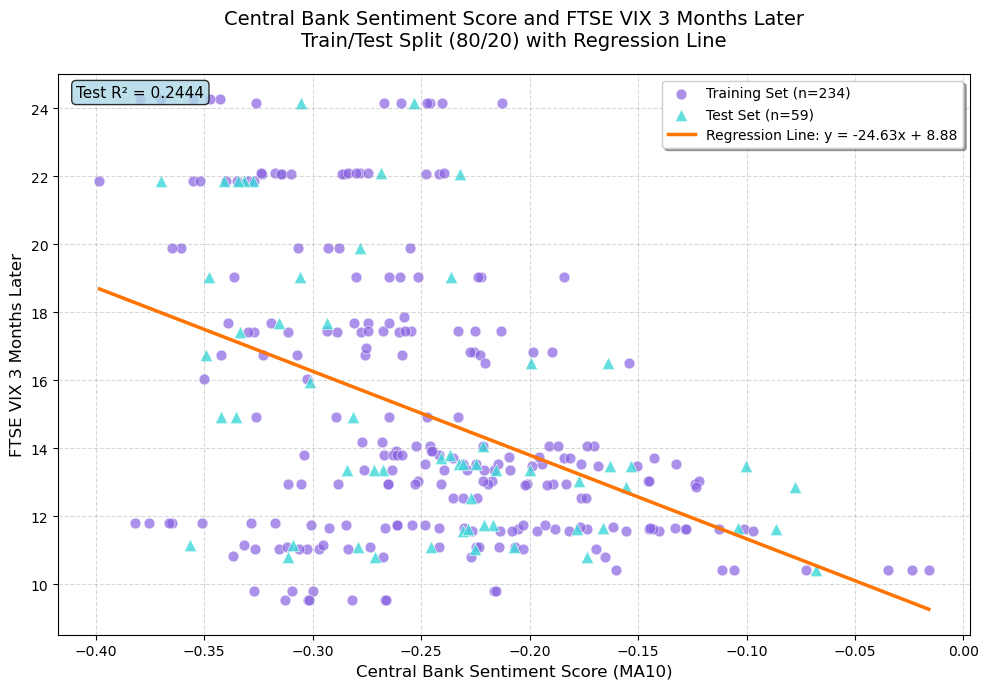

In [39]:
# Recreate the train/test split to match your regression function
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Original variables
x_full = monthly['central_bank_ma10'].values
y_full = monthly['ftse_vix_3m_forward'].values

# Create temporary dataframe and drop NaN values (matching your function logic)
temp_df = pd.DataFrame({'X': x_full, 'y': y_full}).dropna()
X = temp_df['X'].values.reshape(-1, 1)
y = temp_df['y'].values

# Perform the same train/test split as your function (80/20 split, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Flatten X arrays for plotting (they were reshaped for sklearn)
x_train = X_train.flatten()
x_test = X_test.flatten()

# Your pre-calculated regression parameters
slope = -24.629941      
intercept = 8.877629  

# Create the figure and axes
plt.figure(figsize=(10, 7))

# Create scatter plots with different symbols and colors
plt.scatter(x_train, y_train, 
           color='#8863E1', 
           marker='o',           # Circle marker for train set
           alpha=0.7, 
           s=60,                 # Size of markers
           label=f'Training Set (n={len(x_train)})',
           edgecolors='white',   # White edge for better visibility
           linewidth=0.5)

plt.scatter(x_test, y_test, 
           color='#3CD7D9', 
           marker='^',           # Triangle marker for test set
           alpha=0.8, 
           s=80,                 # Slightly larger for visibility
           label=f'Test Set (n={len(x_test)})',
           edgecolors='white',   # White edge for better visibility
           linewidth=0.5)

# Create the regression line using your slope and intercept
x_combined = np.concatenate([x_train, x_test])  # Combine all x values for line range
x_line = np.array([min(x_combined), max(x_combined)])
y_line = slope * x_line + intercept

# Plot the regression line
plt.plot(x_line, y_line, 
         color='#FF7300',        # Different color for regression line
         linewidth=2.5, 
         linestyle='-',
         label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and title
plt.xlabel('Central Bank Sentiment Score (MA10)', fontsize=12)
plt.ylabel('FTSE VIX 3 Months Later', fontsize=12)
plt.title('Central Bank Sentiment Score and FTSE VIX 3 Months Later\nTrain/Test Split (80/20) with Regression Line', 
          fontsize=14, pad=20)

# Customize grid and legend
plt.grid(True, linestyle='--', alpha=0.3, color='gray')
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)

# Calculate R-squared on test set to match your regression function
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit the model on training data and calculate R² on test set
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

# Add R-squared value as text in upper left corner
plt.text(0.02, 0.98, f'Test R² = {test_r2:.4f}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Show the plot
plt.tight_layout()

# Save the figure as a PNG file with specified DPI (resolution)
plt.savefig('central_bank_ftse_vix_train_test.png', 
            dpi=300,              # Resolution (dots per inch)
            bbox_inches='tight',  # Trim extra white space around the figure
            transparent=False,    # Set to True for transparent background
            facecolor='white')    # Background color if not transparent

# Display the plot on screen
plt.show()

In [40]:
# Reset df_clean dataframe
df_clean = monthly.dropna(subset=['ftse_vix_3m_forward'])

Predicted y values (head and tail):
[17.47861139 15.48952535 17.13716868 16.54584251 14.92598816]
...
[14.33594687 15.55501648 10.54866142 11.43769369 16.10368915] 

Mean Absolute Error: 2.672493030271861
Mean Squared Error: 11.62099943708725
Root Mean Squared Error: 3.4089587027547354
R-squared for training set:  17.339462918211858
R-squared for test set:  24.439737883528267 

                             OLS Regression Results                            
Dep. Variable:     ftse_vix_3m_forward   R-squared:                       0.173
Model:                             OLS   Adj. R-squared:                  0.170
Method:                  Least Squares   F-statistic:                     48.67
Date:                 Sat, 31 May 2025   Prob (F-statistic):           3.14e-11
Time:                         01:18:23   Log-Likelihood:                -640.56
No. Observations:                  234   AIC:                             1285.
Df Residuals:                      232   BIC:              

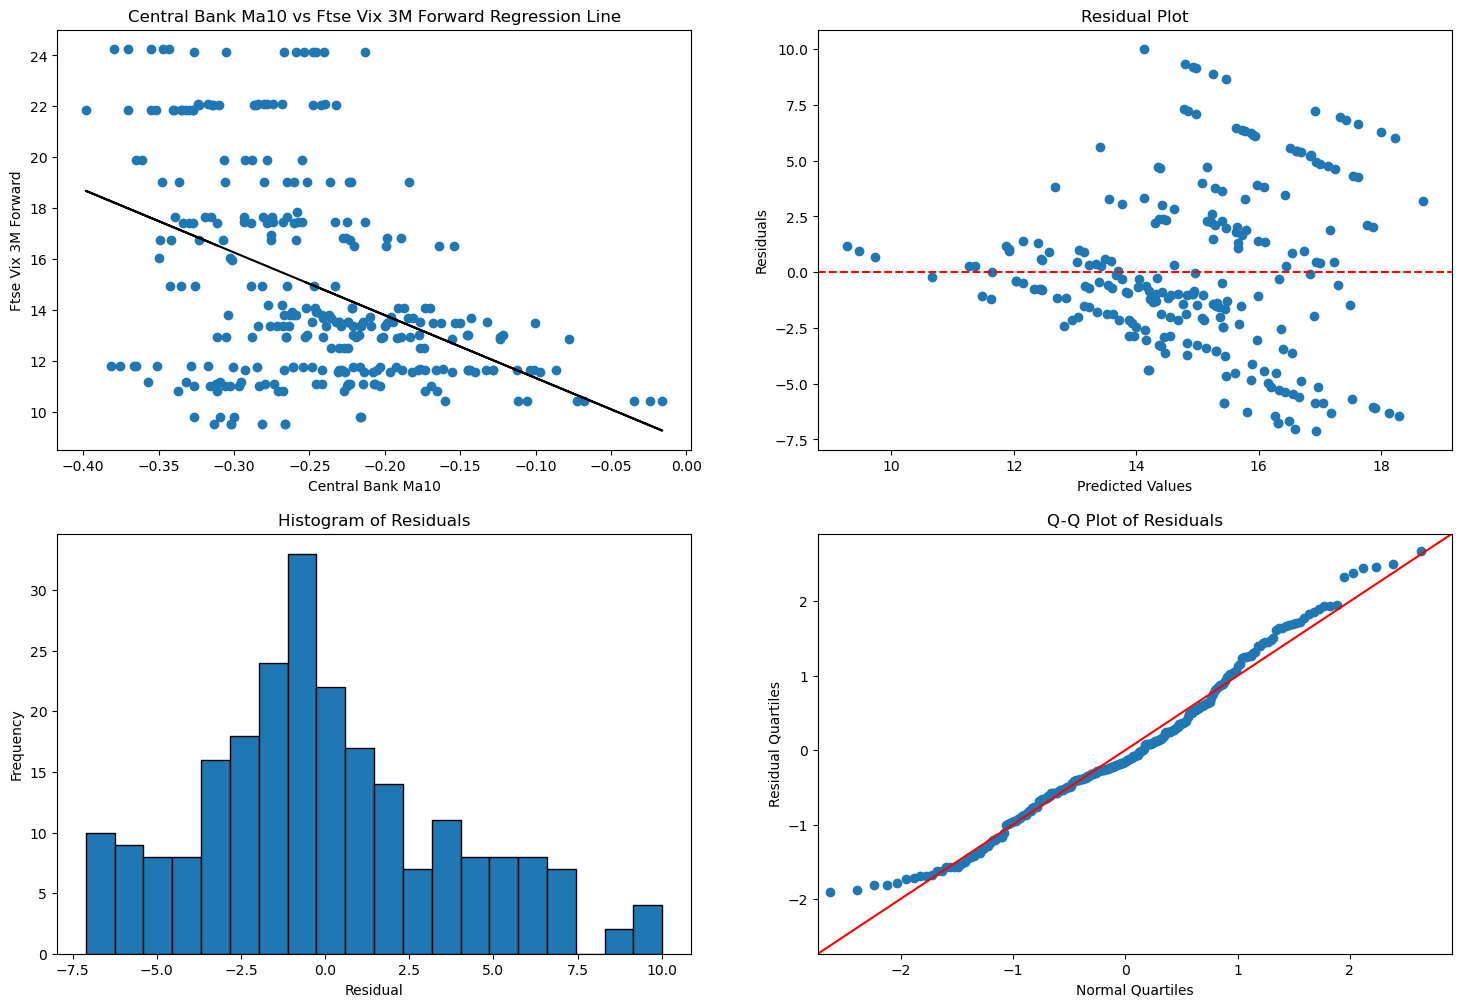

In [41]:
# Select x variables
X = ['central_bank_ma10']

# Run multiple linear regression function
lin_reg(df_clean, X, 'ftse_vix_3m_forward')

**The higher R-squared value for the test set vs the train set is surprising; this might specific to this particular test set. Let's run the regression again with different random seeds.**

In [42]:
# Identify sentiment columns
sentiment_cols = ['central_bank_ma10']

# Identify economic columns
economic_cols = ['ftse_vix_3m_forward']

analyze_simple_sentiment_economic_impact(df_clean, sentiment_cols=sentiment_cols, economic_cols=economic_cols, test_size=0.2, random_state=24)

,Sentiment Metric,Economic Indicator,R-squared (Test),Slope,Intercept,Sample Size
0,central_bank_ma10,ftse_vix_3m_forward,0.191541,-24.742236,8.897472,293


In [43]:
# Identify sentiment columns
sentiment_cols = ['central_bank_ma10']

# Identify economic columns
economic_cols = ['ftse_vix_3m_forward']

analyze_simple_sentiment_economic_impact(df_clean, sentiment_cols=sentiment_cols, economic_cols=economic_cols, test_size=0.2, random_state=48)

,Sentiment Metric,Economic Indicator,R-squared (Test),Slope,Intercept,Sample Size
0,central_bank_ma10,ftse_vix_3m_forward,0.192673,-25.364947,8.837082,293


In [44]:
# Identify sentiment columns
sentiment_cols = ['central_bank_ma10']

# Identify economic columns
economic_cols = ['ftse_vix_3m_forward']

analyze_simple_sentiment_economic_impact(df_clean, sentiment_cols=sentiment_cols, economic_cols=economic_cols, test_size=0.2, random_state=72)

,Sentiment Metric,Economic Indicator,R-squared (Test),Slope,Intercept,Sample Size
0,central_bank_ma10,ftse_vix_3m_forward,0.275296,-24.87056,8.852673,293


In [45]:
# Identify sentiment columns
sentiment_cols = ['central_bank_ma10']

# Identify economic columns
economic_cols = ['ftse_vix_3m_forward']

analyze_simple_sentiment_economic_impact(df_clean, sentiment_cols=sentiment_cols, economic_cols=economic_cols, test_size=0.2, random_state=96)

,Sentiment Metric,Economic Indicator,R-squared (Test),Slope,Intercept,Sample Size
0,central_bank_ma10,ftse_vix_3m_forward,-0.089604,-28.09398,8.331401,293


**The R-squared values have vary widely, depending on the randomised test set. The sample size of speeches with FTSE VIX values is probably too small to draw meaningful conclusions.**

**The residuals plot looks fanned, so let's try a log transformation of the dependent variable.**

#### Log Transformation of Dependent Variable

In [46]:
# Log transform 'ftse_vix_3m_forward'
df_clean['log_ftse_vix_3m_forward'] = np.log(df_clean.ftse_vix_3m_forward)
print(df_clean.head())

        date              custom_ref     reference  \
0 2015-01-20  UK_2015-01-20_cunliffe  r150120a_BOE   
1 2015-01-22    UK_2015-01-22_fisher  r150122b_BOE   
2 2015-01-22     UK_2015-01-22_miles  r150122a_BOE   
3 2015-01-23    UK_2015-01-23_gracie  r150123a_BOE   
4 2015-01-26    UK_2015-01-26_forbes  r150126a_BOE   

                                               title    author  is_gov  \
0  Financial stability, the Single Market and Cap...  cunliffe     0.0   
1  Regulation and the future of the insurance ind...    fisher     0.0   
2                       What can monetary policy do?     miles     0.0   
3  Cyber resilience: a financial stability perspe...    gracie     0.0   
4                          Risks around the forecast    forbes     0.0   

   finbert_pos  finbert_neg  finbert_neu finbert_sentiment  ...  \
0     0.068536     0.049960     0.881504           neutral  ...   
1     0.153929     0.013933     0.832138           neutral  ...   
2     0.030195     0.813499  

Predicted y values (head and tail):
[2.82425098 2.70279143 2.80340146 2.76729331 2.66838016]
...
[2.63235047 2.70679051 2.40108748 2.45537445 2.74029411] 

Mean Absolute Error: 0.16680906185996966
Mean Squared Error: 0.04501250167831313
Root Mean Squared Error: 0.2121614990480439
R-squared for training set:  16.293050092935236
R-squared for test set:  24.489402851565078 

                               OLS Regression Results                              
Dep. Variable:     log_ftse_vix_3m_forward   R-squared:                       0.163
Model:                                 OLS   Adj. R-squared:                  0.159
Method:                      Least Squares   F-statistic:                     45.16
Date:                     Sat, 31 May 2025   Prob (F-statistic):           1.39e-10
Time:                             01:18:23   Log-Likelihood:                 4.9183
No. Observations:                      234   AIC:                            -5.837
Df Residuals:                        

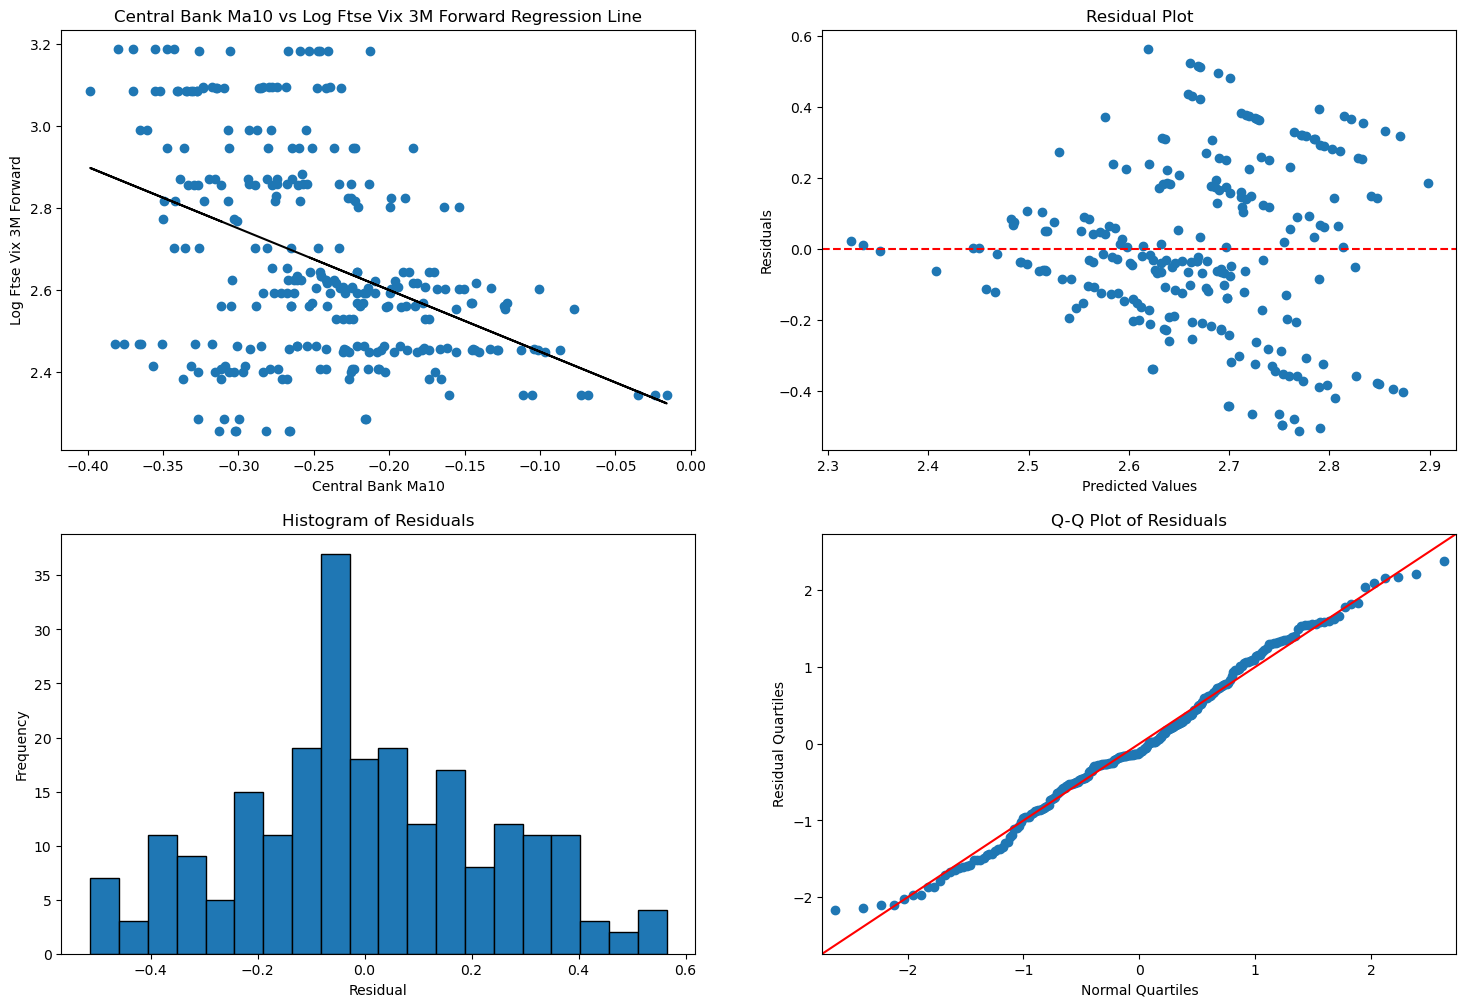

In [47]:
# Select x variables
X = ['central_bank_ma10']

# Run multiple linear regression function
lin_reg(df_clean, X, 'log_ftse_vix_3m_forward')

**The log transformation of the dependent variable didn't make much of a difference. Trying a reciprocal transformation of the independent variable.**

#### Reciprocal Transformation of Independent Variable

In [48]:
# Try reciprocal transformation of central_bank
manual_reciprocal_transform(df_clean, 'central_bank_ma10')

Original central_bank_ma10 range: [-0.3982, -0.0160]
Added constant 0.3991979780604084 to handle non-positive values
Reciprocal range: [2.6095, 1000.0000]


,date,custom_ref,reference,title,author,is_gov,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,...,dominant_topic_name_Credit & Housing Markets,dominant_topic_name_Currency & Audit,dominant_topic_name_Financial Stability & Governance,dominant_topic_name_Forecasting & Uncertainty Modelling,dominant_topic_name_Inflation & Monetary Policy,dominant_topic_name_Labour Markets & Productivity,dominant_topic_name_Liquidity & Asset Markets,log_ftse_vix_3m_forward,x_reciprocal,x_neg_reciprocal
0,2015-01-20,UK_2015-01-20_cunliffe,r150120a_BOE,"Financial stability, the Single Market and Cap...",cunliffe,0.0,0.068536,0.049960,0.881504,neutral,...,False,False,True,False,False,False,False,2.871868,16.546804,-16.546804
1,2015-01-22,UK_2015-01-22_fisher,r150122b_BOE,Regulation and the future of the insurance ind...,fisher,0.0,0.153929,0.013933,0.832138,neutral,...,False,False,False,False,False,False,False,2.871868,8.024451,-8.024451
2,2015-01-22,UK_2015-01-22_miles,r150122a_BOE,What can monetary policy do?,miles,0.0,0.030195,0.813499,0.156306,negative,...,False,False,False,False,True,False,False,2.871868,8.444907,-8.444907
3,2015-01-23,UK_2015-01-23_gracie,r150123a_BOE,Cyber resilience: a financial stability perspe...,gracie,0.0,0.047739,0.202964,0.749298,neutral,...,False,False,True,False,False,False,False,2.871868,7.432839,-7.432839
4,2015-01-26,UK_2015-01-26_forbes,r150126a_BOE,Risks around the forecast,forbes,0.0,0.040680,0.041249,0.918071,neutral,...,False,False,False,True,False,False,False,2.871868,12.515647,-12.515647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2019-03-11,UK_2019-03-11_haskel,r190311a_BOE,Will UK investment bounce back?,haskel,0.0,0.070960,0.448360,0.480680,neutral,...,False,False,False,False,False,True,False,2.400619,10.759011,-10.759011
289,2019-03-19,UK_2019-03-19_sharp,r190319a_BOE,Central bank independence as a prerequisite fo...,sharp,0.0,0.173910,0.016559,0.809532,neutral,...,False,False,True,False,False,False,False,2.400619,10.356957,-10.356957
290,2019-03-21,UK_2019-03-21_Carney,r190321a_BOE,A new horizon,Mark Carney,1.0,0.327676,0.015098,0.657226,neutral,...,False,False,False,False,False,False,False,2.400619,11.956556,-11.956556
291,2019-03-28,UK_2019-03-28_kashyap,r190328a_BOE,My reflections on the FPC's strategy,kashyap,0.0,0.111277,0.017356,0.871367,neutral,...,True,False,False,False,False,False,False,2.400619,9.781264,-9.781264


Predicted y values (head and tail):
[15.00580248 14.89681678 14.96749421 14.92974695 14.88676957]
...
[14.8790243  14.89821722 14.85597469 14.859229   14.91271474] 

Mean Absolute Error: 3.2335794860683347
Mean Squared Error: 15.211589656201365
Root Mean Squared Error: 3.9002037967523395
R-squared for training set:  1.946754723567512
R-squared for test set:  1.0935584453590663 

                             OLS Regression Results                            
Dep. Variable:     ftse_vix_3m_forward   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.015
Method:                  Least Squares   F-statistic:                     4.606
Date:                 Sat, 31 May 2025   Prob (F-statistic):             0.0329
Time:                         01:18:24   Log-Likelihood:                -660.54
No. Observations:                  234   AIC:                             1325.
Df Residuals:                      232   BIC:             

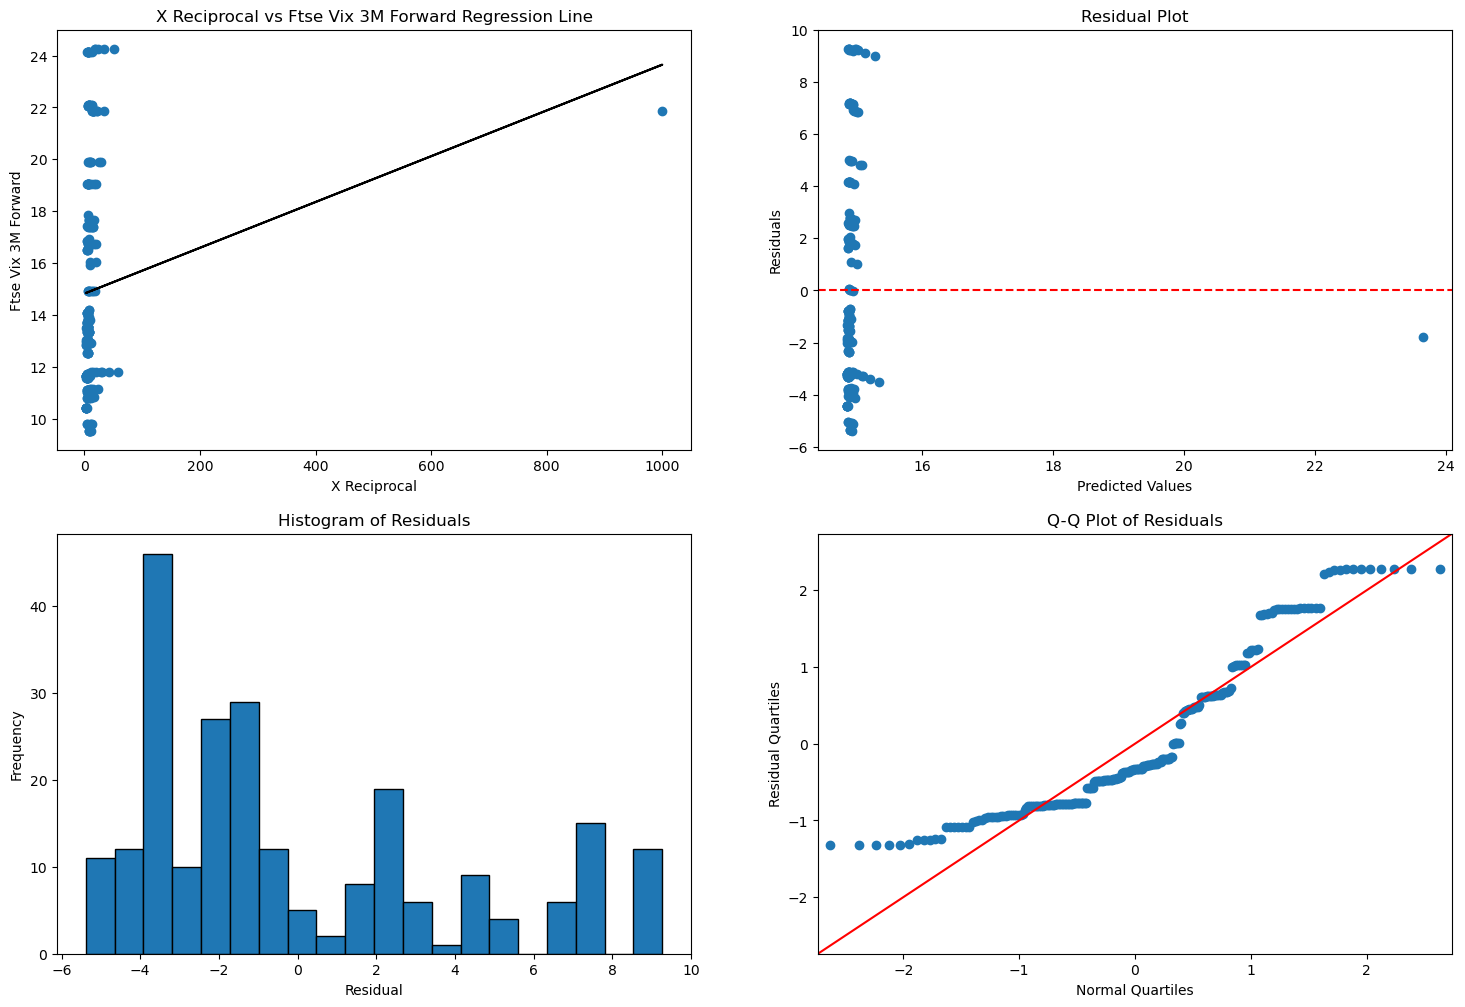

In [49]:
# Select x variables
X = ['x_reciprocal']

# Run linear regression function
lin_reg(df_clean, X, 'ftse_vix_3m_forward')

**This is a much worse result. Trying a polynomial regression instead.**

### Polynomial Regression

Data preprocessing:
  - Initial rows: 664
  - Rows with missing values dropped: 371
  - Final rows used: 293

Polynomial Regression Results (degree=2):
  Training R²:   0.1740
  Test R²:       0.2501
  Training RMSE: 3.7363
  Test RMSE:     3.3961
  Training MAE:  2.9314
  Test MAE:      2.6391



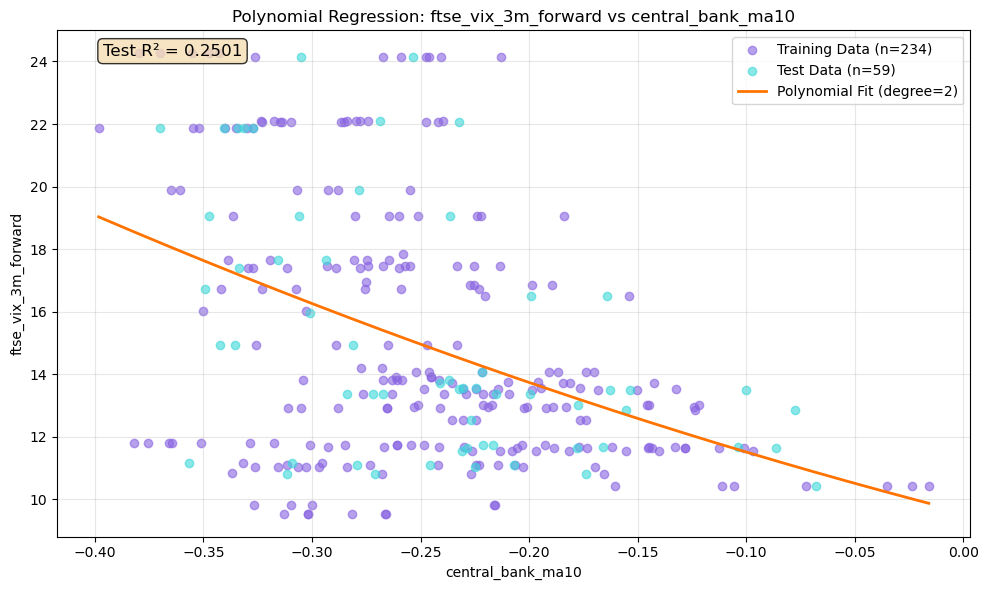

Test R²: 0.25006805379979413


In [50]:
# Polynomial Regression
results = polynomial_regression(
    df=monthly, 
    feature_col='central_bank_ma10', 
    target_col='ftse_vix_3m_forward',
    degree=2  # for cubic polynomial
)

# Print results
print(f"Test R²: {results['metrics']['test_r2']}")

**This is a very slight improvement over the simple linear regression.**

### Non-Linear Least Squares Regression

Data split: 234 training, 59 testing samples
Fitting Non-Linear Models with Train/Test Split:
Exponential Decay:
  Train R² = 0.1740, Test R² = 0.2500
  Train RMSE = 3.7363, Test RMSE = 3.3962
  Overfitting check: -0.0760 (lower is better)
  Parameters: [14.92754021  1.23712838 -5.37507463]

Simple Exponential:
  Train R² = 0.1739, Test R² = 0.2516
  Train RMSE = 3.7365, Test RMSE = 3.3927
  Overfitting check: -0.0777 (lower is better)
  Parameters: [9.79300508 1.68860147]

Power Decay: Failed to converge (Optimal parameters not found: Number of calls to function has reached maxfev = 5000.)

Hyperbolic:
  Train R² = -0.0000, Test R² = -0.0003
  Train RMSE = 4.1111, Test RMSE = 3.9223
  Overfitting check: 0.0003 (lower is better)
  Parameters: [-91959913.37552753  -6153715.16022397]



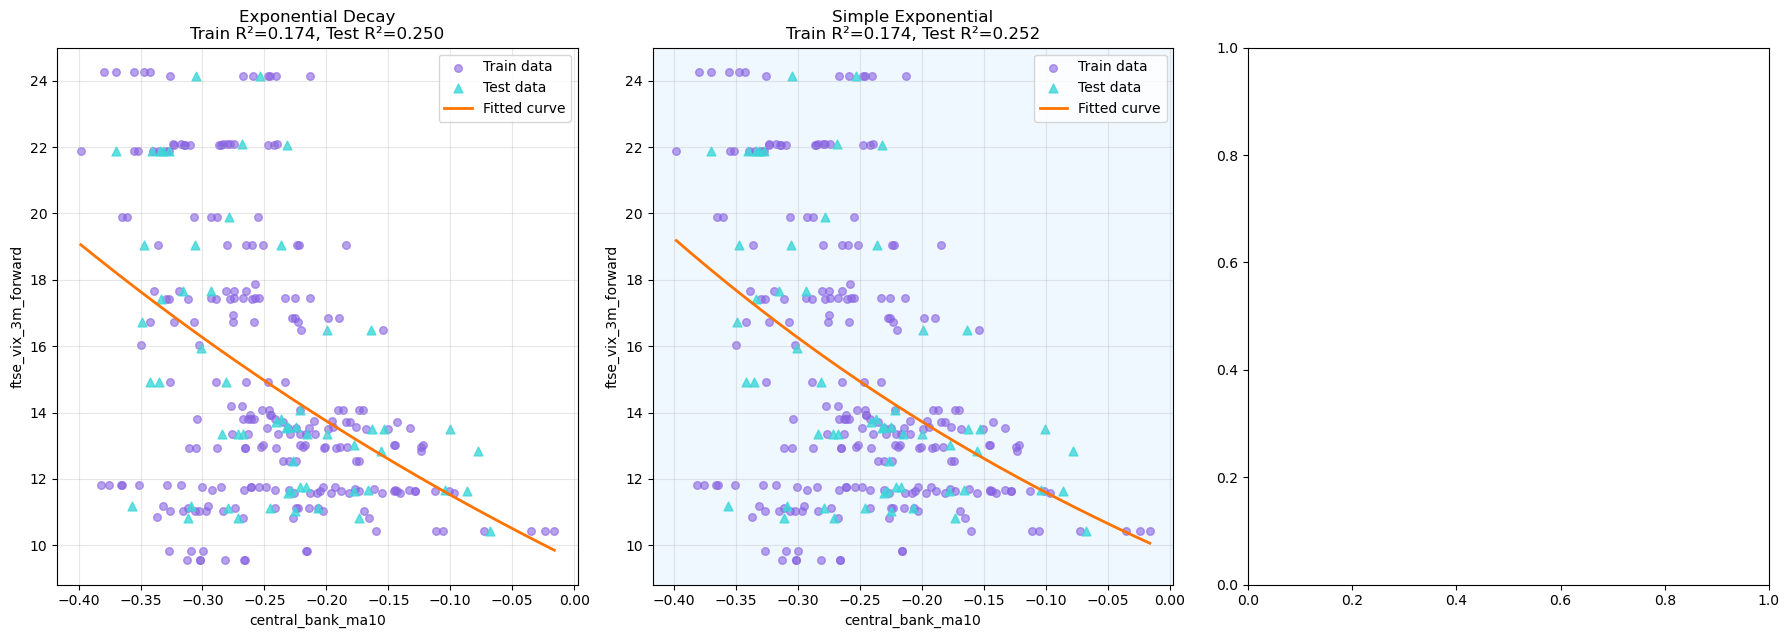

Best model (by test R²): Simple Exponential
Test R² = 0.2516
Overfitting gap = -0.0777


In [51]:
# Compare multiple models with 80/20 split:
results = fit_nonlinear_models(df_clean, 'central_bank_ma10', 'ftse_vix_3m_forward')

**The simple exponential model is once again just a slight improvement. Time for multiple linear regression.**

### Multiple Linear Regression with Additional Speech Features

**I'm selecting central bank sentiment score and additional speech features: whether the speaker a governor, the length of the speech in tokens, and dummy variables for speech topic.**

In [52]:
# Identify sentiment columns

sentiment_cols = ['central_bank_ma10']

# Identify all additional speech-related features 

speech_cols = ['is_gov', 'length', 'dominant_topic_name_Credit & Housing Markets',
                 'dominant_topic_name_Currency & Audit', 'dominant_topic_name_Financial Stability & Governance',
                 'dominant_topic_name_Forecasting & Uncertainty Modelling', 'dominant_topic_name_Inflation & Monetary Policy',
                 'dominant_topic_name_Labour Markets & Productivity', 'dominant_topic_name_Liquidity & Asset Markets']

# Specify only the dependent variables you want to test

dependent_vars = ['ftse_vix_3m_forward']

# Define which variables to exclude when each dependent variable is used

exclude_groups = {

    }

# Run the regression analysis
results = analyze_sentiment_with_economic_combinations(
    monthly, 
    sentiment_cols=sentiment_cols, 
    economic_cols=speech_cols,
    dependent_vars=dependent_vars,
    exclude_groups=exclude_groups
    )

print(results)

Processing sentiment metric: central_bank_ma10
  Testing with dependent variable: ftse_vix_3m_forward
    Excluding variables: ['ftse_vix_3m_forward']
    Available features: 9 economic indicators
      Sentiment Metric   Dependent Variable  \
2    central_bank_ma10  ftse_vix_3m_forward   
10   central_bank_ma10  ftse_vix_3m_forward   
21   central_bank_ma10  ftse_vix_3m_forward   
0    central_bank_ma10  ftse_vix_3m_forward   
49   central_bank_ma10  ftse_vix_3m_forward   
..                 ...                  ...   
490  central_bank_ma10  ftse_vix_3m_forward   
509  central_bank_ma10  ftse_vix_3m_forward   
505  central_bank_ma10  ftse_vix_3m_forward   
510  central_bank_ma10  ftse_vix_3m_forward   
511  central_bank_ma10  ftse_vix_3m_forward   

                                              Features  R-squared (Test)  \
2                            central_bank_ma10, length          0.265739   
10                   central_bank_ma10, is_gov, length          0.276319   
21   centr

In [53]:
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Sentiment Metric', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
    Dependent Variable   Sentiment Metric                   Features  \
2  ftse_vix_3m_forward  central_bank_ma10  central_bank_ma10, length   

   R-squared (Test)  Adjusted R-squared (Test)  
2          0.265739                   0.239516  


**Including additional speech features yields a slightly higher R-squared but a lower adjusted R-squared so this model is not an improvement. Let's try a decision tree.**

### Decision Tree Regressor with Speech Features

In [54]:
# Define your column lists
sentiment_scores = ['central_bank_ma10']

economic_indicators = ['ftse_vix_3m_forward']

other_features = ['is_gov', 'length']

topic_columns = ['dominant_topic_name_Credit & Housing Markets',
                 'dominant_topic_name_Currency & Audit', 'dominant_topic_name_Financial Stability & Governance',
                 'dominant_topic_name_Forecasting & Uncertainty Modelling', 'dominant_topic_name_Inflation & Monetary Policy',
                 'dominant_topic_name_Labour Markets & Productivity', 'dominant_topic_name_Liquidity & Asset Markets']
    
# Run the analysis
results = run_decision_tree_analysis(
        data=monthly,
        sentiment_scores=sentiment_scores,
        economic_indicators=economic_indicators,
        other_features=other_features,
        topic_columns=topic_columns,
        visualize=True,
        handle_missing=True,
        imputation_strategy='drop'  # Options: 'mean', 'median', 'drop'
    )


===== Processing indicator: ftse_vix_3m_forward =====
Dropped 371 rows with missing values. Remaining rows: 293

Finding optimal complexity parameter (ccp_alpha) for pruning...
Optimal ccp_alpha: 0.495310 (validation MSE: 20.8207, tree depth: 3.0, nodes: 13.0)
Training decision tree with max_depth=None, ccp_alpha=0.4953095241729857

Model for ftse_vix_3m_forward with central_bank_ma10:
Mean Squared Error: 11.4006
Mean Absolute Error: 2.5618
Root Mean Squared Error: 3.3765
R-squared: 0.2587
Tree Depth: 2
Number of Nodes: 5

Feature Importances:
central_bank_ma10: 1.0000
is_gov: 0.0000
length: 0.0000
dominant_topic_name_Credit & Housing Markets: 0.0000
dominant_topic_name_Currency & Audit: 0.0000
dominant_topic_name_Financial Stability & Governance: 0.0000
dominant_topic_name_Forecasting & Uncertainty Modelling: 0.0000
dominant_topic_name_Inflation & Monetary Policy: 0.0000
dominant_topic_name_Labour Markets & Productivity: 0.0000
dominant_topic_name_Liquidity & Asset Markets: 0.0000


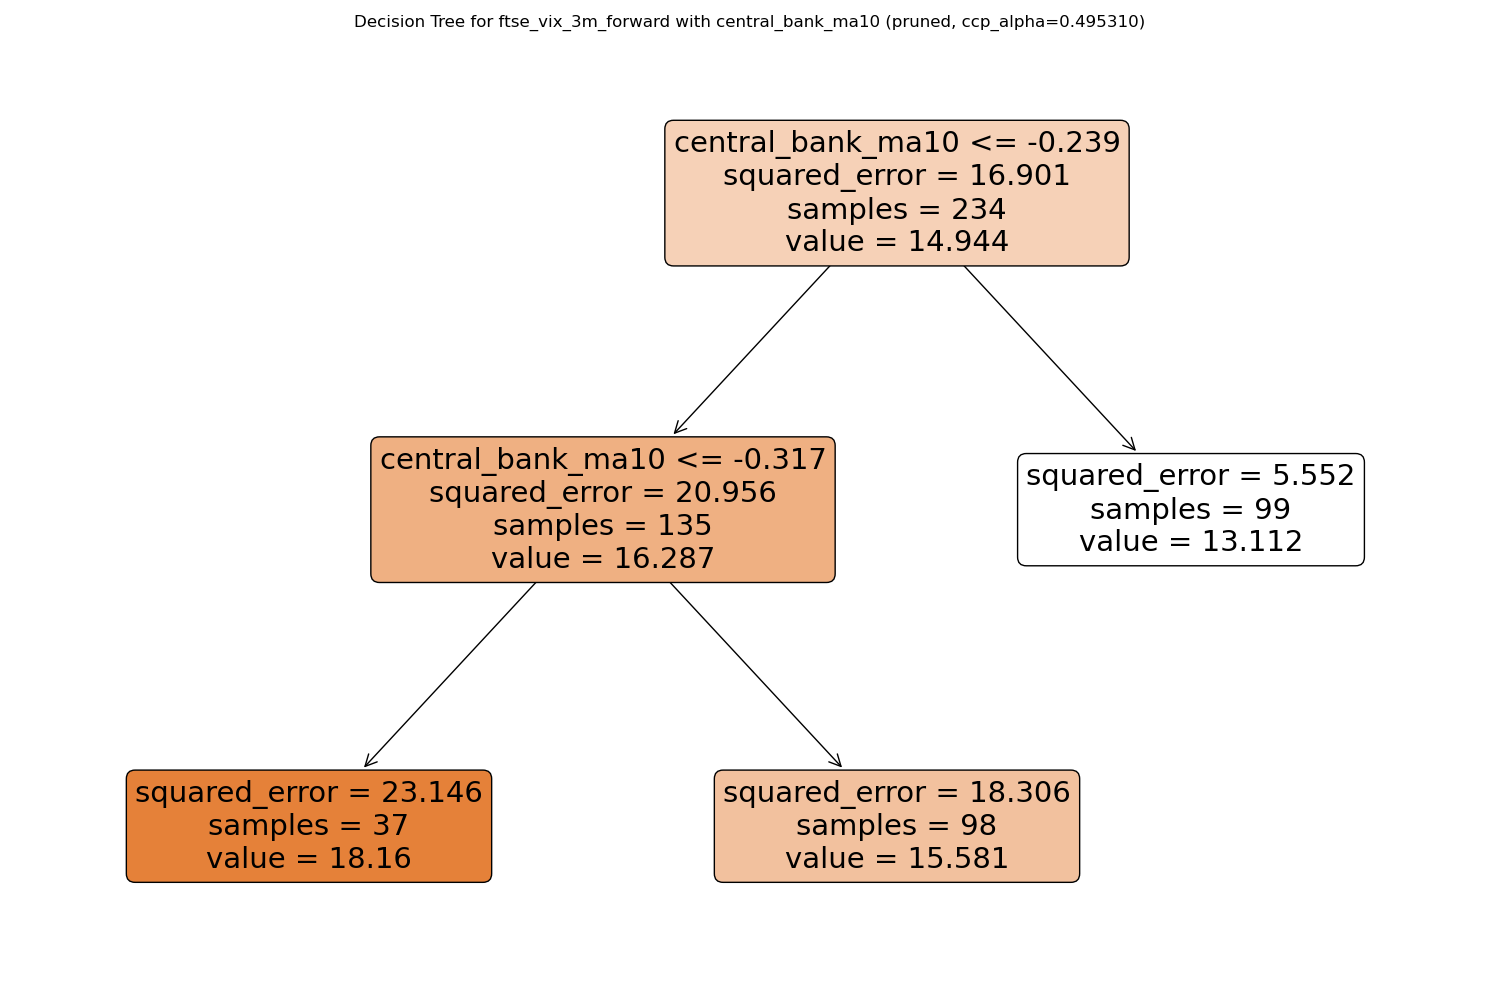

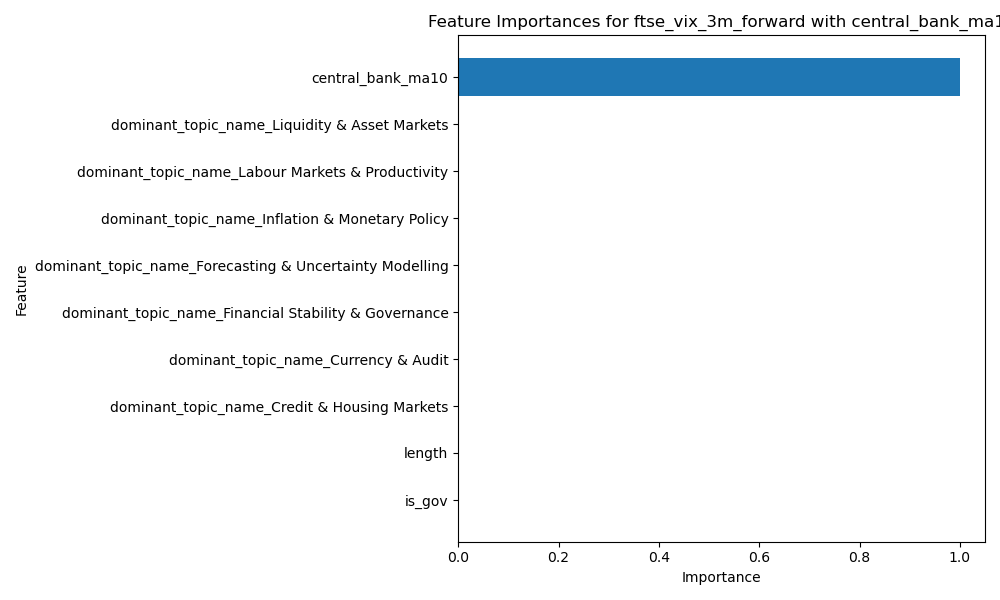

**Conclusion: including additional speech features (topic, whether or not the speaker is a governor, length) in a decision tree regressor does not improve the predictive power of speeches because the optimally pruned decision tree only relies on central bank sentiment as a feature.**

## Data Analysis: Speech Sentiment and Economic Indicators as Predictors

### MLR with Economic Indicators

**Let's start with a correlation analysis with 'ftse_vix_3m_forward'**

In [55]:
# Select only numeric columns
numeric_monthly = monthly.select_dtypes(include=[np.number])
result = numeric_monthly.corrwith(numeric_monthly['ftse_vix_3m_forward'])

In [56]:
# Exclude columns matching a pattern
exclude_pattern = ['ftse', 'change', 'forward']  # Keywords to exclude
filtered_columns = [col for col in numeric_monthly.columns 
                   if not any(pattern.lower() in col.lower() for pattern in exclude_pattern)]

result = numeric_monthly[filtered_columns].corrwith(numeric_monthly['ftse_vix_3m_forward'])
top_25 = result.reindex(result.abs().sort_values(ascending=False).index).head(25)

In [57]:
top_25

gbp_usd_m_3mo_ma          0.689161
mortgage_2yr_3mo_ma       0.685378
gbp_usd_m                 0.682357
gfk_cc_3mo_ma             0.669091
mortgage_2yr              0.653413
gfk_cc                    0.637376
infl_exp_3mo_ma          -0.629353
cpi_rate                 -0.605385
infl_exp                 -0.602797
unemp_rate                0.585413
cpi_rate_3mo_ma          -0.582973
avg_house_price_3mo_ma   -0.582472
rsi_vol                  -0.582453
avg_house_price          -0.578809
rsi_vol_3mo_ma           -0.575807
unemp_rate_3mo_ma         0.568641
speech_year              -0.535390
mortgage_svr              0.496913
mortgage_svr_3mo_ma       0.483454
hpi_yoy_3mo_ma            0.471049
hpi_yoy                   0.465818
central_bank_ma10        -0.432148
hpi_mom_3mo_ma            0.417038
bank_rate                 0.391489
bank_rate_3mo_ma          0.373655
dtype: float64

**Lots of economic indicators have higher correlations than central_bank sentiment scores, which isn't surprising. I will include the 3-month moving average versions of features that have an absolute correlation score > .5 in the model. I will run a function that performs an MLR for every single combination of economic indicators, always keeping central bank sentiment as a feature.**

In [58]:
# Identify sentiment columns

sentiment_cols = ['central_bank_ma10']

# Identify all economic columns (feature pool)

economic_cols = ['gbp_usd_m_3mo_ma', 'mortgage_2yr_3mo_ma', 'gfk_cc_3mo_ma', 'infl_exp_3mo_ma',
                 'avg_house_price_3mo_ma', 'rsi_vol_3mo_ma', 'unemp_rate_3mo_ma', 'cpi_rate_3mo_ma']

# Specify only the dependent variables you want to test

dependent_vars = ['ftse_vix_3m_forward']

# Define which variables to exclude when each dependent variable is used

exclude_groups = {

    }

# Run the regression analysis
results = analyze_sentiment_with_economic_combinations(
    monthly, 
    sentiment_cols=sentiment_cols, 
    economic_cols=economic_cols,
    dependent_vars=dependent_vars,
    exclude_groups=exclude_groups
    )

print(results)

Processing sentiment metric: central_bank_ma10
  Testing with dependent variable: ftse_vix_3m_forward
    Excluding variables: ['ftse_vix_3m_forward']
    Available features: 8 economic indicators
      Sentiment Metric   Dependent Variable  \
93   central_bank_ma10  ftse_vix_3m_forward   
165  central_bank_ma10  ftse_vix_3m_forward   
58   central_bank_ma10  ftse_vix_3m_forward   
163  central_bank_ma10  ftse_vix_3m_forward   
164  central_bank_ma10  ftse_vix_3m_forward   
..                 ...                  ...   
155  central_bank_ma10  ftse_vix_3m_forward   
7    central_bank_ma10  ftse_vix_3m_forward   
216  central_bank_ma10  ftse_vix_3m_forward   
214  central_bank_ma10  ftse_vix_3m_forward   
0    central_bank_ma10  ftse_vix_3m_forward   

                                              Features  R-squared (Test)  \
93   central_bank_ma10, gbp_usd_m_3mo_ma, mortgage_...          0.635151   
165  central_bank_ma10, gbp_usd_m_3mo_ma, mortgage_...          0.636829   
58   centr

In [59]:
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Sentiment Metric', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
     Dependent Variable   Sentiment Metric  \
93  ftse_vix_3m_forward  central_bank_ma10   

                                             Features  R-squared (Test)  \
93  central_bank_ma10, gbp_usd_m_3mo_ma, mortgage_...          0.635151   

    Adjusted R-squared (Test)  
93                   0.600731  


**The best MLR model has an adjusted R-squared value of .60, which is a big improvement over the single-feature regressions but still not ideal. Let's take a closer look at the feature importance.**

Feature Importance Analysis for: ftse_vix_3m_forward

Best Model Performance:
Features: central_bank_ma10, gbp_usd_m_3mo_ma, mortgage_2yr_3mo_ma, gfk_cc_3mo_ma, infl_exp_3mo_ma
R² (Test): 0.6352
Adj. R² (Test): 0.6007
Sample Size: 293

Standardized Feature Importance (Best Model):
1. mortgage_2yr_3mo_ma: 14.8055
2. gfk_cc_3mo_ma: 7.3320
3. infl_exp_3mo_ma: 6.7294
4. gbp_usd_m_3mo_ma: 0.8355
5. central_bank_ma10: 0.6312

Calculating Permutation Importance...

Permutation Importance (Best Model):
1. gfk_cc_3mo_ma: 1.3383 (±0.1263)
2. infl_exp_3mo_ma: 1.1971 (±0.1839)
3. mortgage_2yr_3mo_ma: 0.5620 (±0.0923)
4. gbp_usd_m_3mo_ma: 0.1280 (±0.0278)
5. central_bank_ma10: 0.0312 (±0.0173)


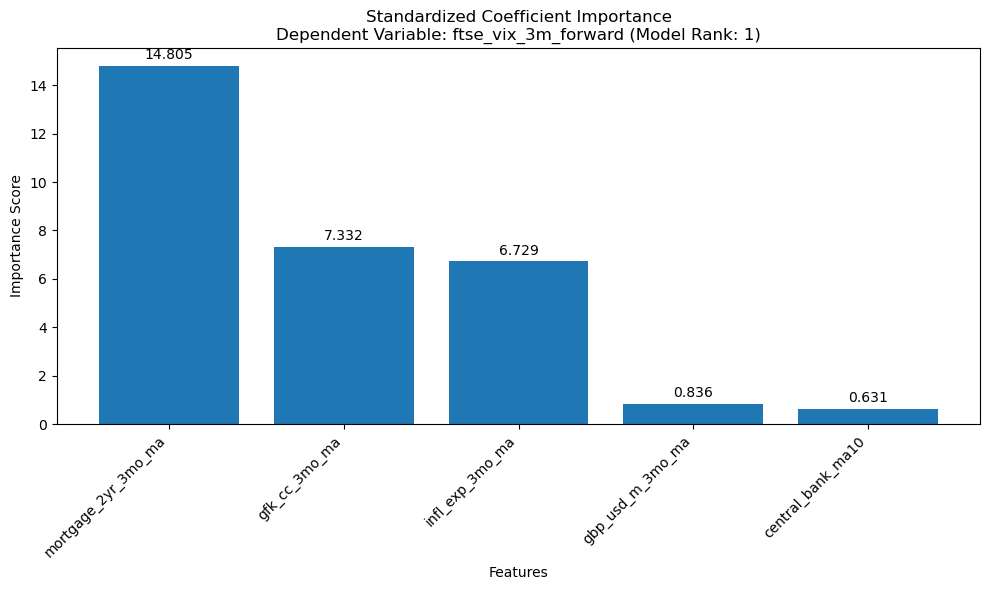


Feature Importance Rankings for ftse_vix_3m_forward (Model 1):
R² (Test): 0.6352
Adj. R² (Test): 0.6007

Feature Importance Scores:
1. mortgage_2yr_3mo_ma: 14.8055
2. gfk_cc_3mo_ma: 7.3320
3. infl_exp_3mo_ma: 6.7294
4. gbp_usd_m_3mo_ma: 0.8355
5. central_bank_ma10: 0.6312


In [60]:
importance_analysis = full_feature_importance_analysis(monthly, results, sentiment_cols, economic_cols, 'ftse_vix_3m_forward')

**The best model included 5 features and central bank sentiment had the least importance. Let's try running the multiple linear regression without central bank sentiment to see how that affects the R-squared value.**

Predicted y values (head and tail):
[17.7810033  15.3808749  19.22255697 11.52455174 12.81141461]
...
[11.75403273 11.52455174 11.98879028 12.36046872 19.14569534] 

Mean Absolute Error: 1.9264683744035171
Mean Squared Error: 5.824006859695937
Root Mean Squared Error: 2.413297921868731
R-squared for training set:  58.638804371874166
R-squared for test set:  62.13204490120393 

                             OLS Regression Results                            
Dep. Variable:     ftse_vix_3m_forward   R-squared:                       0.586
Model:                             OLS   Adj. R-squared:                  0.579
Method:                  Least Squares   F-statistic:                     81.16
Date:                 Sat, 31 May 2025   Prob (F-statistic):           8.58e-43
Time:                         01:18:28   Log-Likelihood:                -559.55
No. Observations:                  234   AIC:                             1129.
Df Residuals:                      229   BIC:               

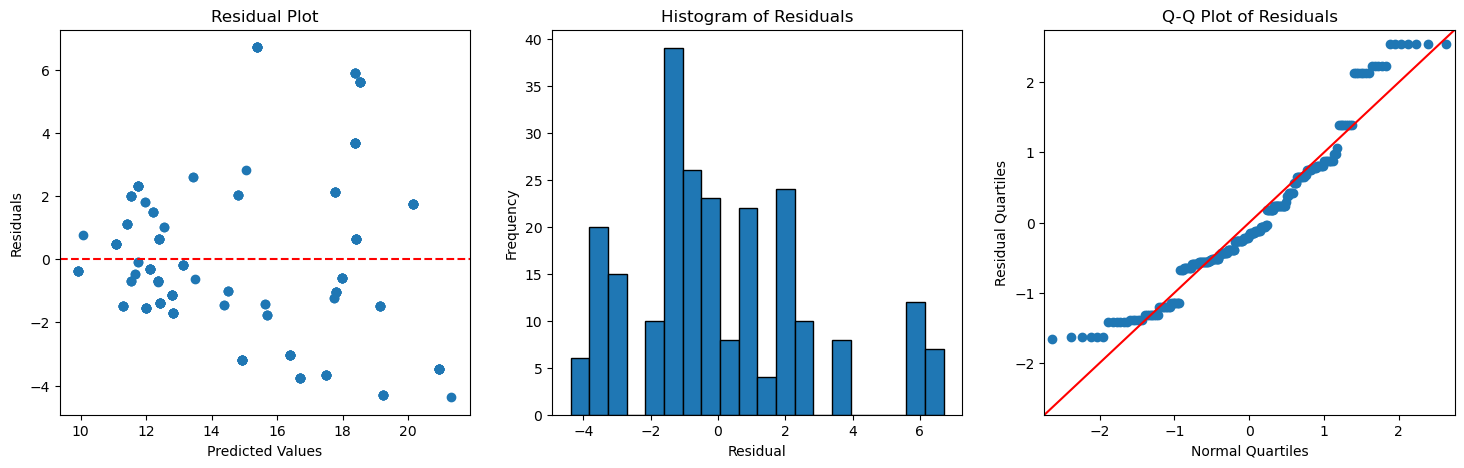

In [61]:
# Select x variables
X = ['gbp_usd_m_3mo_ma', 'mortgage_2yr_3mo_ma', 'gfk_cc_3mo_ma', 'infl_exp_3mo_ma',]

# Run linear regression function
lin_reg(df_clean, X, 'ftse_vix_3m_forward')

**The adjusted R-squared for the MLR model without central bank sentiment is .5933, which isn't much lower than that of the MLR that includes sentiment, which suggests that sentiment only makes a modest contribution to the predictive power of the model in this instance.**

### Decision Tree Regressor Including Economic Indicators

In [62]:
# Define your column lists
sentiment_scores = ['central_bank_ma10']

economic_indicators = ['ftse_vix_3m_forward']

other_features = ['gbp_usd_m_3mo_ma', 'mortgage_2yr_3mo_ma', 'gfk_cc_3mo_ma', 'infl_exp_3mo_ma']

topic_columns = []
    
# Run the analysis
results = run_decision_tree_analysis(
        data=monthly,
        sentiment_scores=sentiment_scores,
        economic_indicators=economic_indicators,
        other_features=other_features,
        topic_columns=topic_columns,
        visualize=True,
        handle_missing=True,
        imputation_strategy='drop'  # Options: 'mean', 'median', 'drop'
    )


===== Processing indicator: ftse_vix_3m_forward =====
Dropped 371 rows with missing values. Remaining rows: 293

Finding optimal complexity parameter (ccp_alpha) for pruning...
Optimal ccp_alpha: 0.000179 (validation MSE: 0.0072, tree depth: 9.0, nodes: 91.0)
Training decision tree with max_depth=None, ccp_alpha=0.00017948717948585024

Model for ftse_vix_3m_forward with central_bank_ma10:
Mean Squared Error: 0.1557
Mean Absolute Error: 0.0534
Root Mean Squared Error: 0.3946
R-squared: 0.9899
Tree Depth: 11
Number of Nodes: 93

Feature Importances:
mortgage_2yr_3mo_ma: 0.6950
infl_exp_3mo_ma: 0.1737
gfk_cc_3mo_ma: 0.0816
gbp_usd_m_3mo_ma: 0.0467
central_bank_ma10: 0.0030


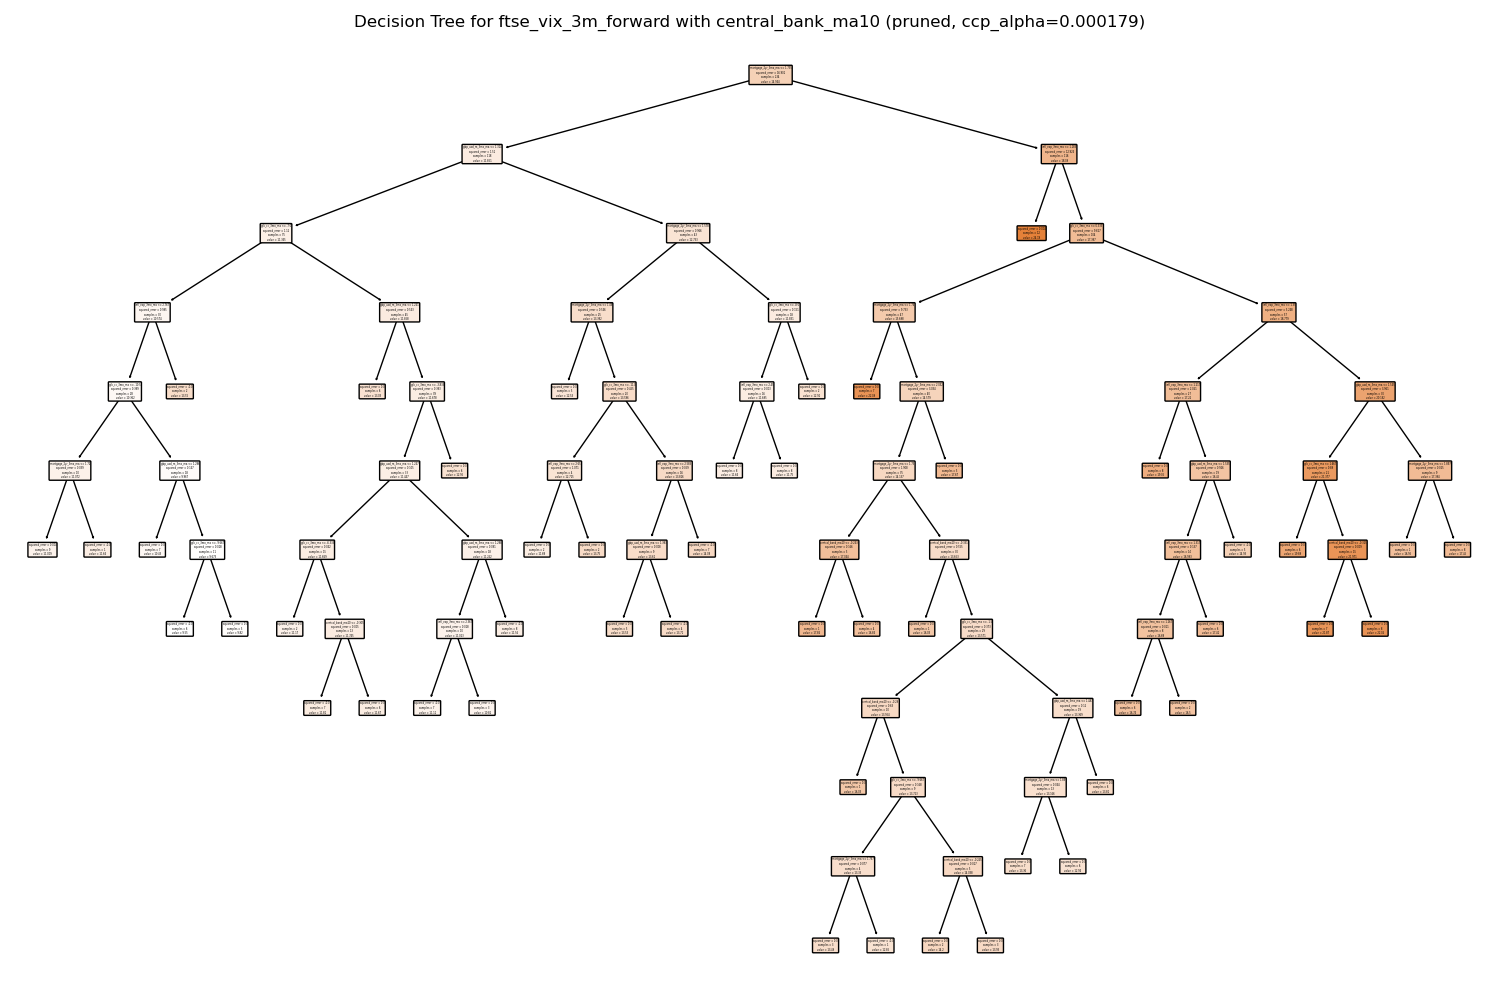

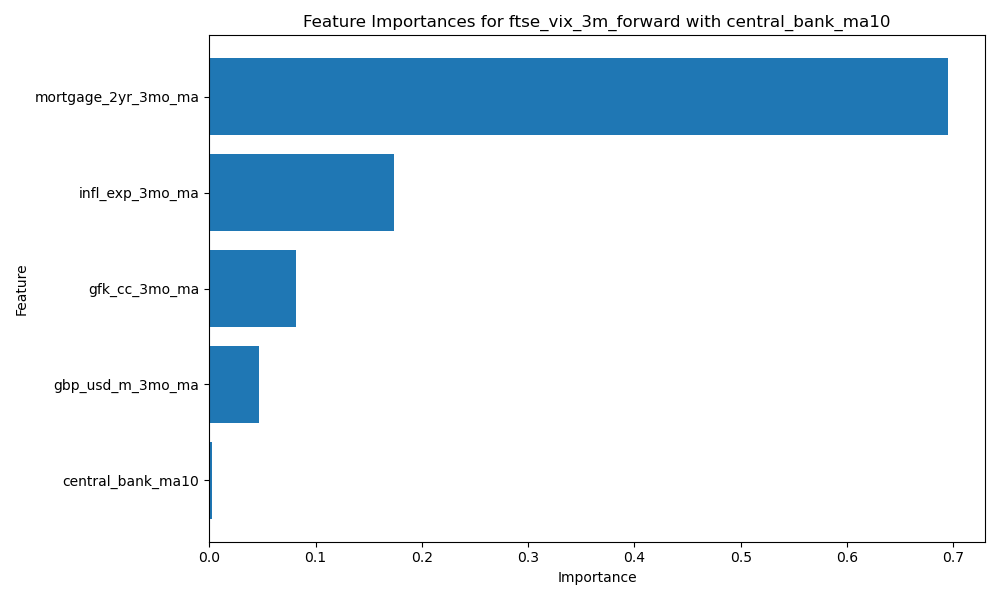

**Conclusion: the decision tree regressor is the best fitting model to predict FTSE VIX, but central bank speech sentiment is by far the least important feature in the model.**

### MLR with CPI as a Target

**Let's start with a correlation analysis to narrow down the number of speech sentiment and economic indicator features to include in the MLR predictive models.** 

In [63]:
    # Correlation analysis for multiple targets
    results = multi_target_correlation(
        df=monthly,
        targets=['cpi_rate_1m_forward', 'cpi_rate_2m_forward', 'cpi_rate_3m_forward'],
        include_patterns={
            'cpi_rate_1m_forward': ['ma'],
            'cpi_rate_2m_forward': ['ma'],
            'cpi_rate_3m_forward': ['ma'],   
        },
        
        exclude_patterns={
            'cpi_rate_1m_forward': ['cpi'],
            'cpi_rate_2m_forward': ['cpi'],
            'cpi_rate_3m_forward': ['cpi'],  
        },
        top_n=15
    )

In [64]:
results

{'cpi_rate_1m_forward': infl_exp_3mo_ma                  0.927900
 ftse_vix_3mo_ma                 -0.807680
 gfk_cc_3mo_ma                   -0.789270
 avg_house_price_3mo_ma           0.717809
 wage_rate_3mo_ma                 0.645561
 unemp_rate_3mo_ma               -0.633220
 gbp_usd_m_3mo_ma                -0.590278
 rsi_3mo3m1y_3mo_ma              -0.566017
 mortgage_2yr_3mo_ma              0.533049
 ftse_all_share_monthly_3mo_ma    0.507451
 ftse100_monthly_3mo_ma           0.489941
 firms_ma10                      -0.371724
 mortgage_approvals_3mo_ma       -0.358572
 bank_rate_3mo_ma                 0.352797
 ftse250_monthly_3mo_ma           0.322078
 dtype: float64,
 'cpi_rate_2m_forward': infl_exp_3mo_ma                  0.922953
 ftse_vix_3mo_ma                 -0.790057
 gfk_cc_3mo_ma                   -0.776791
 avg_house_price_3mo_ma           0.707678
 wage_rate_3mo_ma                 0.621892
 unemp_rate_3mo_ma               -0.616063
 gbp_usd_m_3mo_ma                -

**Let's include the 3-month moving average versions of features that have an absolute correlation score > .5 in the model along with the speech sentiment that has the highest correlation, which in this case is firms.**

In [65]:
# Identify sentiment columns

sentiment_cols = ['firms_ma10']

# Identify all additional speech-related features 

economic_cols = ['infl_exp_3mo_ma', 'ftse_vix_3mo_ma', 'gfk_cc_3mo_ma',
                 'avg_house_price_3mo_ma', 'wage_rate_3mo_ma',
                 'unemp_rate_3mo_ma', 'gbp_usd_m_3mo_ma',
                 'rsi_3mo3m1y_3mo_ma', 'mortgage_2yr_3mo_ma', 'ftse_all_share_monthly_3mo_ma']

# Specify only the dependent variables you want to test

dependent_vars = ['cpi_rate_1m_forward', 'cpi_rate_2m_forward', 'cpi_rate_3m_forward']

# Define which variables to exclude when each dependent variable is used

exclude_groups = {

    }

# Run the regression analysis
results = analyze_sentiment_with_economic_combinations(
    monthly, 
    sentiment_cols=sentiment_cols, 
    economic_cols=economic_cols,
    dependent_vars=dependent_vars,
    exclude_groups=exclude_groups
    )

print(results)

Processing sentiment metric: firms_ma10
  Testing with dependent variable: cpi_rate_1m_forward
    Excluding variables: ['cpi_rate_1m_forward']
    Available features: 10 economic indicators
  Testing with dependent variable: cpi_rate_2m_forward
    Excluding variables: ['cpi_rate_2m_forward']
    Available features: 10 economic indicators
  Testing with dependent variable: cpi_rate_3m_forward
    Excluding variables: ['cpi_rate_3m_forward']
    Available features: 10 economic indicators
     Sentiment Metric   Dependent Variable  \
892        firms_ma10  cpi_rate_1m_forward   
977        firms_ma10  cpi_rate_1m_forward   
1016       firms_ma10  cpi_rate_1m_forward   
993        firms_ma10  cpi_rate_1m_forward   
992        firms_ma10  cpi_rate_1m_forward   
...               ...                  ...   
2101       firms_ma10  cpi_rate_3m_forward   
2103       firms_ma10  cpi_rate_3m_forward   
2058       firms_ma10  cpi_rate_3m_forward   
2057       firms_ma10  cpi_rate_3m_forward   
2

In [66]:
#Sort by best model for each target
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Sentiment Metric', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
       Dependent Variable Sentiment Metric  \
892   cpi_rate_1m_forward       firms_ma10   
1881  cpi_rate_2m_forward       firms_ma10   
3064  cpi_rate_3m_forward       firms_ma10   

                                               Features  R-squared (Test)  \
892   firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, ...          0.987100   
1881  firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, ...          0.981724   
3064  firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, ...          0.978190   

      Adjusted R-squared (Test)  
892                    0.985351  
1881                   0.979245  
3064                   0.974363  


In [67]:
# Save to .csv
best_models.to_csv('cpi_best_models.csv', index=False)

Feature Importance Analysis for: cpi_rate_1m_forward

Best Model Performance:
Features: firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_price_3mo_ma, wage_rate_3mo_ma, rsi_3mo3m1y_3mo_ma, mortgage_2yr_3mo_ma, ftse_all_share_monthly_3mo_ma
R² (Test): 0.9871
Adj. R² (Test): 0.9854
Sample Size: 338

Standardized Feature Importance (Best Model):
1. mortgage_2yr_3mo_ma: 1.8229
2. avg_house_price_3mo_ma: 0.9826
3. wage_rate_3mo_ma: 0.9135
4. infl_exp_3mo_ma: 0.7963
5. ftse_all_share_monthly_3mo_ma: 0.4122
6. rsi_3mo3m1y_3mo_ma: 0.3698
7. ftse_vix_3mo_ma: 0.0614
8. firms_ma10: 0.0165

Calculating Permutation Importance...

Permutation Importance (Best Model):
1. avg_house_price_3mo_ma: 0.2162 (±0.0244)
2. infl_exp_3mo_ma: 0.1932 (±0.0284)
3. ftse_all_share_monthly_3mo_ma: 0.1910 (±0.0287)
4. wage_rate_3mo_ma: 0.1566 (±0.0275)
5. mortgage_2yr_3mo_ma: 0.0929 (±0.0139)
6. rsi_3mo3m1y_3mo_ma: 0.0176 (±0.0031)
7. ftse_vix_3mo_ma: 0.0070 (±0.0014)
8. firms_ma10: 0.0010 (±0.0004)


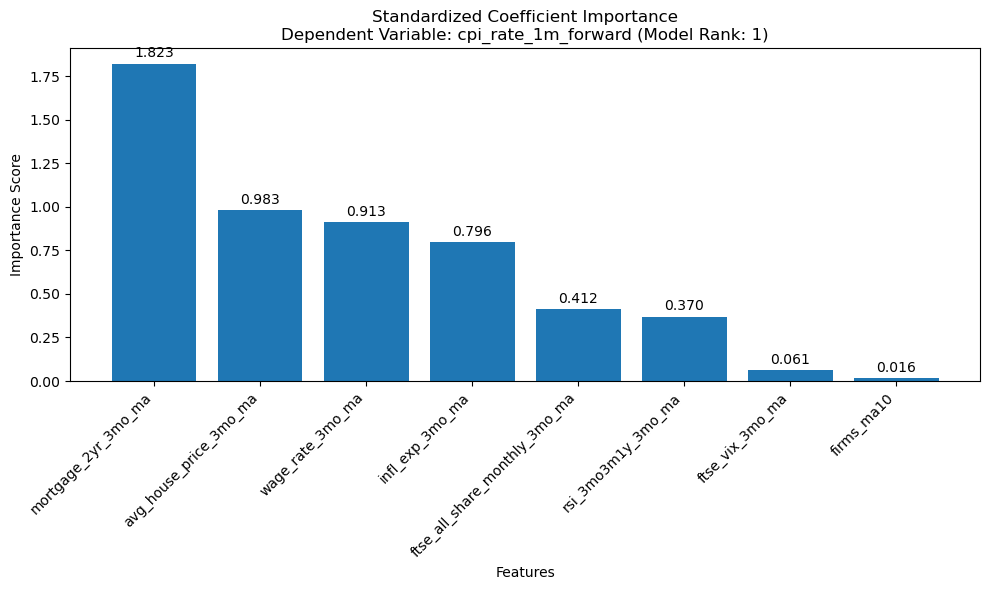


Feature Importance Rankings for cpi_rate_1m_forward (Model 1):
R² (Test): 0.9871
Adj. R² (Test): 0.9854

Feature Importance Scores:
1. mortgage_2yr_3mo_ma: 1.8229
2. avg_house_price_3mo_ma: 0.9826
3. wage_rate_3mo_ma: 0.9135
4. infl_exp_3mo_ma: 0.7963
5. ftse_all_share_monthly_3mo_ma: 0.4122
6. rsi_3mo3m1y_3mo_ma: 0.3698
7. ftse_vix_3mo_ma: 0.0614
8. firms_ma10: 0.0165


In [68]:
# Feature analysis
importance_analysis = full_feature_importance_analysis(monthly, results, sentiment_cols, economic_cols, 'cpi_rate_1m_forward')

**Try MLR without speech sentiment.**

In [69]:
# Test all combinations of economic indicators to predict CPI
results = analyze_feature_combinations(
    df=monthly,
    feature_cols=['infl_exp_3mo_ma', 'ftse_vix_3mo_ma', 'gfk_cc_3mo_ma',
                 'avg_house_price_3mo_ma', 'wage_rate_3mo_ma',
                 'unemp_rate_3mo_ma', 'gbp_usd_m_3mo_ma',
                 'rsi_3mo3m1y_3mo_ma', 'mortgage_2yr_3mo_ma', 'ftse_all_share_monthly_3mo_ma'],
    dependent_vars=['cpi_rate_1m_forward', 'cpi_rate_2m_forward', 'cpi_rate_3m_forward'],
    max_features=7
)

Processing dependent variable: cpi_rate_1m_forward
  Excluding variables: ['cpi_rate_1m_forward']
  Available features: 10 variables
  Testing 967 feature combinations
Processing dependent variable: cpi_rate_2m_forward
  Excluding variables: ['cpi_rate_2m_forward']
  Available features: 10 variables
  Testing 967 feature combinations
Processing dependent variable: cpi_rate_3m_forward
  Excluding variables: ['cpi_rate_3m_forward']
  Available features: 10 variables
  Testing 967 feature combinations


In [70]:
print(results)

       Dependent Variable                                           Features  \
891   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_pr...   
900   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, wage_rate_3m...   
890   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_pr...   
695   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, wage_rate_3m...   
870   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, gfk_cc_3mo_m...   
...                   ...                                                ...   
1982  cpi_rate_3m_forward   unemp_rate_3mo_ma, ftse_all_share_monthly_3mo_ma   
1985  cpi_rate_3m_forward    gbp_usd_m_3mo_ma, ftse_all_share_monthly_3mo_ma   
1943  cpi_rate_3m_forward                      ftse_all_share_monthly_3mo_ma   
1988  cpi_rate_3m_forward  mortgage_2yr_3mo_ma, ftse_all_share_monthly_3m...   
1942  cpi_rate_3m_forward                                mortgage_2yr_3mo_ma   

      Feature Count  R-squared (Test)  

In [71]:
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
       Dependent Variable                                           Features  \
891   cpi_rate_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_pr...   
1854  cpi_rate_2m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_pr...   
2821  cpi_rate_3m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_pr...   

      R-squared (Test)  Adjusted R-squared (Test)  
891           0.986509                   0.984935  
1854          0.981139                   0.978938  
2821          0.976233                   0.973460  


Feature Importance Analysis for: cpi_rate_1m_forward

Best Model Performance:
Features: infl_exp_3mo_ma, ftse_vix_3mo_ma, avg_house_price_3mo_ma, wage_rate_3mo_ma, rsi_3mo3m1y_3mo_ma, mortgage_2yr_3mo_ma, ftse_all_share_monthly_3mo_ma
R² (Test): 0.9865
Adj. R² (Test): 0.9849
Sample Size: 338

Standardized Feature Importance (Best Model):
1. mortgage_2yr_3mo_ma: 1.8831
2. avg_house_price_3mo_ma: 0.9533
3. wage_rate_3mo_ma: 0.8928
4. infl_exp_3mo_ma: 0.7939
5. ftse_all_share_monthly_3mo_ma: 0.3967
6. rsi_3mo3m1y_3mo_ma: 0.3906
7. ftse_vix_3mo_ma: 0.0544

Calculating Permutation Importance...

Permutation Importance (Best Model):
1. avg_house_price_3mo_ma: 0.2038 (±0.0233)
2. infl_exp_3mo_ma: 0.1924 (±0.0284)
3. ftse_all_share_monthly_3mo_ma: 0.1776 (±0.0269)
4. wage_rate_3mo_ma: 0.1494 (±0.0267)
5. mortgage_2yr_3mo_ma: 0.0997 (±0.0150)
6. rsi_3mo3m1y_3mo_ma: 0.0200 (±0.0033)
7. ftse_vix_3mo_ma: 0.0054 (±0.0011)


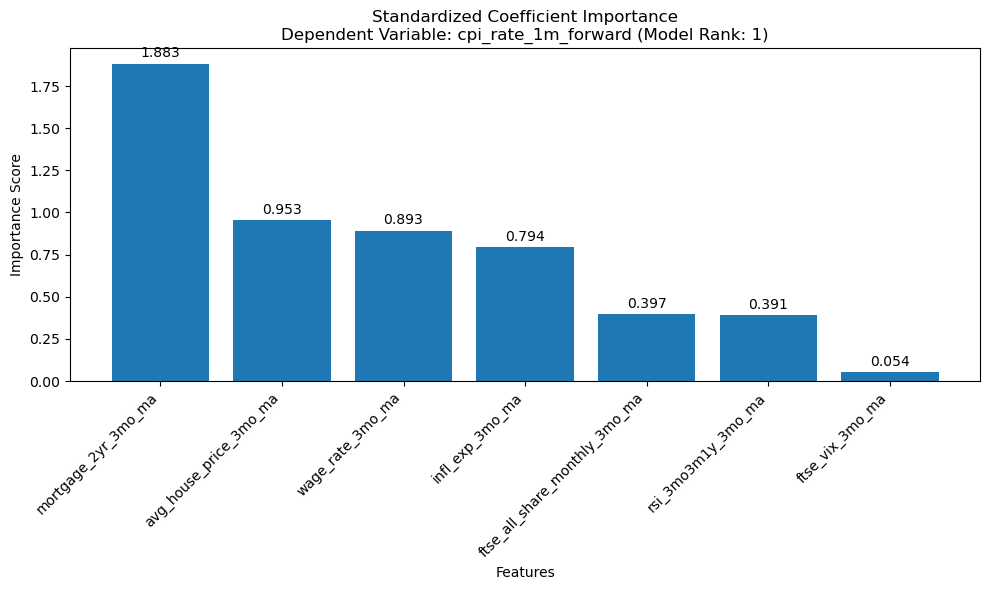


Feature Importance Rankings for cpi_rate_1m_forward (Model 1):
R² (Test): 0.9865
Adj. R² (Test): 0.9849

Feature Importance Scores:
1. mortgage_2yr_3mo_ma: 1.8831
2. avg_house_price_3mo_ma: 0.9533
3. wage_rate_3mo_ma: 0.8928
4. infl_exp_3mo_ma: 0.7939
5. ftse_all_share_monthly_3mo_ma: 0.3967
6. rsi_3mo3m1y_3mo_ma: 0.3906
7. ftse_vix_3mo_ma: 0.0544


In [72]:
importance_analysis = full_feature_importance_analysis(monthly, results, sentiment_cols, economic_cols, 'cpi_rate_1m_forward')

**Conclusion: speech sentiment (10-speech MA) hardly makes any difference in predicting inflation one month later. Economic indicators related to housing, earnings, and inflation expectations have the most predictive power.**

### MLR with GfK Consumer Confidence as a Target

**Let's start with a correlation analysis to narrow down the number of speech sentiment and economic indicator features to include in the MLR predictive models.** 

In [73]:
    # Correlation analysis for multiple targets
    results = multi_target_correlation(
        df=monthly,
        targets=['gfk_cc_1m_forward', 'gfk_cc_2m_forward', 'gfk_cc_3m_forward'],
        include_patterns={
            'gfk_cc_1m_forward': ['ma'],
            'gfk_cc_2m_forward': ['ma'],
            'gfk_cc_3m_forward': ['ma']      
        },
        
        exclude_patterns={
            'gfk_cc_1m_forward': ['gfk'],
            'gfk_cc_2m_forward': ['gfk'],
            'gfk_cc_3m_forward': ['gfk']     
        },
        top_n=15
    )

In [74]:
results

{'gfk_cc_1m_forward': infl_exp_3mo_ma                 -0.925739
 avg_house_price_3mo_ma          -0.805807
 cpi_rate_3mo_ma                 -0.778722
 gbp_usd_m_3mo_ma                 0.730518
 rsi_3mo3m1y_3mo_ma               0.660027
 unemp_rate_3mo_ma                0.622978
 ftse_vix_3mo_ma                  0.620771
 ftse250_volat_3mo_ma            -0.617832
 wage_rate_3mo_ma                -0.530955
 rsi_vol_3mo_ma                  -0.511462
 mortgage_2yr_3mo_ma             -0.494848
 bank_rate_3mo_ma                -0.354699
 ftse_all_share_volat_3mo_ma     -0.338020
 firms_ma10                       0.311787
 ftse_all_share_monthly_3mo_ma   -0.308938
 dtype: float64,
 'gfk_cc_2m_forward': infl_exp_3mo_ma                 -0.886959
 avg_house_price_3mo_ma          -0.778117
 cpi_rate_3mo_ma                 -0.751779
 gbp_usd_m_3mo_ma                 0.702259
 unemp_rate_3mo_ma                0.637979
 ftse_vix_3mo_ma                  0.624241
 rsi_3mo3m1y_3mo_ma               0.61

**Let's include the 3-month moving average versions of features that have an absolute correlation score > .5 in the model along with the speech sentiment that has the highest correlation, which in this case is firms.**

In [75]:
# Identify sentiment columns

sentiment_cols = ['firms_ma10']

# Identify all additional speech-related features 

economic_cols = ['infl_exp_3mo_ma', 'ftse_vix_3mo_ma', 'cpi_rate_3mo_ma',
                 'avg_house_price_3mo_ma', 'wage_rate_3mo_ma',
                 'unemp_rate_3mo_ma', 'gbp_usd_m_3mo_ma',
                 'rsi_3mo3m1y_3mo_ma', 'rsi_vol_3mo_ma', 'ftse250_volat_3mo_ma']

# Specify only the dependent variables you want to test

dependent_vars = ['gfk_cc_1m_forward', 'gfk_cc_2m_forward', 'gfk_cc_3m_forward']

# Define which variables to exclude when each dependent variable is used

exclude_groups = {

    }

# Run the regression analysis
results = analyze_sentiment_with_economic_combinations(
    monthly, 
    sentiment_cols=sentiment_cols, 
    economic_cols=economic_cols,
    dependent_vars=dependent_vars,
    exclude_groups=exclude_groups
    )

print(results)

Processing sentiment metric: firms_ma10
  Testing with dependent variable: gfk_cc_1m_forward
    Excluding variables: ['gfk_cc_1m_forward']
    Available features: 10 economic indicators
  Testing with dependent variable: gfk_cc_2m_forward
    Excluding variables: ['gfk_cc_2m_forward']
    Available features: 10 economic indicators
  Testing with dependent variable: gfk_cc_3m_forward
    Excluding variables: ['gfk_cc_3m_forward']
    Available features: 10 economic indicators
     Sentiment Metric Dependent Variable  \
641        firms_ma10  gfk_cc_1m_forward   
773        firms_ma10  gfk_cc_1m_forward   
857        firms_ma10  gfk_cc_1m_forward   
853        firms_ma10  gfk_cc_1m_forward   
515        firms_ma10  gfk_cc_1m_forward   
...               ...                ...   
2057       firms_ma10  gfk_cc_3m_forward   
2056       firms_ma10  gfk_cc_3m_forward   
2053       firms_ma10  gfk_cc_3m_forward   
2058       firms_ma10  gfk_cc_3m_forward   
2048       firms_ma10  gfk_cc_3m_fo

In [76]:
# Return best models
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Sentiment Metric', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
     Dependent Variable Sentiment Metric  \
641   gfk_cc_1m_forward       firms_ma10   
2821  gfk_cc_3m_forward       firms_ma10   
2021  gfk_cc_2m_forward       firms_ma10   

                                               Features  R-squared (Test)  \
641   firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, ...          0.958030   
2821  firms_ma10, ftse_vix_3mo_ma, cpi_rate_3mo_ma, ...          0.914189   
2021  firms_ma10, infl_exp_3mo_ma, cpi_rate_3mo_ma, ...          0.819937   

      Adjusted R-squared (Test)  
641                    0.953134  
2821                   0.904177  
2021                   0.806762  


In [77]:
# Save to .csv
best_models.to_csv('gfk_cc_best_models.csv', index=False)

Feature Importance Analysis for: gfk_cc_1m_forward

Best Model Performance:
Features: firms_ma10, infl_exp_3mo_ma, ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_price_3mo_ma, wage_rate_3mo_ma, rsi_vol_3mo_ma
R² (Test): 0.9580
Adj. R² (Test): 0.9531
Sample Size: 338

Standardized Feature Importance (Best Model):
1. rsi_vol_3mo_ma: 8.6496
2. cpi_rate_3mo_ma: 8.0630
3. avg_house_price_3mo_ma: 6.3712
4. wage_rate_3mo_ma: 4.7912
5. infl_exp_3mo_ma: 1.9799
6. ftse_vix_3mo_ma: 1.6813
7. firms_ma10: 0.0154

Calculating Permutation Importance...

Permutation Importance (Best Model):
1. rsi_vol_3mo_ma: 2.6494 (±0.3701)
2. cpi_rate_3mo_ma: 0.4325 (±0.0563)
3. avg_house_price_3mo_ma: 0.2214 (±0.0251)
4. ftse_vix_3mo_ma: 0.1056 (±0.0268)
5. wage_rate_3mo_ma: 0.0922 (±0.0101)
6. infl_exp_3mo_ma: 0.0519 (±0.0107)
7. firms_ma10: -0.0001 (±0.0001)


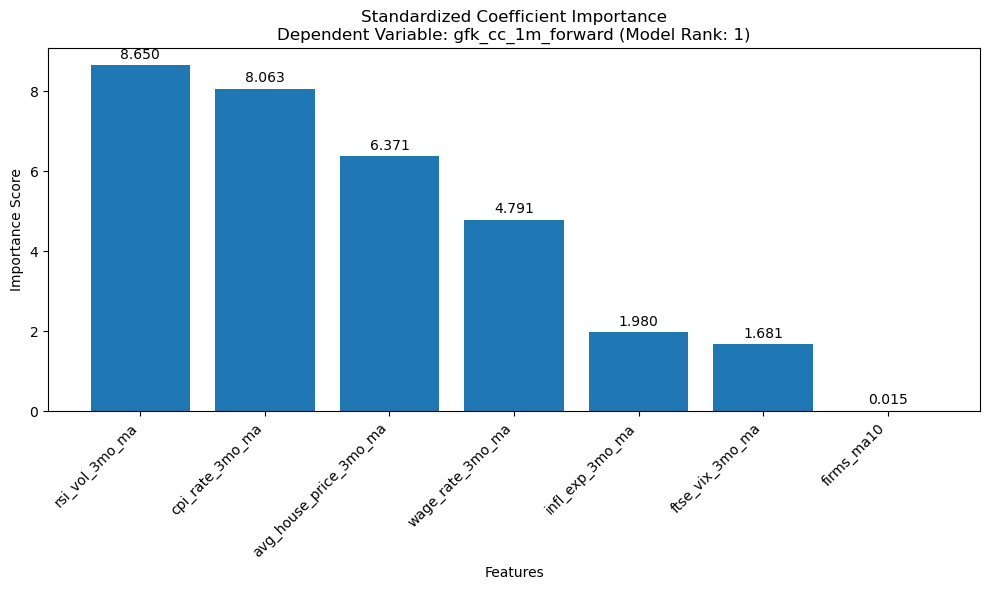


Feature Importance Rankings for gfk_cc_1m_forward (Model 1):
R² (Test): 0.9580
Adj. R² (Test): 0.9531

Feature Importance Scores:
1. rsi_vol_3mo_ma: 8.6496
2. cpi_rate_3mo_ma: 8.0630
3. avg_house_price_3mo_ma: 6.3712
4. wage_rate_3mo_ma: 4.7912
5. infl_exp_3mo_ma: 1.9799
6. ftse_vix_3mo_ma: 1.6813
7. firms_ma10: 0.0154


In [78]:
# Feature Importance
importance_analysis = full_feature_importance_analysis(monthly, results, sentiment_cols, economic_cols, 'gfk_cc_1m_forward')

**Try MLR without speech sentiment.**

In [79]:
# Test all combinations of economic indicators to predict CPI
results = analyze_feature_combinations(
    df=monthly,
    feature_cols=['infl_exp_3mo_ma', 'ftse_vix_3mo_ma', 'cpi_rate_3mo_ma',
                 'avg_house_price_3mo_ma', 'wage_rate_3mo_ma',
                 'unemp_rate_3mo_ma', 'gbp_usd_m_3mo_ma',
                 'rsi_3mo3m1y_3mo_ma', 'rsi_vol_3mo_ma', 'ftse250_volat_3mo_ma'],
    dependent_vars=['gfk_cc_1m_forward', 'gfk_cc_2m_forward', 'gfk_cc_3m_forward'],
    max_features=6
)

Processing dependent variable: gfk_cc_1m_forward
  Excluding variables: ['gfk_cc_1m_forward']
  Available features: 10 variables
  Testing 847 feature combinations
Processing dependent variable: gfk_cc_2m_forward
  Excluding variables: ['gfk_cc_2m_forward']
  Available features: 10 variables
  Testing 847 feature combinations
Processing dependent variable: gfk_cc_3m_forward
  Excluding variables: ['gfk_cc_3m_forward']
  Available features: 10 variables
  Testing 847 feature combinations


In [80]:
print(results)

     Dependent Variable                                           Features  \
640   gfk_cc_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, cpi_rate_3mo...   
772   gfk_cc_1m_forward  ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_pr...   
514   gfk_cc_1m_forward  ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_pr...   
770   gfk_cc_1m_forward  ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_pr...   
765   gfk_cc_1m_forward  ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_pr...   
...                 ...                                                ...   
1738  gfk_cc_3m_forward             wage_rate_3mo_ma, ftse250_volat_3mo_ma   
1701  gfk_cc_3m_forward                                 rsi_3mo3m1y_3mo_ma   
1702  gfk_cc_3m_forward                                     rsi_vol_3mo_ma   
1698  gfk_cc_3m_forward                                   wage_rate_3mo_ma   
1703  gfk_cc_3m_forward                               ftse250_volat_3mo_ma   

      Feature Count  R-squared (Test)  Adjusted R-squared (Test

In [81]:
best_models = results.loc[results.groupby('Dependent Variable')['Adjusted R-squared (Test)'].idxmax()]
print("Best models for each dependent variable:")
print(best_models[['Dependent Variable', 'Features', 'R-squared (Test)', 'Adjusted R-squared (Test)']].sort_values('Adjusted R-squared (Test)', ascending=False))

Best models for each dependent variable:
     Dependent Variable                                           Features  \
640   gfk_cc_1m_forward  infl_exp_3mo_ma, ftse_vix_3mo_ma, cpi_rate_3mo...   
2466  gfk_cc_3m_forward  ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_pr...   
1591  gfk_cc_2m_forward  infl_exp_3mo_ma, avg_house_price_3mo_ma, wage_...   

      R-squared (Test)  Adjusted R-squared (Test)  
640           0.958115                   0.953996  
2466          0.913805                   0.905327  
1591          0.813340                   0.804452  


Feature Importance Analysis for: gfk_cc_1m_forward

Best Model Performance:
Features: infl_exp_3mo_ma, ftse_vix_3mo_ma, cpi_rate_3mo_ma, avg_house_price_3mo_ma, wage_rate_3mo_ma, rsi_vol_3mo_ma
R² (Test): 0.9581
Adj. R² (Test): 0.9540
Sample Size: 338

Standardized Feature Importance (Best Model):
1. rsi_vol_3mo_ma: 8.6301
2. cpi_rate_3mo_ma: 8.0370
3. avg_house_price_3mo_ma: 6.3410
4. wage_rate_3mo_ma: 4.7939
5. infl_exp_3mo_ma: 1.9940
6. ftse_vix_3mo_ma: 1.6770

Calculating Permutation Importance...

Permutation Importance (Best Model):
1. rsi_vol_3mo_ma: 2.6384 (±0.3689)
2. cpi_rate_3mo_ma: 0.4302 (±0.0561)
3. avg_house_price_3mo_ma: 0.2189 (±0.0248)
4. ftse_vix_3mo_ma: 0.1047 (±0.0266)
5. wage_rate_3mo_ma: 0.0922 (±0.0101)
6. infl_exp_3mo_ma: 0.0526 (±0.0108)


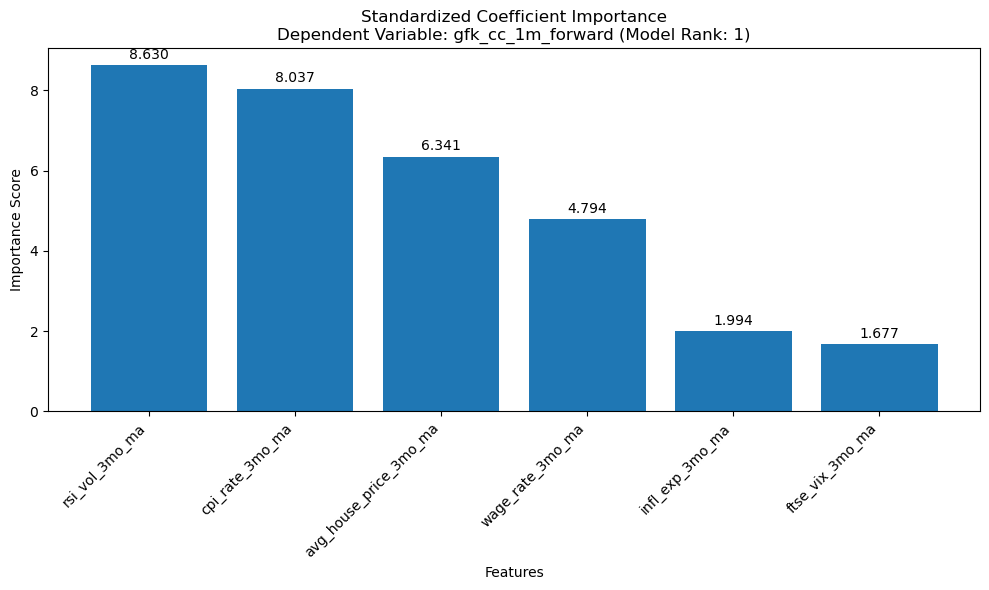


Feature Importance Rankings for gfk_cc_1m_forward (Model 1):
R² (Test): 0.9581
Adj. R² (Test): 0.9540

Feature Importance Scores:
1. rsi_vol_3mo_ma: 8.6301
2. cpi_rate_3mo_ma: 8.0370
3. avg_house_price_3mo_ma: 6.3410
4. wage_rate_3mo_ma: 4.7939
5. infl_exp_3mo_ma: 1.9940
6. ftse_vix_3mo_ma: 1.6770


In [82]:
importance_analysis = full_feature_importance_analysis(monthly, results, sentiment_cols, economic_cols, 'gfk_cc_1m_forward')

**Conclusion: speech sentiment (10-speech MA) hardly makes any difference in predicting consumer confidence  one month later. Economic indicators related to retail sales volume, inflation, house prices, and earnings have the most predictive power.**